In [17]:
import dirichletcal
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
from sklearn.calibration import CalibratedClassifierCV
import numpy as np
import pandas as pd
import pickle
import math
import optuna
import matplotlib.pyplot as plt
from sklearn.utils import shuffle
from sklearn import preprocessing
from NFLUtils import NFLUtils
nfl_utils = NFLUtils()
from MLBUtils import MLBUtils
mlb_utils = MLBUtils()

%matplotlib inline

import logging
# Set up logging
logging.basicConfig(level=logging.INFO)
# Set pandas display option to show all columns
pd.set_option('display.max_columns', None)

# XGBoost 
from xgboost import XGBClassifier, XGBRegressor
from sklearn.metrics import log_loss
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV, KFold, StratifiedKFold, cross_val_score, cross_val_predict
import seaborn as sns # confusion matrix

from dirichletcal.calib.fulldirichlet import FullDirichletCalibrator

# Set device to GPU if available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

import jax
jax.config.update("jax_platform_name", "cpu")

In [18]:
def set_all_seeds(seed=42):
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

### Load CSV
cp Combined.csv ~/drive/Notes/ML/Pytorch/baseballData/

Appears to be an issue with there being one less column

In [19]:
df = pd.read_csv("./baseballData/CombinedSlidingWindow20.csv", index_col=False, low_memory=False)
print(df.shape)

# MISSING ODDS DATA ARE ALREADY REMOVED 
# Remove missing odds data (This works?)
# df = df[df['D_start_odds'] != 0.0]

# UNSURE WHY THIS IS HERE, it's screwing up the custom loss A.K.A profit calculation
## Convert H_won from 0 or 1 to -1 or 1
# df['H_Won'] = (df['H_Won'] * 2) - 1

# Sign represents which team won. Value represents the implied probability (1/decimal = implied)
df['combined'] = np.where(df['H_Won'] == 1, df['H_Won'] * (1 / df['H_start_odds']), df['H_Won'] * (1 / df['V_start_odds']))

df['Home_Team'] = df['Home_Team'].astype('category')
df['Visitor_Team'] = df['Visitor_Team'].astype('category')
df['Home_Team_Id'] = df['Home_Team'].cat.codes
df['Visitor_Team_Id'] = df['Visitor_Team'].cat.codes

# Retrieve original team name given a category code
home_cat_mapping = df['Home_Team'].cat.categories
home_team_from_id = lambda cat_code: home_cat_mapping[cat_code]
visitor_cat_mapping = df['Visitor_Team'].cat.categories
visitor_team_from_id = lambda cat_code: visitor_cat_mapping[cat_code]

# Remove the performance set
test_performance_size = 600
test_performance_df = df[df.shape[0]-test_performance_size:]
df = df[:df.shape[0]-test_performance_size]

df.info()


(28377, 68)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 27777 entries, 0 to 27776
Data columns (total 71 columns):
 #   Column                Non-Null Count  Dtype   
---  ------                --------------  -----   
 0   Unnamed: 0            27777 non-null  int64   
 1   Date                  27777 non-null  object  
 2   Home_Team             27777 non-null  category
 3   Home_Wins             27777 non-null  int64   
 4   Home_Losses           27777 non-null  int64   
 5   Visitor_Team          27777 non-null  category
 6   Visitor_Wins          27777 non-null  int64   
 7   Visitor_Losses        27777 non-null  int64   
 8   Final_Score           27777 non-null  object  
 9   Visitor_Final_Score   27777 non-null  int64   
 10  Home_Final_Score      27777 non-null  int64   
 11  Winning_Team          27777 non-null  object  
 12  Home/Victory_Win      27777 non-null  object  
 13  Game_Time             27777 non-null  object  
 14  Winning_Pitcher       27777 non-null  obje

## 1. Separate continuous, categorical, and label column names

Pretty much everything is continuous. 

Note: the y_col is what you're trying to predict

## Feature engineering
New Columns
- **h_win**: Home team won


In [20]:
cont_cols = [
    # General
    
    # Random
    'D_AB',
    'D_R',
    'D_H',
    'D_BB',
    'D_PA',
    
    # Batting stats
    'D_SO',    # Strikeouts
    'D_BA',    # Batting Average
    'D_OBP',   # On-Base Percentage
    'D_SLG',   # Slugging Percentage
    'D_OPS',   # On-Base Plus Slugging
    'D_RBI',   # Runs Batted In
    'D_PIT',   # Pitches
    'D_STR',   # Strikes
    'D_WPA',   # Win Probability Added
    'D_aLI',   # Average Leverage Index

    # Pitching stats
    'D_P_H',   # Hits Allowed by Pitcher
    'D_P_R',   # Runs Allowed by Pitcher
    'D_ER',    # Earned Runs by Pitcher
    'D_P_BB',  # Walks by Pitcher
    'D_P_SO',  # Strikeouts by Pitcher
    'D_HR',    # Home Runs Allowed by Pitcher
    'D_ERA',   # Earned Run Average
    'D_CTCT',  # Contact Rate
    'D_STS',   # Swings and Misses (Strikes)
    'D_STL',   # Stolen Bases Against
    'D_GB',    # Ground Balls
    'D_FB',    # Fly Balls
    'D_LD',    # Line Drives
    'D_GSC',   # Game Score
    'D_P_WPA', # Pitcher Win Probability Added
    'D_P_aLI', # Pitcher Average Leverage Index

    # Odds
    'D_start_odds',

    # Calculated
    'D_pythagorean',
    
    # Remove later
    # 'D_Final_Score',
    # 'D_Final_Allowed'
]

drop_cols = [ 'D_BA', 'D_datediff', 'D_AB', 'D_P_WPA', 'D_P_H', 'D_ER', 'D_BA', 'D_ERA', 'D_SLG', 'D_H', 'D_STR' ]
y_col = ['H_Won', 'H_start_odds', 'V_start_odds', 'Home_Team_Id', 'Visitor_Team_Id', 'combined']
# y_col = ['H_Won', 'H_start_odds', 'V_start_odds' ,'combined']
cont_cols = [col for col in cont_cols if col not in drop_cols]

# Create cont_df and y_df from the filtered df
cont_df = df[cont_cols]
y_df = df[y_col]


# test performance set
perf_conts_df = test_performance_df[cont_cols]
perf_y_df = test_performance_df[y_col]
perf_date_df = test_performance_df[['Date','Home_Team', 'Visitor_Team']]

print(cont_df.dtypes)
print(y_df.dtypes)

D_R              float64
D_BB             float64
D_PA             float64
D_SO             float64
D_OBP            float64
D_OPS            float64
D_RBI            float64
D_PIT            float64
D_WPA            float64
D_aLI            float64
D_P_R            float64
D_P_BB           float64
D_P_SO           float64
D_HR             float64
D_CTCT           float64
D_STS            float64
D_STL            float64
D_GB             float64
D_FB             float64
D_LD             float64
D_GSC            float64
D_P_aLI          float64
D_start_odds     float64
D_pythagorean    float64
dtype: object
H_Won              float64
H_start_odds       float64
V_start_odds       float64
Home_Team_Id          int8
Visitor_Team_Id       int8
combined           float64
dtype: object


### Create an array of continuous values
Numpy array 'conts' containing stack of each continuous column

In [21]:
# The column headers no longer match cont_cols b/c normalization
conts = np.stack([cont_df[col].values for col in list(cont_df.columns)], 1)
conts[:5]

y_col = np.stack([y_df[col].values for col in y_col], 1)

# test performance set
perf_conts = np.stack([perf_conts_df[col].values for col in list(perf_conts_df.columns)], 1)
perf_y_col = np.stack([perf_y_df[col].values for col in list(perf_y_df.columns)], 1)
perf_date_col = np.stack([perf_date_df[col].values for col in list(perf_date_df.columns)], 1)


conts_train = conts
y_train = y_col

In [22]:
print(perf_y_col[:,0])

[1. 1. 0. 1. 0. 0. 1. 1. 0. 1. 0. 1. 0. 0. 1. 1. 0. 1. 0. 1. 0. 1. 1. 0.
 1. 1. 0. 1. 0. 0. 1. 1. 0. 0. 1. 1. 1. 1. 1. 1. 0. 0. 0. 0. 1. 1. 0. 1.
 1. 0. 0. 0. 0. 1. 0. 0. 0. 1. 0. 1. 0. 0. 0. 0. 1. 1. 1. 1. 1. 1. 1. 0.
 1. 0. 0. 0. 0. 1. 1. 0. 0. 0. 0. 0. 1. 1. 1. 0. 0. 1. 0. 1. 1. 0. 0. 0.
 1. 1. 1. 1. 0. 1. 0. 1. 1. 0. 1. 1. 0. 1. 1. 1. 1. 0. 1. 1. 0. 0. 1. 1.
 1. 0. 0. 1. 0. 0. 0. 0. 0. 1. 0. 0. 0. 1. 0. 0. 0. 0. 1. 1. 1. 0. 1. 0.
 1. 0. 1. 0. 0. 0. 0. 0. 1. 0. 0. 1. 0. 0. 0. 0. 1. 0. 0. 0. 1. 1. 0. 1.
 1. 0. 1. 0. 1. 0. 0. 1. 1. 1. 0. 1. 0. 0. 0. 1. 1. 1. 1. 0. 1. 0. 0. 1.
 1. 0. 0. 1. 1. 1. 0. 1. 0. 0. 0. 0. 0. 0. 1. 1. 1. 1. 1. 1. 1. 1. 0. 0.
 1. 1. 1. 0. 1. 1. 1. 0. 0. 1. 0. 1. 1. 1. 0. 0. 0. 0. 1. 1. 1. 1. 1. 1.
 1. 0. 0. 1. 0. 1. 0. 0. 0. 1. 0. 1. 0. 1. 1. 1. 1. 0. 0. 0. 0. 0. 1. 0.
 1. 0. 0. 1. 1. 1. 1. 1. 1. 1. 1. 0. 1. 0. 1. 0. 0. 1. 0. 0. 1. 1. 0. 1.
 0. 1. 1. 0. 0. 0. 1. 1. 1. 1. 1. 1. 0. 0. 1. 0. 0. 0. 1. 1. 1. 0. 0. 1.
 1. 1. 1. 1. 0. 0. 0. 1. 1. 1. 0. 0. 0. 0. 0. 0. 1.

In [23]:
cont_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 27777 entries, 0 to 27776
Data columns (total 24 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   D_R            27777 non-null  float64
 1   D_BB           27777 non-null  float64
 2   D_PA           27777 non-null  float64
 3   D_SO           27777 non-null  float64
 4   D_OBP          27777 non-null  float64
 5   D_OPS          27777 non-null  float64
 6   D_RBI          27777 non-null  float64
 7   D_PIT          27777 non-null  float64
 8   D_WPA          27777 non-null  float64
 9   D_aLI          27777 non-null  float64
 10  D_P_R          27777 non-null  float64
 11  D_P_BB         27777 non-null  float64
 12  D_P_SO         27777 non-null  float64
 13  D_HR           27777 non-null  float64
 14  D_CTCT         27777 non-null  float64
 15  D_STS          27777 non-null  float64
 16  D_STL          27777 non-null  float64
 17  D_GB           27777 non-null  float64
 18  D_FB  

In [24]:
def convert_probas(probas, local_y_col):
    """
    Using y_col, this converts 2d array of probas into a format that works with the backtest calculation.
    That is, 
    
    probas: 2d array with first element being predicted visitor odds & other being predicted home odds
    y_col: ['H_Won', 'H_start_odds', 'V_start_odds', 'Home_Team_Id', 'Visitor_Team_Id', 'combined']
    """
    # Convert to decimal odds, apply 5% vig estimate
    local_y_col[:,1] = (1 / local_y_col[:,1]) / 1.05
    local_y_col[:,2] = (1 / local_y_col[:,2]) / 1.05
    # probas[:,1] = (1 / probas[:,1])
    # probas[:,0] = (1 / probas[:,0])
    override_req = True
    
    # Set to 0 if < the model's implied probability
    bet_res = []
    for i in range(len(probas)):
        if (probas[i,1] > local_y_col[i,1] or override_req == True) and probas[i,1] > probas[i,0]:
            bet_res.append(probas[i,1]) # Convert back to decimal odds
        elif (probas[i,0] > local_y_col[i,2] or override_req == True) and probas[i,0] > probas[i,1]:
            bet_res.append((-1*probas[i,0])) # Convert back to decimal odds
        else:
            print(f"{probas[i,:]} local ycol = {local_y_col[i,:]}")
            bet_res.append(0)
    return np.array(bet_res)

# Using XGBoost

## Using custom objective function & eval metric

### Objective function:

In [25]:
def sle_with_penalty(lambda_penalty=0.1):
    def sle(labels: np.ndarray, predt: np.ndarray) -> tuple[np.ndarray, np.ndarray]:
        """
        predt: Predictions made by XGBoost (-1, 1)
        labels: Sign represents which team won (- = visitor won). Value represents the implied probability for the winning team
    
        1. Convert both predt & label to implied probability 
        1a. Define incorrect_bet_increment
        2. Apply SLE
        3. Apply similarity penalty
        4. Combine grad, hess with similarity_penalty and incorrect_bet_penalty
        """
        # print(f"labels shape: {labels.shape} predt shape: {predt.shape}")
        epsilon=1e-6
        predt_h_won = np.where(predt > 0, 1, 0)
        y_h_won = np.where(labels > 0, 1, 0)
        predt_sle = np.clip(predt, epsilon, 1-epsilon)
        predt_sle = (predt_sle + 1) / 2
        # print(predt_sle)
        
        # 1. Convert both predt & label to implied probability
        # Get sportsbook prediction (decimal odds)
        sportsbook_pred = np.abs(labels)
        # Convert XGBoost predictions (-1 to 1) to implied probability since we have sportsbook predictions.
        predt_impl = np.where(predt > 0, (predt + 1) / 2, (1 - predt) / 2) 
    
        # 1a. Define incorrect_bet_increment
        # Compare H_won. Create new array where 1 = incorrect bet, 0 otherwise
        # incorrect_bet_increment = np.where(predt_h_won == y_h_won, 1, 2)
        
        
        # 2. Apply SLE (prediction b/t 0 and 1) (note, incorrect predictions are included here and in 3)
        # SLE gradient and hessian
        sle_grad = (np.log1p(predt_sle) - np.log1p(y_h_won)) / (predt_sle + 1)
        sle_hess = ((-np.log1p(predt_sle) + np.log1p(y_h_won) + 1) / (predt_sle + 1)**2)
    
        
        # 3. Apply similarity penalty (for implied probability)
        # Penalty term: lambda / (|predt_impl - sportsbook_pred| + epsilon)
        diff = np.abs(predt_impl - sportsbook_pred)
        penalty = lambda_penalty / (diff + epsilon)
        # Gradient of penalty term: d(penalty)/d(predt)
        penalty_grad = -lambda_penalty * np.sign(predt_impl - sportsbook_pred) / (diff + epsilon)**2
        # Hessian of penalty term: d^2(penalty)/d(predt)^2
        penalty_hess = 2 * lambda_penalty / (diff + epsilon)**3
    
        # 4. Combine grad, hess with similarity_penalty and incorrect_bet_increment
        grad = sle_grad + penalty_grad #  * incorrect_bet_increment
        hess = sle_hess + penalty_hess #  * incorrect_bet_increment
    
        # print(f"Grad Shape {grad.shape} Hess: {hess.shape}")
        return grad, hess
    return sle


#### Eval metric 

In [10]:
# perf_y_col[:,0]

### Old approach (not based on calibration)

In [11]:
def objective(trial, override_params=None):
    """
    When doing optuna training: trial is defined, override_params left as None
    when recreating model using best parameters (override_params): trial is None, override_params are defined
    """
    is_training = trial != None
    # --- Suggest hyperparameters ---
    if is_training:
        params = {
            'learning_rate': trial.suggest_float('learning_rate', 0.001, 0.3, log=True),
            'max_depth': trial.suggest_int('max_depth', 3, 12),
            'n_estimators': trial.suggest_int('n_estimators', 50, 500),
            'subsample': trial.suggest_float('subsample', 0.6, 1.0),
            'colsample_bytree': trial.suggest_float('colsample_bytree', 0.6, 1.0),
            'min_child_weight': trial.suggest_int('min_child_weight', 1, 10),
            'reg_lambda': trial.suggest_float('reg_lambda', 1e-6, 1e-1, log=True)
        }
    else:
        params=override_params

    y_train_zero = y_train[:,0]
    x_train_obj, x_test_obj, y_train_obj, y_test_obj = train_test_split(conts_train, y_train_zero, random_state=1, test_size=0.3)
    classifier = XGBClassifier(
        objective='binary:logistic',
        eval_metric='logloss',
        **{k: v for k, v in params.items() if k != 'reg_lambda'}
    )
    # cv = StratifiedKFold(n_splits=5, shuffle=False)
    # scores = cross_val_score(classifier, x_train_obj, y_train_obj, cv=cv, scoring='neg_log_loss')
    # preds = cross_val_predict(classifier, x_train_obj, y_train_obj, cv=cv, method='predict_proba')
    classifier.fit(x_train_obj, y_train_obj)
    cla_scores_train = classifier.predict_proba(x_train_obj) # FullDirichletCalibrator expects 2D on fit & predict 
    cla_scores_test = classifier.predict_proba(x_test_obj)
    # cal_scores_test = classifier.predict(x_test_obj)
    
    # ----- Full Dirichlet (alternative to ODIR Dirichlet) -----
    # Expects input as shape of probabilities
    calibrator = FullDirichletCalibrator(reg_lambda=params['reg_lambda'], reg_mu=None)
    calibrator.fit(cla_scores_train, y_train_obj)
    cal_scores_test = calibrator.predict_proba(cla_scores_test)
    # cla_scores_test = calibrator.predict(cla_scores_test)

    
    # print(cal)
    cal_loss = log_loss(y_test_obj, cal_scores_test)
    cla_loss = log_loss(y_test_obj, cla_scores_test)

    if is_training:
        return 0.8 * cal_loss + 0.2 * cla_loss
        # return cal_loss + cla_loss
    return classifier, calibrator
    # return cla_loss

def print_callback(study, trial):
    print(f"Trial {trial.number} finished with value: {trial.value}")
    print(f"Best trial so far: {study.best_trial.number}, value: {study.best_trial.value}")
    
    

In [12]:
study = optuna.create_study(
    direction='minimize',
    pruner=optuna.pruners.HyperbandPruner(min_resource=1, max_resource=1000)
)

study.optimize(objective, n_trials=400, callbacks=[print_callback])
print("Best trial:")
trial = study.best_trial
print("Value: ", trial.value)
print("Params: ")
for key, value in trial.params.items():
    print(f"    {key}: {value}")

[I 2025-08-02 15:36:39,458] A new study created in memory with name: no-name-78276bcf-acb8-4ec6-8b0f-3bab5d7d47e4
INFO:2025-08-02 15:36:39,884:jax._src.xla_bridge:927: Unable to initialize backend 'rocm': module 'jaxlib.xla_extension' has no attribute 'GpuAllocatorConfig'
INFO:jax._src.xla_bridge:Unable to initialize backend 'rocm': module 'jaxlib.xla_extension' has no attribute 'GpuAllocatorConfig'
INFO:2025-08-02 15:36:39,891:jax._src.xla_bridge:927: Unable to initialize backend 'tpu': INTERNAL: Failed to open libtpu.so: dlopen(libtpu.so, 0x0001): tried: 'libtpu.so' (no such file), '/System/Volumes/Preboot/Cryptexes/OSlibtpu.so' (no such file), '/Users/forbesjon2/anaconda3/envs/pytorchenv/bin/../lib/libtpu.so' (no such file), '/usr/lib/libtpu.so' (no such file, not in dyld cache), 'libtpu.so' (no such file), '/usr/local/lib/libtpu.so' (no such file), '/usr/lib/libtpu.so' (no such file, not in dyld cache)
INFO:jax._src.xla_bridge:Unable to initialize backend 'tpu': INTERNAL: Failed to

Trial 0 finished with value: 0.6783968500303276
Best trial so far: 0, value: 0.6783968500303276


[I 2025-08-02 15:36:50,036] Trial 1 finished with value: 0.7393030324453578 and parameters: {'learning_rate': 0.006070579021517179, 'max_depth': 8, 'n_estimators': 202, 'subsample': 0.7725670596298376, 'colsample_bytree': 0.9606774273279604, 'min_child_weight': 3, 'reg_lambda': 3.977286251883194e-06}. Best is trial 0 with value: 0.6783968500303276.


Trial 1 finished with value: 0.7393030324453578
Best trial so far: 0, value: 0.6783968500303276


[I 2025-08-02 15:36:53,918] Trial 2 finished with value: 1.5660857164189326 and parameters: {'learning_rate': 0.020355495788369152, 'max_depth': 11, 'n_estimators': 252, 'subsample': 0.8199539264982499, 'colsample_bytree': 0.9638429610048007, 'min_child_weight': 2, 'reg_lambda': 7.24625851025257e-05}. Best is trial 0 with value: 0.6783968500303276.


Trial 2 finished with value: 1.5660857164189326
Best trial so far: 0, value: 0.6783968500303276


[I 2025-08-02 15:36:54,659] Trial 3 finished with value: 0.6763298532827525 and parameters: {'learning_rate': 0.0016984589469777641, 'max_depth': 4, 'n_estimators': 496, 'subsample': 0.947154055904086, 'colsample_bytree': 0.8021190861938088, 'min_child_weight': 9, 'reg_lambda': 1.2921081869582701e-06}. Best is trial 3 with value: 0.6763298532827525.


Trial 3 finished with value: 0.6763298532827525
Best trial so far: 3, value: 0.6763298532827525


[I 2025-08-02 15:36:55,955] Trial 4 finished with value: 0.7790225056532325 and parameters: {'learning_rate': 0.06027935140666802, 'max_depth': 12, 'n_estimators': 132, 'subsample': 0.8288265222392928, 'colsample_bytree': 0.7922084065838715, 'min_child_weight': 5, 'reg_lambda': 0.011866476020549877}. Best is trial 3 with value: 0.6763298532827525.


Trial 4 finished with value: 0.7790225056532325
Best trial so far: 3, value: 0.6763298532827525


[I 2025-08-02 15:36:56,480] Trial 5 finished with value: 0.6754523027251422 and parameters: {'learning_rate': 0.006475200202298035, 'max_depth': 4, 'n_estimators': 281, 'subsample': 0.9679145338229304, 'colsample_bytree': 0.9021565492340837, 'min_child_weight': 10, 'reg_lambda': 0.0005784637855260803}. Best is trial 5 with value: 0.6754523027251422.


Trial 5 finished with value: 0.6754523027251422
Best trial so far: 5, value: 0.6754523027251422


[I 2025-08-02 15:36:59,323] Trial 6 finished with value: 0.6799097760674164 and parameters: {'learning_rate': 0.0038242288873364975, 'max_depth': 12, 'n_estimators': 148, 'subsample': 0.8355229914692208, 'colsample_bytree': 0.7200970207788545, 'min_child_weight': 2, 'reg_lambda': 0.016310812890836128}. Best is trial 5 with value: 0.6754523027251422.


Trial 6 finished with value: 0.6799097760674164
Best trial so far: 5, value: 0.6754523027251422


[I 2025-08-02 15:37:00,043] Trial 7 finished with value: 0.7884835601915612 and parameters: {'learning_rate': 0.16665833061630428, 'max_depth': 7, 'n_estimators': 201, 'subsample': 0.6716868497270627, 'colsample_bytree': 0.8675283397373446, 'min_child_weight': 1, 'reg_lambda': 0.03594935490949246}. Best is trial 5 with value: 0.6754523027251422.


Trial 7 finished with value: 0.7884835601915612
Best trial so far: 5, value: 0.6754523027251422


[I 2025-08-02 15:37:04,528] Trial 8 finished with value: 1.8840885701413315 and parameters: {'learning_rate': 0.14291960978772145, 'max_depth': 11, 'n_estimators': 425, 'subsample': 0.8295836406385574, 'colsample_bytree': 0.9054227218279609, 'min_child_weight': 1, 'reg_lambda': 1.273387077345863e-06}. Best is trial 5 with value: 0.6754523027251422.


Trial 8 finished with value: 1.8840885701413315
Best trial so far: 5, value: 0.6754523027251422


[I 2025-08-02 15:37:05,009] Trial 9 finished with value: 0.6779403319781446 and parameters: {'learning_rate': 0.015042192063064485, 'max_depth': 3, 'n_estimators': 466, 'subsample': 0.7907649060010037, 'colsample_bytree': 0.9898277972187415, 'min_child_weight': 1, 'reg_lambda': 0.020469170967420017}. Best is trial 5 with value: 0.6754523027251422.


Trial 9 finished with value: 0.6779403319781446
Best trial so far: 5, value: 0.6754523027251422


[I 2025-08-02 15:37:05,666] Trial 10 finished with value: 0.6767946440351085 and parameters: {'learning_rate': 0.0011920082559740265, 'max_depth': 5, 'n_estimators': 367, 'subsample': 0.9974154789448891, 'colsample_bytree': 0.8593699958929413, 'min_child_weight': 7, 'reg_lambda': 0.0006763482213718062}. Best is trial 5 with value: 0.6754523027251422.


Trial 10 finished with value: 0.6767946440351085
Best trial so far: 5, value: 0.6754523027251422


[I 2025-08-02 15:37:06,110] Trial 11 finished with value: 0.6756577716264935 and parameters: {'learning_rate': 0.0010083816713204845, 'max_depth': 3, 'n_estimators': 356, 'subsample': 0.9892455813854075, 'colsample_bytree': 0.7982757055596227, 'min_child_weight': 10, 'reg_lambda': 0.00014940083832831722}. Best is trial 5 with value: 0.6754523027251422.


Trial 11 finished with value: 0.6756577716264935
Best trial so far: 5, value: 0.6754523027251422


[I 2025-08-02 15:37:06,597] Trial 12 finished with value: 0.6742726067712221 and parameters: {'learning_rate': 0.004519009875900335, 'max_depth': 3, 'n_estimators': 354, 'subsample': 0.9908342418608219, 'colsample_bytree': 0.7547192891936582, 'min_child_weight': 10, 'reg_lambda': 0.00015936525145823525}. Best is trial 12 with value: 0.6742726067712221.


Trial 12 finished with value: 0.6742726067712221
Best trial so far: 12, value: 0.6742726067712221


[I 2025-08-02 15:37:07,252] Trial 13 finished with value: 0.6781927790078519 and parameters: {'learning_rate': 0.006812523849960474, 'max_depth': 5, 'n_estimators': 336, 'subsample': 0.9052015427087626, 'colsample_bytree': 0.7296375125897021, 'min_child_weight': 7, 'reg_lambda': 0.0012400273817115275}. Best is trial 12 with value: 0.6742726067712221.


Trial 13 finished with value: 0.6781927790078519
Best trial so far: 12, value: 0.6742726067712221


[I 2025-08-02 15:37:07,913] Trial 14 finished with value: 0.7150300309498883 and parameters: {'learning_rate': 0.004054377103359879, 'max_depth': 9, 'n_estimators': 66, 'subsample': 0.8909401941920317, 'colsample_bytree': 0.6131073865191081, 'min_child_weight': 10, 'reg_lambda': 2.6663845772073256e-05}. Best is trial 12 with value: 0.6742726067712221.


Trial 14 finished with value: 0.7150300309498883
Best trial so far: 12, value: 0.6742726067712221


[I 2025-08-02 15:37:08,437] Trial 15 finished with value: 0.679433808700012 and parameters: {'learning_rate': 0.012452783470730271, 'max_depth': 4, 'n_estimators': 309, 'subsample': 0.6986622235319178, 'colsample_bytree': 0.7372990877764216, 'min_child_weight': 8, 'reg_lambda': 1.8208619980711056e-05}. Best is trial 12 with value: 0.6742726067712221.


Trial 15 finished with value: 0.679433808700012
Best trial so far: 12, value: 0.6742726067712221


[I 2025-08-02 15:37:08,918] Trial 16 finished with value: 0.6756863737942483 and parameters: {'learning_rate': 0.002441684023302563, 'max_depth': 3, 'n_estimators': 408, 'subsample': 0.6137053666330577, 'colsample_bytree': 0.9154826861869456, 'min_child_weight': 5, 'reg_lambda': 0.002617118900875719}. Best is trial 12 with value: 0.6742726067712221.


Trial 16 finished with value: 0.6756863737942483
Best trial so far: 12, value: 0.6742726067712221


[I 2025-08-02 15:37:09,773] Trial 17 finished with value: 0.6783670175720704 and parameters: {'learning_rate': 0.007758298767708058, 'max_depth': 6, 'n_estimators': 299, 'subsample': 0.9538019485050324, 'colsample_bytree': 0.6789227003209096, 'min_child_weight': 7, 'reg_lambda': 0.0035377332396142203}. Best is trial 12 with value: 0.6742726067712221.


Trial 17 finished with value: 0.6783670175720704
Best trial so far: 12, value: 0.6742726067712221


[I 2025-08-02 15:37:10,481] Trial 18 finished with value: 0.6778080988531034 and parameters: {'learning_rate': 0.0028680246727426487, 'max_depth': 5, 'n_estimators': 401, 'subsample': 0.8760640035857393, 'colsample_bytree': 0.848443542642685, 'min_child_weight': 9, 'reg_lambda': 0.00035338963890501495}. Best is trial 12 with value: 0.6742726067712221.


Trial 18 finished with value: 0.6778080988531034
Best trial so far: 12, value: 0.6742726067712221


[I 2025-08-02 15:37:11,797] Trial 19 finished with value: 1.26535533278299 and parameters: {'learning_rate': 0.038853764097932314, 'max_depth': 9, 'n_estimators': 241, 'subsample': 0.9571605823806736, 'colsample_bytree': 0.7645718342104036, 'min_child_weight': 6, 'reg_lambda': 7.459489021386371e-05}. Best is trial 12 with value: 0.6742726067712221.


Trial 19 finished with value: 1.26535533278299
Best trial so far: 12, value: 0.6742726067712221


[I 2025-08-02 15:37:12,323] Trial 20 finished with value: 0.6784511981732615 and parameters: {'learning_rate': 0.01040683538362662, 'max_depth': 4, 'n_estimators': 320, 'subsample': 0.8776931753529332, 'colsample_bytree': 0.9086943774167978, 'min_child_weight': 10, 'reg_lambda': 1.1188390680741208e-05}. Best is trial 12 with value: 0.6742726067712221.


Trial 20 finished with value: 0.6784511981732615
Best trial so far: 12, value: 0.6742726067712221


[I 2025-08-02 15:37:12,821] Trial 21 finished with value: 0.6754381724030779 and parameters: {'learning_rate': 0.0011490846052729037, 'max_depth': 3, 'n_estimators': 362, 'subsample': 0.9923297408269789, 'colsample_bytree': 0.8143332889949463, 'min_child_weight': 10, 'reg_lambda': 0.00015258094317510286}. Best is trial 12 with value: 0.6742726067712221.


Trial 21 finished with value: 0.6754381724030779
Best trial so far: 12, value: 0.6742726067712221


[I 2025-08-02 15:37:13,341] Trial 22 finished with value: 0.6745942453369674 and parameters: {'learning_rate': 0.0021027110008790535, 'max_depth': 3, 'n_estimators': 380, 'subsample': 0.9870032267353522, 'colsample_bytree': 0.8234642829990425, 'min_child_weight': 8, 'reg_lambda': 0.00027394604809577303}. Best is trial 12 with value: 0.6742726067712221.


Trial 22 finished with value: 0.6745942453369674
Best trial so far: 12, value: 0.6742726067712221


[I 2025-08-02 15:37:13,843] Trial 23 finished with value: 0.6748075704472785 and parameters: {'learning_rate': 0.001886274040643482, 'max_depth': 3, 'n_estimators': 379, 'subsample': 0.9954104318872946, 'colsample_bytree': 0.831230826845746, 'min_child_weight': 8, 'reg_lambda': 0.00013714168402312004}. Best is trial 12 with value: 0.6742726067712221.


Trial 23 finished with value: 0.6748075704472785
Best trial so far: 12, value: 0.6742726067712221


[I 2025-08-02 15:37:14,870] Trial 24 finished with value: 0.6834691905850847 and parameters: {'learning_rate': 0.001972908172091225, 'max_depth': 6, 'n_estimators': 433, 'subsample': 0.9292654694552418, 'colsample_bytree': 0.8306598006535924, 'min_child_weight': 8, 'reg_lambda': 0.00018169434899112624}. Best is trial 12 with value: 0.6742726067712221.


Trial 24 finished with value: 0.6834691905850847
Best trial so far: 12, value: 0.6742726067712221


[I 2025-08-02 15:37:15,378] Trial 25 finished with value: 0.6743032806926618 and parameters: {'learning_rate': 0.0036280591291007057, 'max_depth': 3, 'n_estimators': 383, 'subsample': 0.7314207141806983, 'colsample_bytree': 0.7719826278262669, 'min_child_weight': 8, 'reg_lambda': 3.69887484896661e-05}. Best is trial 12 with value: 0.6742726067712221.


Trial 25 finished with value: 0.6743032806926618
Best trial so far: 12, value: 0.6742726067712221


[I 2025-08-02 15:37:15,984] Trial 26 finished with value: 0.676360534638327 and parameters: {'learning_rate': 0.0038535018764722408, 'max_depth': 4, 'n_estimators': 455, 'subsample': 0.7411034912983351, 'colsample_bytree': 0.6988137301594075, 'min_child_weight': 6, 'reg_lambda': 7.887721546220228e-06}. Best is trial 12 with value: 0.6742726067712221.


Trial 26 finished with value: 0.676360534638327
Best trial so far: 12, value: 0.6742726067712221


[I 2025-08-02 15:37:16,733] Trial 27 finished with value: 0.6806573124034259 and parameters: {'learning_rate': 0.004559874270792489, 'max_depth': 5, 'n_estimators': 394, 'subsample': 0.7337089134190214, 'colsample_bytree': 0.7667244915383729, 'min_child_weight': 9, 'reg_lambda': 4.909085019142675e-05}. Best is trial 12 with value: 0.6742726067712221.


Trial 27 finished with value: 0.6806573124034259
Best trial so far: 12, value: 0.6742726067712221


[I 2025-08-02 15:37:17,828] Trial 28 finished with value: 0.7002187705593824 and parameters: {'learning_rate': 0.0030879550631232764, 'max_depth': 7, 'n_estimators': 337, 'subsample': 0.6628451731762259, 'colsample_bytree': 0.7612114898313578, 'min_child_weight': 4, 'reg_lambda': 3.5146339403009724e-05}. Best is trial 12 with value: 0.6742726067712221.


Trial 28 finished with value: 0.7002187705593824
Best trial so far: 12, value: 0.6742726067712221


[I 2025-08-02 15:37:18,372] Trial 29 finished with value: 0.6778465719995665 and parameters: {'learning_rate': 0.025450868887639075, 'max_depth': 3, 'n_estimators': 489, 'subsample': 0.7500059601152949, 'colsample_bytree': 0.6719427258383708, 'min_child_weight': 9, 'reg_lambda': 0.0027148080096480484}. Best is trial 12 with value: 0.6742726067712221.


Trial 29 finished with value: 0.6778465719995665
Best trial so far: 12, value: 0.6742726067712221


[I 2025-08-02 15:37:19,397] Trial 30 finished with value: 1.911628574659768 and parameters: {'learning_rate': 0.26564460827200026, 'max_depth': 5, 'n_estimators': 445, 'subsample': 0.9168858555910231, 'colsample_bytree': 0.6357770685202959, 'min_child_weight': 8, 'reg_lambda': 5.393586724028985e-06}. Best is trial 12 with value: 0.6742726067712221.


Trial 30 finished with value: 1.911628574659768
Best trial so far: 12, value: 0.6742726067712221


[I 2025-08-02 15:37:19,926] Trial 31 finished with value: 0.6747629497269023 and parameters: {'learning_rate': 0.0017698263817441005, 'max_depth': 3, 'n_estimators': 382, 'subsample': 0.9751132740648735, 'colsample_bytree': 0.8287097685401744, 'min_child_weight': 8, 'reg_lambda': 0.00029094837357219756}. Best is trial 12 with value: 0.6742726067712221.


Trial 31 finished with value: 0.6747629497269023
Best trial so far: 12, value: 0.6742726067712221


[I 2025-08-02 15:37:20,542] Trial 32 finished with value: 0.6755031816292542 and parameters: {'learning_rate': 0.001488145712649923, 'max_depth': 4, 'n_estimators': 393, 'subsample': 0.9399161168261312, 'colsample_bytree': 0.7767787180984128, 'min_child_weight': 7, 'reg_lambda': 0.0004630816351661669}. Best is trial 12 with value: 0.6742726067712221.


Trial 32 finished with value: 0.6755031816292542
Best trial so far: 12, value: 0.6742726067712221


[I 2025-08-02 15:37:21,033] Trial 33 finished with value: 0.6748734608298761 and parameters: {'learning_rate': 0.0024668345442940697, 'max_depth': 3, 'n_estimators': 340, 'subsample': 0.8601429884437327, 'colsample_bytree': 0.8765886600721392, 'min_child_weight': 8, 'reg_lambda': 0.0011403812227183013}. Best is trial 12 with value: 0.6742726067712221.


Trial 33 finished with value: 0.6748734608298761
Best trial so far: 12, value: 0.6742726067712221


[I 2025-08-02 15:37:21,799] Trial 34 finished with value: 0.6873805860979961 and parameters: {'learning_rate': 0.004835687344049658, 'max_depth': 6, 'n_estimators': 284, 'subsample': 0.97117628507346, 'colsample_bytree': 0.8262472435898689, 'min_child_weight': 9, 'reg_lambda': 7.907006978937011e-05}. Best is trial 12 with value: 0.6742726067712221.


Trial 34 finished with value: 0.6873805860979961
Best trial so far: 12, value: 0.6742726067712221


[I 2025-08-02 15:37:22,381] Trial 35 finished with value: 0.6790348623270661 and parameters: {'learning_rate': 0.009579487123157916, 'max_depth': 4, 'n_estimators': 375, 'subsample': 0.7794297788598636, 'colsample_bytree': 0.7475640914878198, 'min_child_weight': 6, 'reg_lambda': 1.8033912082952572e-05}. Best is trial 12 with value: 0.6742726067712221.


Trial 35 finished with value: 0.6790348623270661
Best trial so far: 12, value: 0.6742726067712221


[I 2025-08-02 15:37:22,882] Trial 36 finished with value: 0.6759033484321518 and parameters: {'learning_rate': 0.001546145025986226, 'max_depth': 4, 'n_estimators': 243, 'subsample': 0.7064023997820672, 'colsample_bytree': 0.7824865240693352, 'min_child_weight': 9, 'reg_lambda': 0.00031451067382759577}. Best is trial 12 with value: 0.6742726067712221.


Trial 36 finished with value: 0.6759033484321518
Best trial so far: 12, value: 0.6742726067712221


[I 2025-08-02 15:37:23,407] Trial 37 finished with value: 0.6755441027949961 and parameters: {'learning_rate': 0.005498858059251394, 'max_depth': 3, 'n_estimators': 416, 'subsample': 0.9748705718158239, 'colsample_bytree': 0.7040387735365451, 'min_child_weight': 7, 'reg_lambda': 0.005661092235756872}. Best is trial 12 with value: 0.6742726067712221.


Trial 37 finished with value: 0.6755441027949961
Best trial so far: 12, value: 0.6742726067712221


[I 2025-08-02 15:37:27,505] Trial 38 finished with value: 0.7103122319549591 and parameters: {'learning_rate': 0.0020409471751736893, 'max_depth': 9, 'n_estimators': 476, 'subsample': 0.9331948926778418, 'colsample_bytree': 0.7986376376393398, 'min_child_weight': 4, 'reg_lambda': 0.0011404261571786116}. Best is trial 12 with value: 0.6742726067712221.


Trial 38 finished with value: 0.7103122319549591
Best trial so far: 12, value: 0.6742726067712221


[I 2025-08-02 15:37:29,041] Trial 39 finished with value: 0.7017270344555336 and parameters: {'learning_rate': 0.0031442048322238895, 'max_depth': 8, 'n_estimators': 267, 'subsample': 0.8153001001009463, 'colsample_bytree': 0.9427348718511158, 'min_child_weight': 8, 'reg_lambda': 0.0002660403656356148}. Best is trial 12 with value: 0.6742726067712221.


Trial 39 finished with value: 0.7017270344555336
Best trial so far: 12, value: 0.6742726067712221


[I 2025-08-02 15:37:29,693] Trial 40 finished with value: 0.6867833259645457 and parameters: {'learning_rate': 0.0013470381327678508, 'max_depth': 4, 'n_estimators': 438, 'subsample': 0.8523801444403053, 'colsample_bytree': 0.883387671942321, 'min_child_weight': 10, 'reg_lambda': 0.06187717445258753}. Best is trial 12 with value: 0.6742726067712221.


Trial 40 finished with value: 0.6867833259645457
Best trial so far: 12, value: 0.6742726067712221


[I 2025-08-02 15:37:30,237] Trial 41 finished with value: 0.6747691001888079 and parameters: {'learning_rate': 0.001959676452650928, 'max_depth': 3, 'n_estimators': 390, 'subsample': 0.9995642700564696, 'colsample_bytree': 0.8341501426392373, 'min_child_weight': 8, 'reg_lambda': 8.833297978876479e-05}. Best is trial 12 with value: 0.6742726067712221.


Trial 41 finished with value: 0.6747691001888079
Best trial so far: 12, value: 0.6742726067712221


[I 2025-08-02 15:37:30,756] Trial 42 finished with value: 0.6747333496509028 and parameters: {'learning_rate': 0.0022406684386626526, 'max_depth': 3, 'n_estimators': 348, 'subsample': 0.9722368791357224, 'colsample_bytree': 0.8477714369578215, 'min_child_weight': 8, 'reg_lambda': 7.70417607157227e-05}. Best is trial 12 with value: 0.6742726067712221.


Trial 42 finished with value: 0.6747333496509028
Best trial so far: 12, value: 0.6742726067712221


[I 2025-08-02 15:37:31,250] Trial 43 finished with value: 0.6745216995185267 and parameters: {'learning_rate': 0.0032328714023448974, 'max_depth': 3, 'n_estimators': 351, 'subsample': 0.9700769778756184, 'colsample_bytree': 0.8093693898557289, 'min_child_weight': 9, 'reg_lambda': 5.543479461074508e-05}. Best is trial 12 with value: 0.6742726067712221.


Trial 43 finished with value: 0.6745216995185267
Best trial so far: 12, value: 0.6742726067712221


[I 2025-08-02 15:37:31,811] Trial 44 finished with value: 0.6761426039124139 and parameters: {'learning_rate': 0.0033973321425410843, 'max_depth': 4, 'n_estimators': 346, 'subsample': 0.9078105961480609, 'colsample_bytree': 0.8071336748518074, 'min_child_weight': 9, 'reg_lambda': 2.9472859965872985e-06}. Best is trial 12 with value: 0.6742726067712221.


Trial 44 finished with value: 0.6761426039124139
Best trial so far: 12, value: 0.6742726067712221


[I 2025-08-02 15:37:32,312] Trial 45 finished with value: 0.674294465290237 and parameters: {'learning_rate': 0.005799942376080479, 'max_depth': 3, 'n_estimators': 320, 'subsample': 0.9577259037663691, 'colsample_bytree': 0.8475848322403057, 'min_child_weight': 9, 'reg_lambda': 2.0292066352861402e-05}. Best is trial 12 with value: 0.6742726067712221.


Trial 45 finished with value: 0.674294465290237
Best trial so far: 12, value: 0.6742726067712221


[I 2025-08-02 15:37:32,993] Trial 46 finished with value: 0.6831462801070218 and parameters: {'learning_rate': 0.007710274347143767, 'max_depth': 5, 'n_estimators': 317, 'subsample': 0.96052792816078, 'colsample_bytree': 0.7518481910511419, 'min_child_weight': 10, 'reg_lambda': 3.303267542885758e-05}. Best is trial 12 with value: 0.6742726067712221.


Trial 46 finished with value: 0.6831462801070218
Best trial so far: 12, value: 0.6742726067712221


[I 2025-08-02 15:37:35,041] Trial 47 finished with value: 1.1635338734304015 and parameters: {'learning_rate': 0.016959379668662698, 'max_depth': 11, 'n_estimators': 291, 'subsample': 0.9364831072368646, 'colsample_bytree': 0.8898957922642915, 'min_child_weight': 9, 'reg_lambda': 2.85463891885406e-06}. Best is trial 12 with value: 0.6742726067712221.


Trial 47 finished with value: 1.1635338734304015
Best trial so far: 12, value: 0.6742726067712221


[I 2025-08-02 15:37:35,486] Trial 48 finished with value: 0.6763746797950515 and parameters: {'learning_rate': 0.0051732800131311756, 'max_depth': 4, 'n_estimators': 210, 'subsample': 0.950127840137243, 'colsample_bytree': 0.7855743180214994, 'min_child_weight': 10, 'reg_lambda': 1.714556796031368e-05}. Best is trial 12 with value: 0.6742726067712221.


Trial 48 finished with value: 0.6763746797950515
Best trial so far: 12, value: 0.6742726067712221


[I 2025-08-02 15:37:35,951] Trial 49 finished with value: 0.6749407007819297 and parameters: {'learning_rate': 0.009952053690158285, 'max_depth': 3, 'n_estimators': 324, 'subsample': 0.6409774025048901, 'colsample_bytree': 0.8117442942834707, 'min_child_weight': 9, 'reg_lambda': 4.6570394755323844e-05}. Best is trial 12 with value: 0.6742726067712221.


Trial 49 finished with value: 0.6749407007819297
Best trial so far: 12, value: 0.6742726067712221


[I 2025-08-02 15:37:36,481] Trial 50 finished with value: 0.6744846377808132 and parameters: {'learning_rate': 0.0064883689319045704, 'max_depth': 3, 'n_estimators': 363, 'subsample': 0.8073342648737944, 'colsample_bytree': 0.8574803213897636, 'min_child_weight': 7, 'reg_lambda': 1.276760755687112e-05}. Best is trial 12 with value: 0.6742726067712221.


Trial 50 finished with value: 0.6744846377808132
Best trial so far: 12, value: 0.6742726067712221


[I 2025-08-02 15:37:37,004] Trial 51 finished with value: 0.6746971376414895 and parameters: {'learning_rate': 0.0072064952157149436, 'max_depth': 3, 'n_estimators': 365, 'subsample': 0.7988903016530066, 'colsample_bytree': 0.8729369283140836, 'min_child_weight': 7, 'reg_lambda': 1.1503247700256683e-05}. Best is trial 12 with value: 0.6742726067712221.


Trial 51 finished with value: 0.6746971376414895
Best trial so far: 12, value: 0.6742726067712221


[I 2025-08-02 15:37:37,494] Trial 52 finished with value: 0.6742861847779447 and parameters: {'learning_rate': 0.005993514323294392, 'max_depth': 3, 'n_estimators': 303, 'subsample': 0.706671771358064, 'colsample_bytree': 0.8491894477502036, 'min_child_weight': 9, 'reg_lambda': 2.394852720888805e-05}. Best is trial 12 with value: 0.6742726067712221.


Trial 52 finished with value: 0.6742861847779447
Best trial so far: 12, value: 0.6742726067712221


[I 2025-08-02 15:37:38,111] Trial 53 finished with value: 0.6795423853796589 and parameters: {'learning_rate': 0.012554735559940255, 'max_depth': 4, 'n_estimators': 301, 'subsample': 0.7139817593384611, 'colsample_bytree': 0.8542071778784948, 'min_child_weight': 9, 'reg_lambda': 2.5497243479390976e-05}. Best is trial 12 with value: 0.6742726067712221.


Trial 53 finished with value: 0.6795423853796589
Best trial so far: 12, value: 0.6742726067712221


[I 2025-08-02 15:37:39,844] Trial 54 finished with value: 0.7549074443940771 and parameters: {'learning_rate': 0.004348235154351691, 'max_depth': 10, 'n_estimators': 261, 'subsample': 0.6878557747521064, 'colsample_bytree': 0.7221340206341997, 'min_child_weight': 10, 'reg_lambda': 5.3428423686071425e-06}. Best is trial 12 with value: 0.6742726067712221.


Trial 54 finished with value: 0.7549074443940771
Best trial so far: 12, value: 0.6742726067712221


[I 2025-08-02 15:37:40,468] Trial 55 finished with value: 0.6875599374056937 and parameters: {'learning_rate': 0.02193803384842968, 'max_depth': 4, 'n_estimators': 322, 'subsample': 0.7604067535296397, 'colsample_bytree': 0.9417265899987699, 'min_child_weight': 9, 'reg_lambda': 5.211067222926864e-05}. Best is trial 12 with value: 0.6742726067712221.


Trial 55 finished with value: 0.6875599374056937
Best trial so far: 12, value: 0.6742726067712221


[I 2025-08-02 15:37:40,987] Trial 56 finished with value: 0.6743518785941776 and parameters: {'learning_rate': 0.005811080327685717, 'max_depth': 3, 'n_estimators': 355, 'subsample': 0.718443301755456, 'colsample_bytree': 0.792067414748675, 'min_child_weight': 10, 'reg_lambda': 1.137320881187579e-05}. Best is trial 12 with value: 0.6742726067712221.


Trial 56 finished with value: 0.6743518785941776
Best trial so far: 12, value: 0.6742726067712221


[I 2025-08-02 15:37:41,528] Trial 57 finished with value: 0.6794242663491366 and parameters: {'learning_rate': 0.006346247497435731, 'max_depth': 5, 'n_estimators': 221, 'subsample': 0.7224234180772157, 'colsample_bytree': 0.860237676447004, 'min_child_weight': 10, 'reg_lambda': 1.0786785419252053e-05}. Best is trial 12 with value: 0.6742726067712221.


Trial 57 finished with value: 0.6794242663491366
Best trial so far: 12, value: 0.6742726067712221


[I 2025-08-02 15:37:42,157] Trial 58 finished with value: 0.7109182791502016 and parameters: {'learning_rate': 0.06953265491470126, 'max_depth': 3, 'n_estimators': 418, 'subsample': 0.6606906994859203, 'colsample_bytree': 0.8444758606874507, 'min_child_weight': 10, 'reg_lambda': 2.7807303665721167e-06}. Best is trial 12 with value: 0.6742726067712221.


Trial 58 finished with value: 0.7109182791502016
Best trial so far: 12, value: 0.6742726067712221


[I 2025-08-02 15:37:42,538] Trial 59 finished with value: 0.675963742722141 and parameters: {'learning_rate': 0.008704962776729002, 'max_depth': 4, 'n_estimators': 86, 'subsample': 0.6791314698998615, 'colsample_bytree': 0.8931740605157382, 'min_child_weight': 10, 'reg_lambda': 1.1999021306728316e-06}. Best is trial 12 with value: 0.6742726067712221.


Trial 59 finished with value: 0.675963742722141
Best trial so far: 12, value: 0.6742726067712221


[I 2025-08-02 15:37:42,918] Trial 60 finished with value: 0.6743284245911174 and parameters: {'learning_rate': 0.012984144067572579, 'max_depth': 3, 'n_estimators': 156, 'subsample': 0.7660308594258737, 'colsample_bytree': 0.9244862584802519, 'min_child_weight': 7, 'reg_lambda': 2.3550276247519078e-05}. Best is trial 12 with value: 0.6742726067712221.


Trial 60 finished with value: 0.6743284245911174
Best trial so far: 12, value: 0.6742726067712221


[I 2025-08-02 15:37:43,319] Trial 61 finished with value: 0.6744894784482836 and parameters: {'learning_rate': 0.013712496630736927, 'max_depth': 3, 'n_estimators': 154, 'subsample': 0.7582205187187798, 'colsample_bytree': 0.9353983337011834, 'min_child_weight': 7, 'reg_lambda': 2.2414438818431346e-05}. Best is trial 12 with value: 0.6742726067712221.


Trial 61 finished with value: 0.6744894784482836
Best trial so far: 12, value: 0.6742726067712221


[I 2025-08-02 15:37:43,714] Trial 62 finished with value: 0.6747400570524117 and parameters: {'learning_rate': 0.006033061291935232, 'max_depth': 3, 'n_estimators': 121, 'subsample': 0.7256067260487775, 'colsample_bytree': 0.9931771564197884, 'min_child_weight': 6, 'reg_lambda': 1.3768912702235817e-05}. Best is trial 12 with value: 0.6742726067712221.


Trial 62 finished with value: 0.6747400570524117
Best trial so far: 12, value: 0.6742726067712221


[I 2025-08-02 15:37:44,115] Trial 63 finished with value: 0.6742214791173294 and parameters: {'learning_rate': 0.01057998929812565, 'max_depth': 3, 'n_estimators': 168, 'subsample': 0.7712237509135075, 'colsample_bytree': 0.9596720808879393, 'min_child_weight': 5, 'reg_lambda': 6.899616618418968e-06}. Best is trial 63 with value: 0.6742214791173294.


Trial 63 finished with value: 0.6742214791173294
Best trial so far: 63, value: 0.6742214791173294


[I 2025-08-02 15:37:44,548] Trial 64 finished with value: 0.6762918510492935 and parameters: {'learning_rate': 0.011305493179181097, 'max_depth': 4, 'n_estimators': 143, 'subsample': 0.7780834333573486, 'colsample_bytree': 0.9787462361567268, 'min_child_weight': 4, 'reg_lambda': 8.615875036406892e-06}. Best is trial 63 with value: 0.6742214791173294.


Trial 64 finished with value: 0.6762918510492935
Best trial so far: 63, value: 0.6742214791173294


[I 2025-08-02 15:37:44,974] Trial 65 finished with value: 0.6746119285072387 and parameters: {'learning_rate': 0.01598143861037026, 'max_depth': 3, 'n_estimators': 169, 'subsample': 0.7438835746065855, 'colsample_bytree': 0.9598339995122268, 'min_child_weight': 5, 'reg_lambda': 6.355666664850244e-06}. Best is trial 63 with value: 0.6742214791173294.


Trial 65 finished with value: 0.6746119285072387
Best trial so far: 63, value: 0.6742214791173294


[I 2025-08-02 15:37:45,494] Trial 66 finished with value: 0.680209228174117 and parameters: {'learning_rate': 0.008459113010918567, 'max_depth': 5, 'n_estimators': 178, 'subsample': 0.7891545287249287, 'colsample_bytree': 0.9622519776444907, 'min_child_weight': 5, 'reg_lambda': 4.197862385957266e-06}. Best is trial 63 with value: 0.6742214791173294.


Trial 66 finished with value: 0.680209228174117
Best trial so far: 63, value: 0.6742214791173294


[I 2025-08-02 15:37:45,878] Trial 67 finished with value: 0.6757748816903957 and parameters: {'learning_rate': 0.003986484512214104, 'max_depth': 4, 'n_estimators': 98, 'subsample': 0.7281392319111056, 'colsample_bytree': 0.9781012120093866, 'min_child_weight': 3, 'reg_lambda': 0.00011024123287024281}. Best is trial 63 with value: 0.6742214791173294.


Trial 67 finished with value: 0.6757748816903957
Best trial so far: 63, value: 0.6742214791173294


[I 2025-08-02 15:37:46,795] Trial 68 finished with value: 0.8068508069794265 and parameters: {'learning_rate': 0.030345200564784354, 'max_depth': 7, 'n_estimators': 187, 'subsample': 0.7596608749534287, 'colsample_bytree': 0.9206975253870295, 'min_child_weight': 5, 'reg_lambda': 1.8710884814769293e-06}. Best is trial 63 with value: 0.6742214791173294.


Trial 68 finished with value: 0.8068508069794265
Best trial so far: 63, value: 0.6742214791173294


[I 2025-08-02 15:37:47,264] Trial 69 finished with value: 0.6742625519316306 and parameters: {'learning_rate': 0.005557619259932068, 'max_depth': 3, 'n_estimators': 304, 'subsample': 0.6980251007010114, 'colsample_bytree': 0.7722627421943751, 'min_child_weight': 6, 'reg_lambda': 3.465163573100652e-05}. Best is trial 63 with value: 0.6742214791173294.


Trial 69 finished with value: 0.6742625519316306
Best trial so far: 63, value: 0.6742214791173294


[I 2025-08-02 15:37:47,776] Trial 70 finished with value: 0.6759425006432407 and parameters: {'learning_rate': 0.002646018224468651, 'max_depth': 4, 'n_estimators': 274, 'subsample': 0.7713285924991661, 'colsample_bytree': 0.7385239692020735, 'min_child_weight': 6, 'reg_lambda': 3.798194111471477e-05}. Best is trial 63 with value: 0.6742214791173294.


Trial 70 finished with value: 0.6759425006432407
Best trial so far: 63, value: 0.6742214791173294


[I 2025-08-02 15:37:48,297] Trial 71 finished with value: 0.6751752484453817 and parameters: {'learning_rate': 0.01078642670019519, 'max_depth': 3, 'n_estimators': 329, 'subsample': 0.6994278439983224, 'colsample_bytree': 0.769256183641506, 'min_child_weight': 6, 'reg_lambda': 2.618424198775351e-05}. Best is trial 63 with value: 0.6742214791173294.


Trial 71 finished with value: 0.6751752484453817
Best trial so far: 63, value: 0.6742214791173294


[I 2025-08-02 15:37:48,806] Trial 72 finished with value: 0.674307558947968 and parameters: {'learning_rate': 0.005353194086036411, 'max_depth': 3, 'n_estimators': 305, 'subsample': 0.6941254434083953, 'colsample_bytree': 0.7504821740381932, 'min_child_weight': 8, 'reg_lambda': 1.842235766780679e-05}. Best is trial 63 with value: 0.6742214791173294.


Trial 72 finished with value: 0.674307558947968
Best trial so far: 63, value: 0.6742214791173294


[I 2025-08-02 15:37:49,408] Trial 73 finished with value: 0.6742225698848664 and parameters: {'learning_rate': 0.004905064771195124, 'max_depth': 3, 'n_estimators': 308, 'subsample': 0.6480189900571912, 'colsample_bytree': 0.7525988809556172, 'min_child_weight': 8, 'reg_lambda': 1.826408865441618e-05}. Best is trial 63 with value: 0.6742214791173294.


Trial 73 finished with value: 0.6742225698848664
Best trial so far: 63, value: 0.6742214791173294


[I 2025-08-02 15:37:49,929] Trial 74 finished with value: 0.6743566119597432 and parameters: {'learning_rate': 0.004588199954060615, 'max_depth': 3, 'n_estimators': 308, 'subsample': 0.6001637275844994, 'colsample_bytree': 0.7535836412671385, 'min_child_weight': 8, 'reg_lambda': 8.186318028954743e-06}. Best is trial 63 with value: 0.6742214791173294.


Trial 74 finished with value: 0.6743566119597432
Best trial so far: 63, value: 0.6742214791173294


[I 2025-08-02 15:37:50,453] Trial 75 finished with value: 0.6745091233323401 and parameters: {'learning_rate': 0.00367598689312639, 'max_depth': 3, 'n_estimators': 285, 'subsample': 0.6618863887615426, 'colsample_bytree': 0.7104229261280578, 'min_child_weight': 3, 'reg_lambda': 1.5920342581158394e-05}. Best is trial 63 with value: 0.6742214791173294.


Trial 75 finished with value: 0.6745091233323401
Best trial so far: 63, value: 0.6742214791173294


[I 2025-08-02 15:37:51,025] Trial 76 finished with value: 0.6759797690906908 and parameters: {'learning_rate': 0.005078083942528525, 'max_depth': 4, 'n_estimators': 300, 'subsample': 0.63429177617217, 'colsample_bytree': 0.7392718190838434, 'min_child_weight': 4, 'reg_lambda': 3.596393848852744e-05}. Best is trial 63 with value: 0.6742214791173294.


Trial 76 finished with value: 0.6759797690906908
Best trial so far: 63, value: 0.6742214791173294


[I 2025-08-02 15:37:51,543] Trial 77 finished with value: 0.6756923241433209 and parameters: {'learning_rate': 0.007118148737862965, 'max_depth': 4, 'n_estimators': 237, 'subsample': 0.6899021634492664, 'colsample_bytree': 0.692608024991443, 'min_child_weight': 8, 'reg_lambda': 0.00021615714689239421}. Best is trial 63 with value: 0.6742214791173294.


Trial 77 finished with value: 0.6756923241433209
Best trial so far: 63, value: 0.6742214791173294


[I 2025-08-02 15:37:52,031] Trial 78 finished with value: 0.6745647460242824 and parameters: {'learning_rate': 0.002817952378394323, 'max_depth': 3, 'n_estimators': 257, 'subsample': 0.6443381945640205, 'colsample_bytree': 0.7736944650360309, 'min_child_weight': 9, 'reg_lambda': 0.0001390845884344012}. Best is trial 63 with value: 0.6742214791173294.


Trial 78 finished with value: 0.6745647460242824
Best trial so far: 63, value: 0.6742214791173294


[I 2025-08-02 15:37:52,497] Trial 79 finished with value: 0.6744386387176045 and parameters: {'learning_rate': 0.00377568832638906, 'max_depth': 3, 'n_estimators': 274, 'subsample': 0.7371384191229805, 'colsample_bytree': 0.7595725791196569, 'min_child_weight': 8, 'reg_lambda': 5.749717659691488e-05}. Best is trial 63 with value: 0.6742214791173294.


Trial 79 finished with value: 0.6744386387176045
Best trial so far: 63, value: 0.6742214791173294


[I 2025-08-02 15:37:53,038] Trial 80 finished with value: 0.6746214905165603 and parameters: {'learning_rate': 0.009059147981479236, 'max_depth': 3, 'n_estimators': 337, 'subsample': 0.6716271943744584, 'colsample_bytree': 0.7222865798454795, 'min_child_weight': 9, 'reg_lambda': 0.00010764222826005041}. Best is trial 63 with value: 0.6742214791173294.


Trial 80 finished with value: 0.6746214905165603
Best trial so far: 63, value: 0.6742214791173294


[I 2025-08-02 15:37:53,546] Trial 81 finished with value: 0.6774535662274312 and parameters: {'learning_rate': 0.020117234294652304, 'max_depth': 3, 'n_estimators': 314, 'subsample': 0.6907901471832475, 'colsample_bytree': 0.7899335583049194, 'min_child_weight': 7, 'reg_lambda': 2.7915685390177843e-05}. Best is trial 63 with value: 0.6742214791173294.


Trial 81 finished with value: 0.6774535662274312
Best trial so far: 63, value: 0.6742214791173294


[I 2025-08-02 15:37:54,034] Trial 82 finished with value: 0.6743671148225084 and parameters: {'learning_rate': 0.0050174432515725275, 'max_depth': 3, 'n_estimators': 290, 'subsample': 0.7134952308146272, 'colsample_bytree': 0.7339741774386068, 'min_child_weight': 7, 'reg_lambda': 1.9121986714281762e-05}. Best is trial 63 with value: 0.6742214791173294.


Trial 82 finished with value: 0.6743671148225084
Best trial so far: 63, value: 0.6742214791173294


[I 2025-08-02 15:37:54,460] Trial 83 finished with value: 0.6759030949979637 and parameters: {'learning_rate': 0.007503678200547958, 'max_depth': 4, 'n_estimators': 112, 'subsample': 0.7515618664009631, 'colsample_bytree': 0.7476703996586986, 'min_child_weight': 8, 'reg_lambda': 2.2526816847719457e-05}. Best is trial 63 with value: 0.6742214791173294.


Trial 83 finished with value: 0.6759030949979637
Best trial so far: 63, value: 0.6742214791173294


[I 2025-08-02 15:37:54,943] Trial 84 finished with value: 0.6743409539462316 and parameters: {'learning_rate': 0.004453928700549733, 'max_depth': 3, 'n_estimators': 299, 'subsample': 0.704533616930189, 'colsample_bytree': 0.7802239983824026, 'min_child_weight': 6, 'reg_lambda': 3.994411870392483e-05}. Best is trial 63 with value: 0.6742214791173294.


Trial 84 finished with value: 0.6743409539462316
Best trial so far: 63, value: 0.6742214791173294


[I 2025-08-02 15:37:55,432] Trial 85 finished with value: 0.6742680090000949 and parameters: {'learning_rate': 0.005662092505419368, 'max_depth': 3, 'n_estimators': 329, 'subsample': 0.8332057638124291, 'colsample_bytree': 0.926492501473522, 'min_child_weight': 7, 'reg_lambda': 6.936415713787249e-06}. Best is trial 63 with value: 0.6742214791173294.


Trial 85 finished with value: 0.6742680090000949
Best trial so far: 63, value: 0.6742214791173294


[I 2025-08-02 15:37:55,999] Trial 86 finished with value: 0.676381798754469 and parameters: {'learning_rate': 0.006353660714548313, 'max_depth': 4, 'n_estimators': 310, 'subsample': 0.6512500589662145, 'colsample_bytree': 0.9509988017521583, 'min_child_weight': 5, 'reg_lambda': 5.554826458454921e-06}. Best is trial 63 with value: 0.6742214791173294.


Trial 86 finished with value: 0.676381798754469
Best trial so far: 63, value: 0.6742214791173294


[I 2025-08-02 15:37:56,551] Trial 87 finished with value: 0.6738708869804774 and parameters: {'learning_rate': 0.005376449915786923, 'max_depth': 3, 'n_estimators': 333, 'subsample': 0.985743109467427, 'colsample_bytree': 0.802265257935434, 'min_child_weight': 8, 'reg_lambda': 0.0007284819869948401}. Best is trial 87 with value: 0.6738708869804774.


Trial 87 finished with value: 0.6738708869804774
Best trial so far: 87, value: 0.6738708869804774


[I 2025-08-02 15:37:57,112] Trial 88 finished with value: 0.6739168580455096 and parameters: {'learning_rate': 0.0034229191377581135, 'max_depth': 3, 'n_estimators': 405, 'subsample': 0.8418717015171576, 'colsample_bytree': 0.8186823259681864, 'min_child_weight': 8, 'reg_lambda': 0.0009711284211405317}. Best is trial 87 with value: 0.6738708869804774.


Trial 88 finished with value: 0.6739168580455096
Best trial so far: 87, value: 0.6738708869804774


[I 2025-08-02 15:37:57,631] Trial 89 finished with value: 0.6741318769807363 and parameters: {'learning_rate': 0.008304419791946493, 'max_depth': 3, 'n_estimators': 374, 'subsample': 0.8431265078990147, 'colsample_bytree': 0.8226409009483563, 'min_child_weight': 9, 'reg_lambda': 0.000754460834496055}. Best is trial 87 with value: 0.6738708869804774.


Trial 89 finished with value: 0.6741318769807363
Best trial so far: 87, value: 0.6738708869804774


[I 2025-08-02 15:37:58,011] Trial 90 finished with value: 0.6767946392519648 and parameters: {'learning_rate': 0.008155764366774041, 'max_depth': 4, 'n_estimators': 54, 'subsample': 0.8396055268819158, 'colsample_bytree': 0.8169752524956697, 'min_child_weight': 6, 'reg_lambda': 0.0008437129066309615}. Best is trial 87 with value: 0.6738708869804774.


Trial 90 finished with value: 0.6767946392519648
Best trial so far: 87, value: 0.6738708869804774


[I 2025-08-02 15:37:58,556] Trial 91 finished with value: 0.6739016326721478 and parameters: {'learning_rate': 0.005681627111018741, 'max_depth': 3, 'n_estimators': 407, 'subsample': 0.8265404171428142, 'colsample_bytree': 0.7985833116743777, 'min_child_weight': 9, 'reg_lambda': 0.0006903743777908899}. Best is trial 87 with value: 0.6738708869804774.


Trial 91 finished with value: 0.6739016326721478
Best trial so far: 87, value: 0.6738708869804774


[I 2025-08-02 15:37:59,073] Trial 92 finished with value: 0.6740243831747165 and parameters: {'learning_rate': 0.004164747472301782, 'max_depth': 3, 'n_estimators': 404, 'subsample': 0.8282814259609486, 'colsample_bytree': 0.796777945666645, 'min_child_weight': 9, 'reg_lambda': 0.0018634477165496103}. Best is trial 87 with value: 0.6738708869804774.


Trial 92 finished with value: 0.6740243831747165
Best trial so far: 87, value: 0.6738708869804774


[I 2025-08-02 15:37:59,573] Trial 93 finished with value: 0.6745623714486592 and parameters: {'learning_rate': 0.0032213182818488467, 'max_depth': 3, 'n_estimators': 404, 'subsample': 0.831564542312367, 'colsample_bytree': 0.8016281837626061, 'min_child_weight': 8, 'reg_lambda': 0.002063101804819737}. Best is trial 87 with value: 0.6738708869804774.


Trial 93 finished with value: 0.6745623714486592
Best trial so far: 87, value: 0.6738708869804774


[I 2025-08-02 15:38:03,607] Trial 94 finished with value: 0.836732668843978 and parameters: {'learning_rate': 0.004125709675514595, 'max_depth': 12, 'n_estimators': 430, 'subsample': 0.8482154287692678, 'colsample_bytree': 0.7959010678685162, 'min_child_weight': 9, 'reg_lambda': 0.0004601549915213399}. Best is trial 87 with value: 0.6738708869804774.


Trial 94 finished with value: 0.836732668843978
Best trial so far: 87, value: 0.6738708869804774


[I 2025-08-02 15:38:04,058] Trial 95 finished with value: 0.6754564934064851 and parameters: {'learning_rate': 0.002363543837565875, 'max_depth': 3, 'n_estimators': 375, 'subsample': 0.8845631355869956, 'colsample_bytree': 0.8198333608516384, 'min_child_weight': 7, 'reg_lambda': 0.0016669832643845138}. Best is trial 87 with value: 0.6738708869804774.


Trial 95 finished with value: 0.6754564934064851
Best trial so far: 87, value: 0.6738708869804774


[I 2025-08-02 15:38:05,714] Trial 96 finished with value: 0.6823778773694724 and parameters: {'learning_rate': 0.004763656228151542, 'max_depth': 8, 'n_estimators': 419, 'subsample': 0.8248742856759027, 'colsample_bytree': 0.8333564472583735, 'min_child_weight': 9, 'reg_lambda': 0.005100200323032786}. Best is trial 87 with value: 0.6738708869804774.


Trial 96 finished with value: 0.6823778773694724
Best trial so far: 87, value: 0.6738708869804774


[I 2025-08-02 15:38:06,677] Trial 97 finished with value: 0.6759399679523199 and parameters: {'learning_rate': 0.006828919414045259, 'max_depth': 4, 'n_estimators': 396, 'subsample': 0.8696440278591534, 'colsample_bytree': 0.8058531240567532, 'min_child_weight': 8, 'reg_lambda': 0.0007863709472034796}. Best is trial 87 with value: 0.6738708869804774.


Trial 97 finished with value: 0.6759399679523199
Best trial so far: 87, value: 0.6738708869804774


[I 2025-08-02 15:38:09,464] Trial 98 finished with value: 0.7556225708513303 and parameters: {'learning_rate': 0.0034897152852217048, 'max_depth': 10, 'n_estimators': 411, 'subsample': 0.8176905361838747, 'colsample_bytree': 0.7843610927023151, 'min_child_weight': 9, 'reg_lambda': 0.00045019368685374103}. Best is trial 87 with value: 0.6738708869804774.


Trial 98 finished with value: 0.7556225708513303
Best trial so far: 87, value: 0.6738708869804774


[I 2025-08-02 15:38:10,018] Trial 99 finished with value: 0.6744432742237347 and parameters: {'learning_rate': 0.009645231325306808, 'max_depth': 3, 'n_estimators': 444, 'subsample': 0.9837802613523504, 'colsample_bytree': 0.7587085421235072, 'min_child_weight': 8, 'reg_lambda': 0.0011599316094772203}. Best is trial 87 with value: 0.6738708869804774.


Trial 99 finished with value: 0.6744432742237347
Best trial so far: 87, value: 0.6738708869804774


[I 2025-08-02 15:38:10,621] Trial 100 finished with value: 0.6747507398083796 and parameters: {'learning_rate': 0.0029472457037869586, 'max_depth': 4, 'n_estimators': 371, 'subsample': 0.8098323710288419, 'colsample_bytree': 0.8403549224179327, 'min_child_weight': 7, 'reg_lambda': 0.000650725981293099}. Best is trial 87 with value: 0.6738708869804774.


Trial 100 finished with value: 0.6747507398083796
Best trial so far: 87, value: 0.6738708869804774


[I 2025-08-02 15:38:11,053] Trial 101 finished with value: 0.6737661784976614 and parameters: {'learning_rate': 0.005766959807789891, 'max_depth': 3, 'n_estimators': 330, 'subsample': 0.8450598404852818, 'colsample_bytree': 0.8146120068419902, 'min_child_weight': 9, 'reg_lambda': 0.0014238590321977167}. Best is trial 101 with value: 0.6737661784976614.


Trial 101 finished with value: 0.6737661784976614
Best trial so far: 101, value: 0.6737661784976614


[I 2025-08-02 15:38:11,488] Trial 102 finished with value: 0.6737722424745609 and parameters: {'learning_rate': 0.00559466769514601, 'max_depth': 3, 'n_estimators': 345, 'subsample': 0.8450241312079789, 'colsample_bytree': 0.820520633275633, 'min_child_weight': 10, 'reg_lambda': 0.0014921839211917488}. Best is trial 101 with value: 0.6737661784976614.


Trial 102 finished with value: 0.6737722424745609
Best trial so far: 101, value: 0.6737661784976614


[I 2025-08-02 15:38:11,923] Trial 103 finished with value: 0.6738672355074962 and parameters: {'learning_rate': 0.0054644176621767085, 'max_depth': 3, 'n_estimators': 331, 'subsample': 0.8621856284921834, 'colsample_bytree': 0.8207038817364466, 'min_child_weight': 9, 'reg_lambda': 0.0015433115802840974}. Best is trial 101 with value: 0.6737661784976614.


Trial 103 finished with value: 0.6738672355074962
Best trial so far: 101, value: 0.6737661784976614


[I 2025-08-02 15:38:12,386] Trial 104 finished with value: 0.6738699597937836 and parameters: {'learning_rate': 0.007944542049265757, 'max_depth': 3, 'n_estimators': 386, 'subsample': 0.8649991842676841, 'colsample_bytree': 0.8203737173494644, 'min_child_weight': 9, 'reg_lambda': 0.0015348606600226896}. Best is trial 101 with value: 0.6737661784976614.


Trial 104 finished with value: 0.6738699597937836
Best trial so far: 101, value: 0.6737661784976614


[I 2025-08-02 15:38:12,823] Trial 105 finished with value: 0.6739654821669561 and parameters: {'learning_rate': 0.01120831500202613, 'max_depth': 3, 'n_estimators': 343, 'subsample': 0.8639926445633003, 'colsample_bytree': 0.8209364946696086, 'min_child_weight': 9, 'reg_lambda': 0.00163289936945068}. Best is trial 101 with value: 0.6737661784976614.


Trial 105 finished with value: 0.6739654821669561
Best trial so far: 101, value: 0.6737661784976614


[I 2025-08-02 15:38:13,281] Trial 106 finished with value: 0.6742858269615967 and parameters: {'learning_rate': 0.011352637689747801, 'max_depth': 3, 'n_estimators': 387, 'subsample': 0.8596157913047962, 'colsample_bytree': 0.8231574586993401, 'min_child_weight': 10, 'reg_lambda': 0.001588059727092393}. Best is trial 101 with value: 0.6737661784976614.


Trial 106 finished with value: 0.6742858269615967
Best trial so far: 101, value: 0.6737661784976614


[I 2025-08-02 15:38:13,728] Trial 107 finished with value: 0.674042882801632 and parameters: {'learning_rate': 0.007925490750519674, 'max_depth': 3, 'n_estimators': 360, 'subsample': 0.840511530233269, 'colsample_bytree': 0.837314233812047, 'min_child_weight': 9, 'reg_lambda': 0.00346926119262447}. Best is trial 101 with value: 0.6737661784976614.


Trial 107 finished with value: 0.674042882801632
Best trial so far: 101, value: 0.6737661784976614


[I 2025-08-02 15:38:14,174] Trial 108 finished with value: 0.6741387536893614 and parameters: {'learning_rate': 0.007612196344315563, 'max_depth': 3, 'n_estimators': 358, 'subsample': 0.8976917059656954, 'colsample_bytree': 0.8130918920038801, 'min_child_weight': 9, 'reg_lambda': 0.0034711373269506397}. Best is trial 101 with value: 0.6737661784976614.


Trial 108 finished with value: 0.6741387536893614
Best trial so far: 101, value: 0.6737661784976614


[I 2025-08-02 15:38:14,743] Trial 109 finished with value: 0.6789295534871586 and parameters: {'learning_rate': 0.014217967031933234, 'max_depth': 4, 'n_estimators': 347, 'subsample': 0.8434953861503173, 'colsample_bytree': 0.8334226395249266, 'min_child_weight': 9, 'reg_lambda': 0.0009258134621026759}. Best is trial 101 with value: 0.6737661784976614.


Trial 109 finished with value: 0.6789295534871586
Best trial so far: 101, value: 0.6737661784976614


[I 2025-08-02 15:38:15,303] Trial 110 finished with value: 0.675088743796998 and parameters: {'learning_rate': 0.008759161669614804, 'max_depth': 3, 'n_estimators': 458, 'subsample': 0.8578749374760264, 'colsample_bytree': 0.8667474597473512, 'min_child_weight': 10, 'reg_lambda': 0.007355153872817595}. Best is trial 101 with value: 0.6737661784976614.


Trial 110 finished with value: 0.675088743796998
Best trial so far: 101, value: 0.6737661784976614


[I 2025-08-02 15:38:15,738] Trial 111 finished with value: 0.6740110687711248 and parameters: {'learning_rate': 0.007484491312693147, 'max_depth': 3, 'n_estimators': 359, 'subsample': 0.8981058310601616, 'colsample_bytree': 0.8147091060016661, 'min_child_weight': 9, 'reg_lambda': 0.0032178578055916222}. Best is trial 101 with value: 0.6737661784976614.


Trial 111 finished with value: 0.6740110687711248
Best trial so far: 101, value: 0.6737661784976614


[I 2025-08-02 15:38:16,208] Trial 112 finished with value: 0.6737451489619597 and parameters: {'learning_rate': 0.006776727067728652, 'max_depth': 3, 'n_estimators': 399, 'subsample': 0.8768487752638374, 'colsample_bytree': 0.84003167591278, 'min_child_weight': 9, 'reg_lambda': 0.0024713713798203045}. Best is trial 112 with value: 0.6737451489619597.


Trial 112 finished with value: 0.6737451489619597
Best trial so far: 112, value: 0.6737451489619597


[I 2025-08-02 15:38:16,710] Trial 113 finished with value: 0.6738352425646366 and parameters: {'learning_rate': 0.006805925880592758, 'max_depth': 3, 'n_estimators': 399, 'subsample': 0.8701478198646402, 'colsample_bytree': 0.8019333662208491, 'min_child_weight': 9, 'reg_lambda': 0.0026560633124973255}. Best is trial 112 with value: 0.6737451489619597.


Trial 113 finished with value: 0.6738352425646366
Best trial so far: 112, value: 0.6737451489619597


[I 2025-08-02 15:38:17,180] Trial 114 finished with value: 0.6737756111516835 and parameters: {'learning_rate': 0.006668936638699158, 'max_depth': 3, 'n_estimators': 401, 'subsample': 0.8693858102575601, 'colsample_bytree': 0.8009914040270867, 'min_child_weight': 9, 'reg_lambda': 0.002407277763720077}. Best is trial 112 with value: 0.6737451489619597.


Trial 114 finished with value: 0.6737756111516835
Best trial so far: 112, value: 0.6737451489619597


[I 2025-08-02 15:38:17,648] Trial 115 finished with value: 0.6738140439692727 and parameters: {'learning_rate': 0.006734483680494205, 'max_depth': 3, 'n_estimators': 385, 'subsample': 0.8689800671904588, 'colsample_bytree': 0.8121287413819772, 'min_child_weight': 10, 'reg_lambda': 0.0025373399810514614}. Best is trial 112 with value: 0.6737451489619597.


Trial 115 finished with value: 0.6738140439692727
Best trial so far: 112, value: 0.6737451489619597


[I 2025-08-02 15:38:18,126] Trial 116 finished with value: 0.6740181971009427 and parameters: {'learning_rate': 0.009614342069446235, 'max_depth': 3, 'n_estimators': 427, 'subsample': 0.8716470446782638, 'colsample_bytree': 0.8074645802078793, 'min_child_weight': 10, 'reg_lambda': 0.002420457127206015}. Best is trial 112 with value: 0.6737451489619597.


Trial 116 finished with value: 0.6740181971009427
Best trial so far: 112, value: 0.6737451489619597


[I 2025-08-02 15:38:18,736] Trial 117 finished with value: 0.6750102543723555 and parameters: {'learning_rate': 0.006646838717764014, 'max_depth': 4, 'n_estimators': 386, 'subsample': 0.8629796182376622, 'colsample_bytree': 0.8270617326812226, 'min_child_weight': 10, 'reg_lambda': 0.0013991214034639622}. Best is trial 112 with value: 0.6737451489619597.


Trial 117 finished with value: 0.6750102543723555
Best trial so far: 112, value: 0.6737451489619597


[I 2025-08-02 15:38:19,325] Trial 118 finished with value: 0.6746047758629907 and parameters: {'learning_rate': 0.006524222536137058, 'max_depth': 4, 'n_estimators': 398, 'subsample': 0.8799633548986322, 'colsample_bytree': 0.801043798463665, 'min_child_weight': 10, 'reg_lambda': 0.005380417561737436}. Best is trial 112 with value: 0.6737451489619597.


Trial 118 finished with value: 0.6746047758629907
Best trial so far: 112, value: 0.6737451489619597


[I 2025-08-02 15:38:19,871] Trial 119 finished with value: 0.6739600134159192 and parameters: {'learning_rate': 0.005504355802787324, 'max_depth': 3, 'n_estimators': 411, 'subsample': 0.9131152594091353, 'colsample_bytree': 0.7895652147423744, 'min_child_weight': 10, 'reg_lambda': 0.002621847692749028}. Best is trial 112 with value: 0.6737451489619597.


Trial 119 finished with value: 0.6739600134159192
Best trial so far: 112, value: 0.6737451489619597


[I 2025-08-02 15:38:20,395] Trial 120 finished with value: 0.6739471408753601 and parameters: {'learning_rate': 0.00561231620014966, 'max_depth': 3, 'n_estimators': 418, 'subsample': 0.8867109218618785, 'colsample_bytree': 0.794917349472858, 'min_child_weight': 10, 'reg_lambda': 0.002528830827718714}. Best is trial 112 with value: 0.6737451489619597.


Trial 120 finished with value: 0.6739471408753601
Best trial so far: 112, value: 0.6737451489619597


[I 2025-08-02 15:38:20,891] Trial 121 finished with value: 0.6738943888619118 and parameters: {'learning_rate': 0.005573952703386523, 'max_depth': 3, 'n_estimators': 413, 'subsample': 0.8867031642048157, 'colsample_bytree': 0.7891834191692617, 'min_child_weight': 10, 'reg_lambda': 0.0021740020034130667}. Best is trial 112 with value: 0.6737451489619597.


Trial 121 finished with value: 0.6738943888619118
Best trial so far: 112, value: 0.6737451489619597


[I 2025-08-02 15:38:21,490] Trial 122 finished with value: 0.6743482648836944 and parameters: {'learning_rate': 0.0060312694296960415, 'max_depth': 3, 'n_estimators': 423, 'subsample': 0.8529611270948452, 'colsample_bytree': 0.8062166155160234, 'min_child_weight': 10, 'reg_lambda': 0.004257590145069412}. Best is trial 112 with value: 0.6737451489619597.


Trial 122 finished with value: 0.6743482648836944
Best trial so far: 112, value: 0.6737451489619597


[I 2025-08-02 15:38:22,101] Trial 123 finished with value: 0.6738475617694354 and parameters: {'learning_rate': 0.00442750407310102, 'max_depth': 3, 'n_estimators': 434, 'subsample': 0.887737330373718, 'colsample_bytree': 0.7794651171143039, 'min_child_weight': 10, 'reg_lambda': 0.0009963976670939196}. Best is trial 112 with value: 0.6737451489619597.


Trial 123 finished with value: 0.6738475617694354
Best trial so far: 112, value: 0.6737451489619597


[I 2025-08-02 15:38:22,675] Trial 124 finished with value: 0.6739772056833474 and parameters: {'learning_rate': 0.004459633411794773, 'max_depth': 3, 'n_estimators': 435, 'subsample': 0.8721108528436736, 'colsample_bytree': 0.7828562363370054, 'min_child_weight': 10, 'reg_lambda': 0.0005576318708544397}. Best is trial 112 with value: 0.6737451489619597.


Trial 124 finished with value: 0.6739772056833474
Best trial so far: 112, value: 0.6737451489619597


[I 2025-08-02 15:38:23,254] Trial 125 finished with value: 0.6759760021821306 and parameters: {'learning_rate': 0.006835583254090165, 'max_depth': 3, 'n_estimators': 394, 'subsample': 0.8799273956478377, 'colsample_bytree': 0.8122307675947633, 'min_child_weight': 10, 'reg_lambda': 0.008386363659161749}. Best is trial 112 with value: 0.6737451489619597.


Trial 125 finished with value: 0.6759760021821306
Best trial so far: 112, value: 0.6737451489619597


[I 2025-08-02 15:38:24,510] Trial 126 finished with value: 0.6960326590374293 and parameters: {'learning_rate': 0.005119646693698991, 'max_depth': 7, 'n_estimators': 382, 'subsample': 0.9225903396247536, 'colsample_bytree': 0.8294654953039587, 'min_child_weight': 9, 'reg_lambda': 0.000982288086805759}. Best is trial 112 with value: 0.6737451489619597.


Trial 126 finished with value: 0.6960326590374293
Best trial so far: 112, value: 0.6737451489619597


[I 2025-08-02 15:38:25,240] Trial 127 finished with value: 0.6746475347480239 and parameters: {'learning_rate': 0.0038280570723970516, 'max_depth': 4, 'n_estimators': 450, 'subsample': 0.8968659279251747, 'colsample_bytree': 0.8007260385387371, 'min_child_weight': 10, 'reg_lambda': 0.0012859813797328683}. Best is trial 112 with value: 0.6737451489619597.


Trial 127 finished with value: 0.6746475347480239
Best trial so far: 112, value: 0.6737451489619597


[I 2025-08-02 15:38:25,790] Trial 128 finished with value: 0.673862279122277 and parameters: {'learning_rate': 0.004636938282274103, 'max_depth': 3, 'n_estimators': 475, 'subsample': 0.8518901952000337, 'colsample_bytree': 0.8437884017668481, 'min_child_weight': 9, 'reg_lambda': 0.0021594142219797815}. Best is trial 112 with value: 0.6737451489619597.


Trial 128 finished with value: 0.673862279122277
Best trial so far: 112, value: 0.6737451489619597


[I 2025-08-02 15:38:26,336] Trial 129 finished with value: 0.6738195246052214 and parameters: {'learning_rate': 0.004855968825576907, 'max_depth': 3, 'n_estimators': 479, 'subsample': 0.8528839381840372, 'colsample_bytree': 0.8445271698941492, 'min_child_weight': 9, 'reg_lambda': 0.002093413368334927}. Best is trial 112 with value: 0.6737451489619597.


Trial 129 finished with value: 0.6738195246052214
Best trial so far: 112, value: 0.6737451489619597


[I 2025-08-02 15:38:26,939] Trial 130 finished with value: 0.6737856063588921 and parameters: {'learning_rate': 0.0047796349072456125, 'max_depth': 3, 'n_estimators': 495, 'subsample': 0.8529799875454073, 'colsample_bytree': 0.863177614309551, 'min_child_weight': 9, 'reg_lambda': 0.0019391539938530778}. Best is trial 112 with value: 0.6737451489619597.


Trial 130 finished with value: 0.6737856063588921
Best trial so far: 112, value: 0.6737451489619597


[I 2025-08-02 15:38:27,552] Trial 131 finished with value: 0.6738212286419774 and parameters: {'learning_rate': 0.004766924108667581, 'max_depth': 3, 'n_estimators': 491, 'subsample': 0.8518200912137807, 'colsample_bytree': 0.8614505444754399, 'min_child_weight': 9, 'reg_lambda': 0.0020037929536733876}. Best is trial 112 with value: 0.6737451489619597.


Trial 131 finished with value: 0.6738212286419774
Best trial so far: 112, value: 0.6737451489619597


[I 2025-08-02 15:38:28,124] Trial 132 finished with value: 0.6740394240851733 and parameters: {'learning_rate': 0.00473928229259586, 'max_depth': 3, 'n_estimators': 494, 'subsample': 0.8528969152004005, 'colsample_bytree': 0.8600668701750914, 'min_child_weight': 9, 'reg_lambda': 0.0030142248072796383}. Best is trial 112 with value: 0.6737451489619597.


Trial 132 finished with value: 0.6740394240851733
Best trial so far: 112, value: 0.6737451489619597


[I 2025-08-02 15:38:28,766] Trial 133 finished with value: 0.6750169216264382 and parameters: {'learning_rate': 0.003992612433594816, 'max_depth': 3, 'n_estimators': 477, 'subsample': 0.8660203218429161, 'colsample_bytree': 0.8749844393742024, 'min_child_weight': 9, 'reg_lambda': 0.0045094611736233225}. Best is trial 112 with value: 0.6737451489619597.


Trial 133 finished with value: 0.6750169216264382
Best trial so far: 112, value: 0.6737451489619597


[I 2025-08-02 15:38:29,311] Trial 134 finished with value: 0.6738613315269563 and parameters: {'learning_rate': 0.004386764369314796, 'max_depth': 3, 'n_estimators': 474, 'subsample': 0.8759234839191243, 'colsample_bytree': 0.8506963693790497, 'min_child_weight': 9, 'reg_lambda': 0.0019779772446847045}. Best is trial 112 with value: 0.6737451489619597.


Trial 134 finished with value: 0.6738613315269563
Best trial so far: 112, value: 0.6737451489619597


[I 2025-08-02 15:38:29,988] Trial 135 finished with value: 0.6738784064837005 and parameters: {'learning_rate': 0.004318532530313932, 'max_depth': 3, 'n_estimators': 478, 'subsample': 0.8754504689745569, 'colsample_bytree': 0.8517322020345465, 'min_child_weight': 9, 'reg_lambda': 0.002066571967046367}. Best is trial 112 with value: 0.6737451489619597.


Trial 135 finished with value: 0.6738784064837005
Best trial so far: 112, value: 0.6737451489619597


[I 2025-08-02 15:38:30,778] Trial 136 finished with value: 0.7071864655359801 and parameters: {'learning_rate': 0.0719733719076917, 'max_depth': 3, 'n_estimators': 487, 'subsample': 0.8536019779910341, 'colsample_bytree': 0.8652314937020222, 'min_child_weight': 9, 'reg_lambda': 0.0013549565175894143}. Best is trial 112 with value: 0.6737451489619597.


Trial 136 finished with value: 0.7071864655359801
Best trial so far: 112, value: 0.6737451489619597


[I 2025-08-02 15:38:31,621] Trial 137 finished with value: 0.6752045561600089 and parameters: {'learning_rate': 0.004805671609455063, 'max_depth': 4, 'n_estimators': 500, 'subsample': 0.8931956859369446, 'colsample_bytree': 0.8422483077027756, 'min_child_weight': 9, 'reg_lambda': 0.0068912802390807245}. Best is trial 112 with value: 0.6737451489619597.


Trial 137 finished with value: 0.6752045561600089
Best trial so far: 112, value: 0.6737451489619597


[I 2025-08-02 15:38:32,205] Trial 138 finished with value: 0.673706616291704 and parameters: {'learning_rate': 0.006263670895206848, 'max_depth': 3, 'n_estimators': 465, 'subsample': 0.8491955384797236, 'colsample_bytree': 0.8800835215370474, 'min_child_weight': 9, 'reg_lambda': 0.0021693216588476796}. Best is trial 138 with value: 0.673706616291704.


Trial 138 finished with value: 0.673706616291704
Best trial so far: 138, value: 0.673706616291704


[I 2025-08-02 15:38:32,773] Trial 139 finished with value: 0.6738227599486172 and parameters: {'learning_rate': 0.006300219657168418, 'max_depth': 3, 'n_estimators': 471, 'subsample': 0.9055263630911242, 'colsample_bytree': 0.8781830579231514, 'min_child_weight': 9, 'reg_lambda': 0.0019529969231569305}. Best is trial 138 with value: 0.673706616291704.


Trial 139 finished with value: 0.6738227599486172
Best trial so far: 138, value: 0.673706616291704


[I 2025-08-02 15:38:33,502] Trial 140 finished with value: 0.6763218028445054 and parameters: {'learning_rate': 0.006960795500179089, 'max_depth': 3, 'n_estimators': 462, 'subsample': 0.8474266239860292, 'colsample_bytree': 0.8832348965098518, 'min_child_weight': 9, 'reg_lambda': 0.010547045320598762}. Best is trial 138 with value: 0.673706616291704.


Trial 140 finished with value: 0.6763218028445054
Best trial so far: 138, value: 0.673706616291704


[I 2025-08-02 15:38:34,042] Trial 141 finished with value: 0.6737658574325753 and parameters: {'learning_rate': 0.006100486591373999, 'max_depth': 3, 'n_estimators': 485, 'subsample': 0.8716333441836627, 'colsample_bytree': 0.8839487196146119, 'min_child_weight': 9, 'reg_lambda': 0.0018471573911699433}. Best is trial 138 with value: 0.673706616291704.


Trial 141 finished with value: 0.6737658574325753
Best trial so far: 138, value: 0.673706616291704


[I 2025-08-02 15:38:34,606] Trial 142 finished with value: 0.6737932260945919 and parameters: {'learning_rate': 0.004348970741061476, 'max_depth': 3, 'n_estimators': 466, 'subsample': 0.905621426097861, 'colsample_bytree': 0.8938630929362954, 'min_child_weight': 9, 'reg_lambda': 0.002026533538295309}. Best is trial 138 with value: 0.673706616291704.


Trial 142 finished with value: 0.6737932260945919
Best trial so far: 138, value: 0.673706616291704


[I 2025-08-02 15:38:35,680] Trial 143 finished with value: 0.6793218293199315 and parameters: {'learning_rate': 0.0063297531213160054, 'max_depth': 6, 'n_estimators': 471, 'subsample': 0.8806539431785562, 'colsample_bytree': 0.9024416133374077, 'min_child_weight': 9, 'reg_lambda': 0.004207654116691083}. Best is trial 138 with value: 0.673706616291704.


Trial 143 finished with value: 0.6793218293199315
Best trial so far: 138, value: 0.673706616291704


[I 2025-08-02 15:38:36,265] Trial 144 finished with value: 0.6743617896604652 and parameters: {'learning_rate': 0.0034697183797831144, 'max_depth': 3, 'n_estimators': 486, 'subsample': 0.9051471051869648, 'colsample_bytree': 0.8917712882954325, 'min_child_weight': 9, 'reg_lambda': 0.0028357853439881712}. Best is trial 138 with value: 0.673706616291704.


Trial 144 finished with value: 0.6743617896604652
Best trial so far: 138, value: 0.673706616291704


[I 2025-08-02 15:38:36,898] Trial 145 finished with value: 0.6737570952511568 and parameters: {'learning_rate': 0.004162453300543867, 'max_depth': 3, 'n_estimators': 453, 'subsample': 0.9045600930765183, 'colsample_bytree': 0.912155514313363, 'min_child_weight': 2, 'reg_lambda': 0.0011257191014566951}. Best is trial 138 with value: 0.673706616291704.


Trial 145 finished with value: 0.6737570952511568
Best trial so far: 138, value: 0.673706616291704


[I 2025-08-02 15:38:37,612] Trial 146 finished with value: 0.6739427880927236 and parameters: {'learning_rate': 0.006400320673088522, 'max_depth': 3, 'n_estimators': 466, 'subsample': 0.9060899883735866, 'colsample_bytree': 0.8829546941893974, 'min_child_weight': 1, 'reg_lambda': 0.0012003130264654801}. Best is trial 138 with value: 0.673706616291704.


Trial 146 finished with value: 0.6739427880927236
Best trial so far: 138, value: 0.673706616291704


[I 2025-08-02 15:38:38,207] Trial 147 finished with value: 0.674795938581263 and parameters: {'learning_rate': 0.0038846722548566168, 'max_depth': 3, 'n_estimators': 451, 'subsample': 0.9030342347244834, 'colsample_bytree': 0.9117019352811591, 'min_child_weight': 10, 'reg_lambda': 0.003827121449147096}. Best is trial 138 with value: 0.673706616291704.


Trial 147 finished with value: 0.674795938581263
Best trial so far: 138, value: 0.673706616291704


[I 2025-08-02 15:38:38,928] Trial 148 finished with value: 0.6748729497111938 and parameters: {'learning_rate': 0.0026073940123949456, 'max_depth': 4, 'n_estimators': 486, 'subsample': 0.9140847786466395, 'colsample_bytree': 0.8958632072491487, 'min_child_weight': 10, 'reg_lambda': 0.0026575223931080503}. Best is trial 138 with value: 0.673706616291704.


Trial 148 finished with value: 0.6748729497111938
Best trial so far: 138, value: 0.673706616291704


[I 2025-08-02 15:38:39,437] Trial 149 finished with value: 0.6738141393010595 and parameters: {'learning_rate': 0.005067427456492417, 'max_depth': 3, 'n_estimators': 442, 'subsample': 0.8875422104576178, 'colsample_bytree': 0.8743734872893476, 'min_child_weight': 2, 'reg_lambda': 0.001835883010207434}. Best is trial 138 with value: 0.673706616291704.


Trial 149 finished with value: 0.6738141393010595
Best trial so far: 138, value: 0.673706616291704


[I 2025-08-02 15:38:40,139] Trial 150 finished with value: 0.6745760147895234 and parameters: {'learning_rate': 0.005022091891159754, 'max_depth': 4, 'n_estimators': 464, 'subsample': 0.9248791073350631, 'colsample_bytree': 0.8764043994071565, 'min_child_weight': 3, 'reg_lambda': 0.0017803431895498684}. Best is trial 138 with value: 0.673706616291704.


Trial 150 finished with value: 0.6745760147895234
Best trial so far: 138, value: 0.673706616291704


[I 2025-08-02 15:38:40,713] Trial 151 finished with value: 0.6740145794621816 and parameters: {'learning_rate': 0.006110592344792134, 'max_depth': 3, 'n_estimators': 444, 'subsample': 0.891544275233511, 'colsample_bytree': 0.8691585642434456, 'min_child_weight': 2, 'reg_lambda': 0.0010433838124887388}. Best is trial 138 with value: 0.673706616291704.


Trial 151 finished with value: 0.6740145794621816
Best trial so far: 138, value: 0.673706616291704


[I 2025-08-02 15:38:41,319] Trial 152 finished with value: 0.674045004465355 and parameters: {'learning_rate': 0.007344962688571117, 'max_depth': 3, 'n_estimators': 493, 'subsample': 0.8897627378848127, 'colsample_bytree': 0.9052052660280957, 'min_child_weight': 2, 'reg_lambda': 0.001932323002861362}. Best is trial 138 with value: 0.673706616291704.


Trial 152 finished with value: 0.674045004465355
Best trial so far: 138, value: 0.673706616291704


[I 2025-08-02 15:38:41,854] Trial 153 finished with value: 0.6749862551729378 and parameters: {'learning_rate': 0.0030862215680002667, 'max_depth': 3, 'n_estimators': 457, 'subsample': 0.8722431713074461, 'colsample_bytree': 0.8824588681038155, 'min_child_weight': 2, 'reg_lambda': 0.003194413922966932}. Best is trial 138 with value: 0.673706616291704.


Trial 153 finished with value: 0.6749862551729378
Best trial so far: 138, value: 0.673706616291704


[I 2025-08-02 15:38:42,350] Trial 154 finished with value: 0.6737597519820868 and parameters: {'learning_rate': 0.005010586163307036, 'max_depth': 3, 'n_estimators': 437, 'subsample': 0.9160896440564203, 'colsample_bytree': 0.8606076572681682, 'min_child_weight': 1, 'reg_lambda': 0.0013389324406722412}. Best is trial 138 with value: 0.673706616291704.


Trial 154 finished with value: 0.6737597519820868
Best trial so far: 138, value: 0.673706616291704


[I 2025-08-02 15:38:42,884] Trial 155 finished with value: 0.6737510465181227 and parameters: {'learning_rate': 0.005050743503590071, 'max_depth': 3, 'n_estimators': 483, 'subsample': 0.9396000418243987, 'colsample_bytree': 0.8588957258566298, 'min_child_weight': 1, 'reg_lambda': 0.0013722677035613964}. Best is trial 138 with value: 0.673706616291704.


Trial 155 finished with value: 0.6737510465181227
Best trial so far: 138, value: 0.673706616291704


[I 2025-08-02 15:38:43,492] Trial 156 finished with value: 0.6737905663513948 and parameters: {'learning_rate': 0.005249783588808508, 'max_depth': 3, 'n_estimators': 482, 'subsample': 0.9419408543594879, 'colsample_bytree': 0.8628014966385891, 'min_child_weight': 1, 'reg_lambda': 0.0014106405696387042}. Best is trial 138 with value: 0.673706616291704.


Trial 156 finished with value: 0.6737905663513948
Best trial so far: 138, value: 0.673706616291704


[I 2025-08-02 15:38:44,152] Trial 157 finished with value: 0.6737894714038797 and parameters: {'learning_rate': 0.005050283780519024, 'max_depth': 3, 'n_estimators': 499, 'subsample': 0.9436913244542942, 'colsample_bytree': 0.8602159839808047, 'min_child_weight': 1, 'reg_lambda': 0.0012306870501113116}. Best is trial 138 with value: 0.673706616291704.


Trial 157 finished with value: 0.6737894714038797
Best trial so far: 138, value: 0.673706616291704


[I 2025-08-02 15:38:44,750] Trial 158 finished with value: 0.6737124869846861 and parameters: {'learning_rate': 0.0037035474831875878, 'max_depth': 3, 'n_estimators': 483, 'subsample': 0.9345998949973254, 'colsample_bytree': 0.897505981173487, 'min_child_weight': 1, 'reg_lambda': 0.001279082492237548}. Best is trial 138 with value: 0.673706616291704.


Trial 158 finished with value: 0.6737124869846861
Best trial so far: 138, value: 0.673706616291704


[I 2025-08-02 15:38:45,356] Trial 159 finished with value: 0.673760493420503 and parameters: {'learning_rate': 0.0036394683253931953, 'max_depth': 3, 'n_estimators': 498, 'subsample': 0.9450555195754349, 'colsample_bytree': 0.8928193251452098, 'min_child_weight': 1, 'reg_lambda': 0.0013286120777724875}. Best is trial 138 with value: 0.673706616291704.


Trial 159 finished with value: 0.673760493420503
Best trial so far: 138, value: 0.673706616291704


[I 2025-08-02 15:38:46,072] Trial 160 finished with value: 0.6754101397238521 and parameters: {'learning_rate': 0.0036977726067540786, 'max_depth': 4, 'n_estimators': 500, 'subsample': 0.9440457513406295, 'colsample_bytree': 0.8953676007891707, 'min_child_weight': 1, 'reg_lambda': 0.0005636762596329823}. Best is trial 138 with value: 0.673706616291704.


Trial 160 finished with value: 0.6754101397238521
Best trial so far: 138, value: 0.673706616291704


[I 2025-08-02 15:38:46,618] Trial 161 finished with value: 0.6737131960048225 and parameters: {'learning_rate': 0.004102550353165789, 'max_depth': 3, 'n_estimators': 484, 'subsample': 0.9428682522474006, 'colsample_bytree': 0.9166807343471964, 'min_child_weight': 1, 'reg_lambda': 0.0012560215369349984}. Best is trial 138 with value: 0.673706616291704.


Trial 161 finished with value: 0.6737131960048225
Best trial so far: 138, value: 0.673706616291704


[I 2025-08-02 15:38:47,155] Trial 162 finished with value: 0.6738666835506709 and parameters: {'learning_rate': 0.003237896245195463, 'max_depth': 3, 'n_estimators': 483, 'subsample': 0.9358018385223738, 'colsample_bytree': 0.9177805899540543, 'min_child_weight': 1, 'reg_lambda': 0.0014832957280150267}. Best is trial 138 with value: 0.673706616291704.


Trial 162 finished with value: 0.6738666835506709
Best trial so far: 138, value: 0.673706616291704


[I 2025-08-02 15:38:47,754] Trial 163 finished with value: 0.6737176080251694 and parameters: {'learning_rate': 0.003971044012148203, 'max_depth': 3, 'n_estimators': 491, 'subsample': 0.9514815683949264, 'colsample_bytree': 0.8997067983925462, 'min_child_weight': 1, 'reg_lambda': 0.0011851463616251031}. Best is trial 138 with value: 0.673706616291704.


Trial 163 finished with value: 0.6737176080251694
Best trial so far: 138, value: 0.673706616291704


[I 2025-08-02 15:38:48,344] Trial 164 finished with value: 0.6737962716825227 and parameters: {'learning_rate': 0.004104608914165358, 'max_depth': 3, 'n_estimators': 493, 'subsample': 0.9638190916801808, 'colsample_bytree': 0.887886118159551, 'min_child_weight': 1, 'reg_lambda': 0.000848720420761275}. Best is trial 138 with value: 0.673706616291704.


Trial 164 finished with value: 0.6737962716825227
Best trial so far: 138, value: 0.673706616291704


[I 2025-08-02 15:38:49,854] Trial 165 finished with value: 0.6740748681115035 and parameters: {'learning_rate': 0.002872131839367757, 'max_depth': 3, 'n_estimators': 467, 'subsample': 0.953695336161884, 'colsample_bytree': 0.9296610413733343, 'min_child_weight': 1, 'reg_lambda': 0.001444581189626411}. Best is trial 138 with value: 0.673706616291704.


Trial 165 finished with value: 0.6740748681115035
Best trial so far: 138, value: 0.673706616291704


[I 2025-08-02 15:38:50,434] Trial 166 finished with value: 0.6738018330688409 and parameters: {'learning_rate': 0.003577054504012631, 'max_depth': 3, 'n_estimators': 457, 'subsample': 0.9458211411190728, 'colsample_bytree': 0.899892722206258, 'min_child_weight': 1, 'reg_lambda': 0.00109757894118554}. Best is trial 138 with value: 0.673706616291704.


Trial 166 finished with value: 0.6738018330688409
Best trial so far: 138, value: 0.673706616291704


[I 2025-08-02 15:38:51,042] Trial 167 finished with value: 0.6737071032266857 and parameters: {'learning_rate': 0.004103685559990208, 'max_depth': 3, 'n_estimators': 499, 'subsample': 0.9304625452648532, 'colsample_bytree': 0.9130923172521068, 'min_child_weight': 1, 'reg_lambda': 0.0012523774514759736}. Best is trial 138 with value: 0.673706616291704.


Trial 167 finished with value: 0.6737071032266857
Best trial so far: 138, value: 0.673706616291704


[I 2025-08-02 15:38:57,059] Trial 168 finished with value: 0.7868117312723599 and parameters: {'learning_rate': 0.003939286701361485, 'max_depth': 9, 'n_estimators': 500, 'subsample': 0.9276795938984894, 'colsample_bytree': 0.9081460429039554, 'min_child_weight': 1, 'reg_lambda': 0.0011796751194667317}. Best is trial 138 with value: 0.673706616291704.


Trial 168 finished with value: 0.7868117312723599
Best trial so far: 138, value: 0.673706616291704


[I 2025-08-02 15:38:57,703] Trial 169 finished with value: 0.6738230607470881 and parameters: {'learning_rate': 0.003148003846697532, 'max_depth': 3, 'n_estimators': 483, 'subsample': 0.9497292286794236, 'colsample_bytree': 0.9129772410819182, 'min_child_weight': 1, 'reg_lambda': 0.0008427200359009129}. Best is trial 138 with value: 0.673706616291704.


Trial 169 finished with value: 0.6738230607470881
Best trial so far: 138, value: 0.673706616291704


[I 2025-08-02 15:38:58,277] Trial 170 finished with value: 0.6737603434141342 and parameters: {'learning_rate': 0.003638206922486773, 'max_depth': 3, 'n_estimators': 488, 'subsample': 0.9400158666051683, 'colsample_bytree': 0.8687428039866969, 'min_child_weight': 1, 'reg_lambda': 0.0012890808941768536}. Best is trial 138 with value: 0.673706616291704.


Trial 170 finished with value: 0.6737603434141342
Best trial so far: 138, value: 0.673706616291704


[I 2025-08-02 15:38:58,937] Trial 171 finished with value: 0.6737132796849148 and parameters: {'learning_rate': 0.003904098475405299, 'max_depth': 3, 'n_estimators': 489, 'subsample': 0.9390069008601298, 'colsample_bytree': 0.8577921113710236, 'min_child_weight': 1, 'reg_lambda': 0.0012973125985049905}. Best is trial 138 with value: 0.673706616291704.


Trial 171 finished with value: 0.6737132796849148
Best trial so far: 138, value: 0.673706616291704


[I 2025-08-02 15:38:59,560] Trial 172 finished with value: 0.6740311453817509 and parameters: {'learning_rate': 0.0027361122214870997, 'max_depth': 3, 'n_estimators': 493, 'subsample': 0.9309971515576164, 'colsample_bytree': 0.8553165066176434, 'min_child_weight': 1, 'reg_lambda': 0.00037355189093622786}. Best is trial 138 with value: 0.673706616291704.


Trial 172 finished with value: 0.6740311453817509
Best trial so far: 138, value: 0.673706616291704


[I 2025-08-02 15:39:00,194] Trial 173 finished with value: 0.6737616234951408 and parameters: {'learning_rate': 0.003561459840742178, 'max_depth': 3, 'n_estimators': 490, 'subsample': 0.93705978457909, 'colsample_bytree': 0.9188050463722899, 'min_child_weight': 1, 'reg_lambda': 0.0012134782598757815}. Best is trial 138 with value: 0.673706616291704.


Trial 173 finished with value: 0.6737616234951408
Best trial so far: 138, value: 0.673706616291704


[I 2025-08-02 15:39:00,855] Trial 174 finished with value: 0.6738376735288442 and parameters: {'learning_rate': 0.003073858192548977, 'max_depth': 3, 'n_estimators': 487, 'subsample': 0.9199829735870466, 'colsample_bytree': 0.9341273228023018, 'min_child_weight': 1, 'reg_lambda': 0.0010328201554819223}. Best is trial 138 with value: 0.673706616291704.


Trial 174 finished with value: 0.6738376735288442
Best trial so far: 138, value: 0.673706616291704


[I 2025-08-02 15:39:01,464] Trial 175 finished with value: 0.6738007374693642 and parameters: {'learning_rate': 0.003622360299406802, 'max_depth': 3, 'n_estimators': 477, 'subsample': 0.9354742750875688, 'colsample_bytree': 0.9032360267566537, 'min_child_weight': 2, 'reg_lambda': 0.0006904385716798937}. Best is trial 138 with value: 0.673706616291704.


Trial 175 finished with value: 0.6738007374693642
Best trial so far: 138, value: 0.673706616291704


[I 2025-08-02 15:39:02,011] Trial 176 finished with value: 0.6737824789919868 and parameters: {'learning_rate': 0.003907016406394162, 'max_depth': 3, 'n_estimators': 488, 'subsample': 0.928297129294206, 'colsample_bytree': 0.9155410558170394, 'min_child_weight': 1, 'reg_lambda': 0.0015082688980679795}. Best is trial 138 with value: 0.673706616291704.


Trial 176 finished with value: 0.6737824789919868
Best trial so far: 138, value: 0.673706616291704


[I 2025-08-02 15:39:02,703] Trial 177 finished with value: 0.6738899003187157 and parameters: {'learning_rate': 0.0033835037131705954, 'max_depth': 3, 'n_estimators': 475, 'subsample': 0.9592358464254733, 'colsample_bytree': 0.92532755784515, 'min_child_weight': 1, 'reg_lambda': 0.0005623303380256903}. Best is trial 138 with value: 0.673706616291704.


Trial 177 finished with value: 0.6738899003187157
Best trial so far: 138, value: 0.673706616291704


[I 2025-08-02 15:39:03,352] Trial 178 finished with value: 0.6745436439729556 and parameters: {'learning_rate': 0.0022532366174282926, 'max_depth': 3, 'n_estimators': 454, 'subsample': 0.9310831723069195, 'colsample_bytree': 0.9159233571459823, 'min_child_weight': 1, 'reg_lambda': 0.0013402939233868407}. Best is trial 138 with value: 0.673706616291704.


Trial 178 finished with value: 0.6745436439729556
Best trial so far: 138, value: 0.673706616291704


[I 2025-08-02 15:39:04,105] Trial 179 finished with value: 0.6748813731768908 and parameters: {'learning_rate': 0.002505933819360506, 'max_depth': 4, 'n_estimators': 484, 'subsample': 0.9542416860825015, 'colsample_bytree': 0.9175772982524841, 'min_child_weight': 1, 'reg_lambda': 0.0008863284482992586}. Best is trial 138 with value: 0.673706616291704.


Trial 179 finished with value: 0.6748813731768908
Best trial so far: 138, value: 0.673706616291704


[I 2025-08-02 15:39:04,787] Trial 180 finished with value: 0.680094359055658 and parameters: {'learning_rate': 0.004052648596511099, 'max_depth': 3, 'n_estimators': 470, 'subsample': 0.9259140074569314, 'colsample_bytree': 0.9404766305905974, 'min_child_weight': 1, 'reg_lambda': 0.019561642104840824}. Best is trial 138 with value: 0.673706616291704.


Trial 180 finished with value: 0.680094359055658
Best trial so far: 138, value: 0.673706616291704


[I 2025-08-02 15:39:05,342] Trial 181 finished with value: 0.6738006255151954 and parameters: {'learning_rate': 0.0036487535750323076, 'max_depth': 3, 'n_estimators': 492, 'subsample': 0.9163463090503902, 'colsample_bytree': 0.8876179120800337, 'min_child_weight': 1, 'reg_lambda': 0.0016570096120385844}. Best is trial 138 with value: 0.673706616291704.


Trial 181 finished with value: 0.6738006255151954
Best trial so far: 138, value: 0.673706616291704


[I 2025-08-02 15:39:05,953] Trial 182 finished with value: 0.6737245981421437 and parameters: {'learning_rate': 0.004243899829567544, 'max_depth': 3, 'n_estimators': 500, 'subsample': 0.9382385213613825, 'colsample_bytree': 0.8690573418858948, 'min_child_weight': 1, 'reg_lambda': 0.0012618292594374957}. Best is trial 138 with value: 0.673706616291704.


Trial 182 finished with value: 0.6737245981421437
Best trial so far: 138, value: 0.673706616291704


[I 2025-08-02 15:39:06,549] Trial 183 finished with value: 0.6737023652989789 and parameters: {'learning_rate': 0.004187135586336095, 'max_depth': 3, 'n_estimators': 486, 'subsample': 0.9399831641205119, 'colsample_bytree': 0.9039899107021682, 'min_child_weight': 1, 'reg_lambda': 0.0011523710711881666}. Best is trial 183 with value: 0.6737023652989789.


Trial 183 finished with value: 0.6737023652989789
Best trial so far: 183, value: 0.6737023652989789


[I 2025-08-02 15:39:07,160] Trial 184 finished with value: 0.6736883687498252 and parameters: {'learning_rate': 0.004340177336905929, 'max_depth': 3, 'n_estimators': 462, 'subsample': 0.9397920927959383, 'colsample_bytree': 0.9003848398526567, 'min_child_weight': 1, 'reg_lambda': 0.0011349189978641769}. Best is trial 184 with value: 0.6736883687498252.


Trial 184 finished with value: 0.6736883687498252
Best trial so far: 184, value: 0.6736883687498252


[I 2025-08-02 15:39:07,802] Trial 185 finished with value: 0.6736935070357764 and parameters: {'learning_rate': 0.0042804777891662935, 'max_depth': 3, 'n_estimators': 465, 'subsample': 0.9398937932326811, 'colsample_bytree': 0.9074741993952234, 'min_child_weight': 1, 'reg_lambda': 0.0011710888787439552}. Best is trial 184 with value: 0.6736883687498252.


Trial 185 finished with value: 0.6736935070357764
Best trial so far: 184, value: 0.6736883687498252


[I 2025-08-02 15:39:08,428] Trial 186 finished with value: 0.6738239163098706 and parameters: {'learning_rate': 0.0033327026722845213, 'max_depth': 3, 'n_estimators': 469, 'subsample': 0.9377858584299054, 'colsample_bytree': 0.9030608824283293, 'min_child_weight': 1, 'reg_lambda': 0.0007773296127942482}. Best is trial 184 with value: 0.6736883687498252.


Trial 186 finished with value: 0.6738239163098706
Best trial so far: 184, value: 0.6736883687498252


[I 2025-08-02 15:39:09,007] Trial 187 finished with value: 0.6737929064365482 and parameters: {'learning_rate': 0.004028322099100132, 'max_depth': 3, 'n_estimators': 480, 'subsample': 0.9664061378448587, 'colsample_bytree': 0.8986435431504564, 'min_child_weight': 2, 'reg_lambda': 0.0011254443804533023}. Best is trial 184 with value: 0.6736883687498252.


Trial 187 finished with value: 0.6737929064365482
Best trial so far: 184, value: 0.6736883687498252


[I 2025-08-02 15:39:09,625] Trial 188 finished with value: 0.6739593770933824 and parameters: {'learning_rate': 0.0028556337128754846, 'max_depth': 3, 'n_estimators': 466, 'subsample': 0.9490648241607301, 'colsample_bytree': 0.8718735542178162, 'min_child_weight': 1, 'reg_lambda': 0.0009233952640949623}. Best is trial 184 with value: 0.6736883687498252.


Trial 188 finished with value: 0.6739593770933824
Best trial so far: 184, value: 0.6736883687498252


[I 2025-08-02 15:39:10,265] Trial 189 finished with value: 0.6738280185382426 and parameters: {'learning_rate': 0.004382214301627568, 'max_depth': 3, 'n_estimators': 457, 'subsample': 0.9373716593013125, 'colsample_bytree': 0.9074472587194062, 'min_child_weight': 1, 'reg_lambda': 0.00064844384917035}. Best is trial 184 with value: 0.6736883687498252.


Trial 189 finished with value: 0.6738280185382426
Best trial so far: 184, value: 0.6736883687498252


[I 2025-08-02 15:39:10,875] Trial 190 finished with value: 0.6737690110760172 and parameters: {'learning_rate': 0.004409138634200124, 'max_depth': 3, 'n_estimators': 500, 'subsample': 0.9584491947603268, 'colsample_bytree': 0.8923835930310553, 'min_child_weight': 1, 'reg_lambda': 0.0011808535322724877}. Best is trial 184 with value: 0.6736883687498252.


Trial 190 finished with value: 0.6737690110760172
Best trial so far: 184, value: 0.6736883687498252


[I 2025-08-02 15:39:11,592] Trial 191 finished with value: 0.6737581352331946 and parameters: {'learning_rate': 0.003580441413789778, 'max_depth': 3, 'n_estimators': 499, 'subsample': 0.9526002001823489, 'colsample_bytree': 0.8835466396174088, 'min_child_weight': 1, 'reg_lambda': 0.0011068273815293742}. Best is trial 184 with value: 0.6736883687498252.


Trial 191 finished with value: 0.6737581352331946
Best trial so far: 184, value: 0.6736883687498252


[I 2025-08-02 15:39:21,013] Trial 192 finished with value: 0.8834348126395863 and parameters: {'learning_rate': 0.0035340776378298038, 'max_depth': 11, 'n_estimators': 484, 'subsample': 0.9493591744074393, 'colsample_bytree': 0.8851096684213644, 'min_child_weight': 1, 'reg_lambda': 0.0009538052631873911}. Best is trial 184 with value: 0.6736883687498252.


Trial 192 finished with value: 0.8834348126395863
Best trial so far: 184, value: 0.6736883687498252


[I 2025-08-02 15:39:21,630] Trial 193 finished with value: 0.6737229195213541 and parameters: {'learning_rate': 0.003802494895911601, 'max_depth': 3, 'n_estimators': 489, 'subsample': 0.9408894687254677, 'colsample_bytree': 0.9093849922926996, 'min_child_weight': 1, 'reg_lambda': 0.001294113830666325}. Best is trial 184 with value: 0.6736883687498252.


Trial 193 finished with value: 0.6737229195213541
Best trial so far: 184, value: 0.6736883687498252


[I 2025-08-02 15:39:22,223] Trial 194 finished with value: 0.6738163129756282 and parameters: {'learning_rate': 0.003179902864443501, 'max_depth': 3, 'n_estimators': 490, 'subsample': 0.9427907149112157, 'colsample_bytree': 0.9235162529788891, 'min_child_weight': 1, 'reg_lambda': 0.0010967515176047151}. Best is trial 184 with value: 0.6736883687498252.


Trial 194 finished with value: 0.6738163129756282
Best trial so far: 184, value: 0.6736883687498252


[I 2025-08-02 15:39:22,818] Trial 195 finished with value: 0.6738744906238499 and parameters: {'learning_rate': 0.003720131535968418, 'max_depth': 3, 'n_estimators': 477, 'subsample': 0.975423667227363, 'colsample_bytree': 0.9103333122586867, 'min_child_weight': 2, 'reg_lambda': 0.0006993808019736975}. Best is trial 184 with value: 0.6736883687498252.


Trial 195 finished with value: 0.6738744906238499
Best trial so far: 184, value: 0.6736883687498252


[I 2025-08-02 15:39:23,406] Trial 196 finished with value: 0.6737324702720222 and parameters: {'learning_rate': 0.004125241772493113, 'max_depth': 3, 'n_estimators': 500, 'subsample': 0.9208641947216087, 'colsample_bytree': 0.8791495982521714, 'min_child_weight': 1, 'reg_lambda': 0.0012436466025546945}. Best is trial 184 with value: 0.6736883687498252.


Trial 196 finished with value: 0.6737324702720222
Best trial so far: 184, value: 0.6736883687498252


[I 2025-08-02 15:39:24,007] Trial 197 finished with value: 0.6739406377654876 and parameters: {'learning_rate': 0.004172974406257934, 'max_depth': 3, 'n_estimators': 498, 'subsample': 0.9200259671632137, 'colsample_bytree': 0.8976919570844596, 'min_child_weight': 1, 'reg_lambda': 0.0004559943226427723}. Best is trial 184 with value: 0.6736883687498252.


Trial 197 finished with value: 0.6739406377654876
Best trial so far: 184, value: 0.6736883687498252


[I 2025-08-02 15:39:24,608] Trial 198 finished with value: 0.6740242340217004 and parameters: {'learning_rate': 0.0029079717346623497, 'max_depth': 3, 'n_estimators': 473, 'subsample': 0.9335577909237053, 'colsample_bytree': 0.8727696262090463, 'min_child_weight': 1, 'reg_lambda': 0.001239518628992662}. Best is trial 184 with value: 0.6736883687498252.


Trial 198 finished with value: 0.6740242340217004
Best trial so far: 184, value: 0.6736883687498252


[I 2025-08-02 15:39:25,221] Trial 199 finished with value: 0.6737921596223115 and parameters: {'learning_rate': 0.003365427257332547, 'max_depth': 3, 'n_estimators': 490, 'subsample': 0.9413313523989739, 'colsample_bytree': 0.880037446640247, 'min_child_weight': 1, 'reg_lambda': 0.0008633284271855887}. Best is trial 184 with value: 0.6736883687498252.


Trial 199 finished with value: 0.6737921596223115
Best trial so far: 184, value: 0.6736883687498252


[I 2025-08-02 15:39:25,762] Trial 200 finished with value: 0.6737804078901962 and parameters: {'learning_rate': 0.003907814014305937, 'max_depth': 3, 'n_estimators': 500, 'subsample': 0.914335441422635, 'colsample_bytree': 0.9228381083787837, 'min_child_weight': 1, 'reg_lambda': 0.0015146890955454687}. Best is trial 184 with value: 0.6736883687498252.


Trial 200 finished with value: 0.6737804078901962
Best trial so far: 184, value: 0.6736883687498252


[I 2025-08-02 15:39:26,300] Trial 201 finished with value: 0.6737397336665354 and parameters: {'learning_rate': 0.0045446676264022465, 'max_depth': 3, 'n_estimators': 484, 'subsample': 0.952983067941204, 'colsample_bytree': 0.8895176606639952, 'min_child_weight': 1, 'reg_lambda': 0.001681774770550018}. Best is trial 184 with value: 0.6736883687498252.


Trial 201 finished with value: 0.6737397336665354
Best trial so far: 184, value: 0.6736883687498252


[I 2025-08-02 15:39:26,852] Trial 202 finished with value: 0.6737826517964807 and parameters: {'learning_rate': 0.004445191201820571, 'max_depth': 3, 'n_estimators': 480, 'subsample': 0.9528087817038722, 'colsample_bytree': 0.888797369728149, 'min_child_weight': 1, 'reg_lambda': 0.001270365504230892}. Best is trial 184 with value: 0.6736883687498252.


Trial 202 finished with value: 0.6737826517964807
Best trial so far: 184, value: 0.6736883687498252


[I 2025-08-02 15:39:27,461] Trial 203 finished with value: 0.6737861675689709 and parameters: {'learning_rate': 0.0035386842257337787, 'max_depth': 3, 'n_estimators': 461, 'subsample': 0.9239704877216665, 'colsample_bytree': 0.9046676522744918, 'min_child_weight': 1, 'reg_lambda': 0.0009593659898138493}. Best is trial 184 with value: 0.6736883687498252.


Trial 203 finished with value: 0.6737861675689709
Best trial so far: 184, value: 0.6736883687498252


[I 2025-08-02 15:39:28,007] Trial 204 finished with value: 0.6736858539815427 and parameters: {'learning_rate': 0.004208792304075152, 'max_depth': 3, 'n_estimators': 490, 'subsample': 0.9366521982887477, 'colsample_bytree': 0.9098912998211457, 'min_child_weight': 1, 'reg_lambda': 0.0016248595841996335}. Best is trial 204 with value: 0.6736858539815427.


Trial 204 finished with value: 0.6736858539815427
Best trial so far: 204, value: 0.6736858539815427


[I 2025-08-02 15:39:28,533] Trial 205 finished with value: 0.6738111799985318 and parameters: {'learning_rate': 0.004205695172289308, 'max_depth': 3, 'n_estimators': 473, 'subsample': 0.957507202390689, 'colsample_bytree': 0.8692794470829096, 'min_child_weight': 1, 'reg_lambda': 0.0016159052248378245}. Best is trial 204 with value: 0.6736858539815427.


Trial 205 finished with value: 0.6738111799985318
Best trial so far: 204, value: 0.6736858539815427


[I 2025-08-02 15:39:29,046] Trial 206 finished with value: 0.6737708284964745 and parameters: {'learning_rate': 0.004623203789416427, 'max_depth': 3, 'n_estimators': 449, 'subsample': 0.9467478116945711, 'colsample_bytree': 0.8922958118414228, 'min_child_weight': 1, 'reg_lambda': 0.0017159648474404008}. Best is trial 204 with value: 0.6736858539815427.


Trial 206 finished with value: 0.6737708284964745
Best trial so far: 204, value: 0.6736858539815427


[I 2025-08-02 15:39:29,906] Trial 207 finished with value: 0.6739867311632433 and parameters: {'learning_rate': 0.003975760820529744, 'max_depth': 3, 'n_estimators': 500, 'subsample': 0.969221266550766, 'colsample_bytree': 0.9083501242524068, 'min_child_weight': 1, 'reg_lambda': 0.0024226947707085373}. Best is trial 204 with value: 0.6736858539815427.


Trial 207 finished with value: 0.6739867311632433
Best trial so far: 204, value: 0.6736858539815427


[I 2025-08-02 15:39:30,698] Trial 208 finished with value: 0.6976820742292102 and parameters: {'learning_rate': 0.04863480348464853, 'max_depth': 3, 'n_estimators': 482, 'subsample': 0.9315800155558273, 'colsample_bytree': 0.8789614472213961, 'min_child_weight': 1, 'reg_lambda': 0.0008051867422214136}. Best is trial 204 with value: 0.6736858539815427.


Trial 208 finished with value: 0.6976820742292102
Best trial so far: 204, value: 0.6736858539815427


[I 2025-08-02 15:39:31,288] Trial 209 finished with value: 0.6738077218067211 and parameters: {'learning_rate': 0.00498759469710901, 'max_depth': 3, 'n_estimators': 464, 'subsample': 0.9416407068527574, 'colsample_bytree': 0.8987981348717383, 'min_child_weight': 2, 'reg_lambda': 0.0010696806149524327}. Best is trial 204 with value: 0.6736858539815427.


Trial 209 finished with value: 0.6738077218067211
Best trial so far: 204, value: 0.6736858539815427


[I 2025-08-02 15:39:31,816] Trial 210 finished with value: 0.6737666021821594 and parameters: {'learning_rate': 0.004380218706440007, 'max_depth': 3, 'n_estimators': 490, 'subsample': 0.9622330971085404, 'colsample_bytree': 0.8889525835275549, 'min_child_weight': 1, 'reg_lambda': 0.0013986162819292444}. Best is trial 204 with value: 0.6736858539815427.


Trial 210 finished with value: 0.6737666021821594
Best trial so far: 204, value: 0.6736858539815427


[I 2025-08-02 15:39:32,424] Trial 211 finished with value: 0.6737316585208953 and parameters: {'learning_rate': 0.0036626131574253986, 'max_depth': 3, 'n_estimators': 490, 'subsample': 0.9381043578447151, 'colsample_bytree': 0.9318248804371535, 'min_child_weight': 1, 'reg_lambda': 0.0012322679087761043}. Best is trial 204 with value: 0.6736858539815427.


Trial 211 finished with value: 0.6737316585208953
Best trial so far: 204, value: 0.6736858539815427


[I 2025-08-02 15:39:32,967] Trial 212 finished with value: 0.6739635880300526 and parameters: {'learning_rate': 0.0031001581724132295, 'max_depth': 3, 'n_estimators': 490, 'subsample': 0.9287325702951491, 'colsample_bytree': 0.9095703237854645, 'min_child_weight': 1, 'reg_lambda': 0.0016323370171707088}. Best is trial 204 with value: 0.6736858539815427.


Trial 212 finished with value: 0.6739635880300526
Best trial so far: 204, value: 0.6736858539815427


[I 2025-08-02 15:39:33,558] Trial 213 finished with value: 0.682323749160998 and parameters: {'learning_rate': 0.0038245028358928745, 'max_depth': 3, 'n_estimators': 480, 'subsample': 0.9497352636600734, 'colsample_bytree': 0.936460766550529, 'min_child_weight': 1, 'reg_lambda': 0.035028927119775656}. Best is trial 204 with value: 0.6736858539815427.


Trial 213 finished with value: 0.682323749160998
Best trial so far: 204, value: 0.6736858539815427


[I 2025-08-02 15:39:34,169] Trial 214 finished with value: 0.6737398483570971 and parameters: {'learning_rate': 0.00466071398667191, 'max_depth': 3, 'n_estimators': 500, 'subsample': 0.9371935776147071, 'colsample_bytree': 0.8991618743366517, 'min_child_weight': 1, 'reg_lambda': 0.001160638339674192}. Best is trial 204 with value: 0.6736858539815427.


Trial 214 finished with value: 0.6737398483570971
Best trial so far: 204, value: 0.6736858539815427


[I 2025-08-02 15:39:34,745] Trial 215 finished with value: 0.6737972726171615 and parameters: {'learning_rate': 0.00519348356738596, 'max_depth': 3, 'n_estimators': 472, 'subsample': 0.9192356951238148, 'colsample_bytree': 0.9285151243684968, 'min_child_weight': 1, 'reg_lambda': 0.00101285922298443}. Best is trial 204 with value: 0.6736858539815427.


Trial 215 finished with value: 0.6737972726171615
Best trial so far: 204, value: 0.6736858539815427


[I 2025-08-02 15:39:35,340] Trial 216 finished with value: 0.6742076900659347 and parameters: {'learning_rate': 0.004755747044274851, 'max_depth': 3, 'n_estimators': 486, 'subsample': 0.9347879199508705, 'colsample_bytree': 0.600537384875614, 'min_child_weight': 1, 'reg_lambda': 0.0006496458584838076}. Best is trial 204 with value: 0.6736858539815427.


Trial 216 finished with value: 0.6742076900659347
Best trial so far: 204, value: 0.6736858539815427


[I 2025-08-02 15:39:35,896] Trial 217 finished with value: 0.6739320731312187 and parameters: {'learning_rate': 0.004135787794473538, 'max_depth': 3, 'n_estimators': 492, 'subsample': 0.9260079643536044, 'colsample_bytree': 0.8547458278104964, 'min_child_weight': 2, 'reg_lambda': 0.0023273765637472988}. Best is trial 204 with value: 0.6736858539815427.


Trial 217 finished with value: 0.6739320731312187
Best trial so far: 204, value: 0.6736858539815427


[I 2025-08-02 15:39:36,416] Trial 218 finished with value: 0.6737083565933568 and parameters: {'learning_rate': 0.00460058423088373, 'max_depth': 3, 'n_estimators': 478, 'subsample': 0.9388975303811766, 'colsample_bytree': 0.9522871245886807, 'min_child_weight': 1, 'reg_lambda': 0.0017339265087774412}. Best is trial 204 with value: 0.6736858539815427.


Trial 218 finished with value: 0.6737083565933568
Best trial so far: 204, value: 0.6736858539815427


[I 2025-08-02 15:39:37,010] Trial 219 finished with value: 0.6737795025022569 and parameters: {'learning_rate': 0.004610718481244027, 'max_depth': 3, 'n_estimators': 461, 'subsample': 0.9537678574261074, 'colsample_bytree': 0.9472465618599611, 'min_child_weight': 1, 'reg_lambda': 0.0017664475252543662}. Best is trial 204 with value: 0.6736858539815427.


Trial 219 finished with value: 0.6737795025022569
Best trial so far: 204, value: 0.6736858539815427


[I 2025-08-02 15:39:39,820] Trial 220 finished with value: 0.7723979476600582 and parameters: {'learning_rate': 0.005324595491682929, 'max_depth': 8, 'n_estimators': 475, 'subsample': 0.9145870531097858, 'colsample_bytree': 0.9003649681424419, 'min_child_weight': 1, 'reg_lambda': 0.0009000971973145605}. Best is trial 204 with value: 0.6736858539815427.


Trial 220 finished with value: 0.7723979476600582
Best trial so far: 204, value: 0.6736858539815427


[I 2025-08-02 15:39:40,515] Trial 221 finished with value: 0.6736801443030721 and parameters: {'learning_rate': 0.0041383291983839166, 'max_depth': 3, 'n_estimators': 482, 'subsample': 0.9392265606481099, 'colsample_bytree': 0.9114192639286453, 'min_child_weight': 1, 'reg_lambda': 0.0012549659018561753}. Best is trial 221 with value: 0.6736801443030721.


Trial 221 finished with value: 0.6736801443030721
Best trial so far: 221, value: 0.6736801443030721


[I 2025-08-02 15:39:41,124] Trial 222 finished with value: 0.6737023366876048 and parameters: {'learning_rate': 0.0042153245916404574, 'max_depth': 3, 'n_estimators': 482, 'subsample': 0.9344708659638584, 'colsample_bytree': 0.9149564878239167, 'min_child_weight': 1, 'reg_lambda': 0.0011140661402391974}. Best is trial 221 with value: 0.6736801443030721.


Trial 222 finished with value: 0.6737023366876048
Best trial so far: 221, value: 0.6736801443030721


[I 2025-08-02 15:39:41,738] Trial 223 finished with value: 0.6737299666547449 and parameters: {'learning_rate': 0.004234709355767296, 'max_depth': 3, 'n_estimators': 482, 'subsample': 0.9353648416435584, 'colsample_bytree': 0.9732056939554042, 'min_child_weight': 1, 'reg_lambda': 0.0010208121497849564}. Best is trial 221 with value: 0.6736801443030721.


Trial 223 finished with value: 0.6737299666547449
Best trial so far: 221, value: 0.6736801443030721


[I 2025-08-02 15:39:49,542] Trial 224 finished with value: 0.8193079554621252 and parameters: {'learning_rate': 0.004280285032112809, 'max_depth': 10, 'n_estimators': 478, 'subsample': 0.9332385457666271, 'colsample_bytree': 0.9889705678900197, 'min_child_weight': 1, 'reg_lambda': 0.0016289898034916692}. Best is trial 221 with value: 0.6736801443030721.


Trial 224 finished with value: 0.8193079554621252
Best trial so far: 221, value: 0.6736801443030721


[I 2025-08-02 15:39:50,122] Trial 225 finished with value: 0.673752481866737 and parameters: {'learning_rate': 0.004114339586809012, 'max_depth': 3, 'n_estimators': 468, 'subsample': 0.9400533898205277, 'colsample_bytree': 0.9559783223723111, 'min_child_weight': 1, 'reg_lambda': 0.0008057793015400106}. Best is trial 221 with value: 0.6736801443030721.


Trial 225 finished with value: 0.673752481866737
Best trial so far: 221, value: 0.6736801443030721


[I 2025-08-02 15:39:50,893] Trial 226 finished with value: 0.6737989847072683 and parameters: {'learning_rate': 0.004555522083270294, 'max_depth': 3, 'n_estimators': 469, 'subsample': 0.9409252254692122, 'colsample_bytree': 0.969711446270109, 'min_child_weight': 1, 'reg_lambda': 0.0007654852980288683}. Best is trial 221 with value: 0.6736801443030721.


Trial 226 finished with value: 0.6737989847072683
Best trial so far: 221, value: 0.6736801443030721


[I 2025-08-02 15:39:51,660] Trial 227 finished with value: 0.6739032410723057 and parameters: {'learning_rate': 0.003979710093730443, 'max_depth': 3, 'n_estimators': 481, 'subsample': 0.9456412204819207, 'colsample_bytree': 0.957030930633951, 'min_child_weight': 1, 'reg_lambda': 0.0021215283886790556}. Best is trial 221 with value: 0.6736801443030721.


Trial 227 finished with value: 0.6739032410723057
Best trial so far: 221, value: 0.6736801443030721


[I 2025-08-02 15:39:52,455] Trial 228 finished with value: 0.6737889573363496 and parameters: {'learning_rate': 0.005353448318570852, 'max_depth': 3, 'n_estimators': 483, 'subsample': 0.9348145686257393, 'colsample_bytree': 0.9498441436664413, 'min_child_weight': 1, 'reg_lambda': 0.0009704578275329146}. Best is trial 221 with value: 0.6736801443030721.


Trial 228 finished with value: 0.6737889573363496
Best trial so far: 221, value: 0.6736801443030721


[I 2025-08-02 15:39:53,202] Trial 229 finished with value: 0.8779846294927284 and parameters: {'learning_rate': 0.22309298811765138, 'max_depth': 3, 'n_estimators': 491, 'subsample': 0.9284085469819453, 'colsample_bytree': 0.965792561060002, 'min_child_weight': 1, 'reg_lambda': 0.0005599240438927035}. Best is trial 221 with value: 0.6736801443030721.


Trial 229 finished with value: 0.8779846294927284
Best trial so far: 221, value: 0.6736801443030721


[I 2025-08-02 15:39:53,736] Trial 230 finished with value: 0.6737246357571032 and parameters: {'learning_rate': 0.004635538737501302, 'max_depth': 3, 'n_estimators': 470, 'subsample': 0.9390731091674152, 'colsample_bytree': 0.9304486634418206, 'min_child_weight': 1, 'reg_lambda': 0.001738400474346029}. Best is trial 221 with value: 0.6736801443030721.


Trial 230 finished with value: 0.6737246357571032
Best trial so far: 221, value: 0.6736801443030721


[I 2025-08-02 15:39:54,306] Trial 231 finished with value: 0.6737014855328823 and parameters: {'learning_rate': 0.004654433084648111, 'max_depth': 3, 'n_estimators': 471, 'subsample': 0.9381938890399126, 'colsample_bytree': 0.9842983378929014, 'min_child_weight': 1, 'reg_lambda': 0.0014774458249229856}. Best is trial 221 with value: 0.6736801443030721.


Trial 231 finished with value: 0.6737014855328823
Best trial so far: 221, value: 0.6736801443030721


[I 2025-08-02 15:39:54,958] Trial 232 finished with value: 0.6737017482683834 and parameters: {'learning_rate': 0.0048039706899319756, 'max_depth': 3, 'n_estimators': 477, 'subsample': 0.947181680331003, 'colsample_bytree': 0.9826916753303926, 'min_child_weight': 1, 'reg_lambda': 0.0016163523267943658}. Best is trial 221 with value: 0.6736801443030721.


Trial 232 finished with value: 0.6737017482683834
Best trial so far: 221, value: 0.6736801443030721


[I 2025-08-02 15:39:55,578] Trial 233 finished with value: 0.6737204661738434 and parameters: {'learning_rate': 0.00477452590280817, 'max_depth': 3, 'n_estimators': 474, 'subsample': 0.9472095435106561, 'colsample_bytree': 0.973500077875035, 'min_child_weight': 1, 'reg_lambda': 0.0017005512448917033}. Best is trial 221 with value: 0.6736801443030721.


Trial 233 finished with value: 0.6737204661738434
Best trial so far: 221, value: 0.6736801443030721


[I 2025-08-02 15:39:56,123] Trial 234 finished with value: 0.6737786605829688 and parameters: {'learning_rate': 0.004533969480360477, 'max_depth': 3, 'n_estimators': 474, 'subsample': 0.9599421379412195, 'colsample_bytree': 0.9195211360391795, 'min_child_weight': 1, 'reg_lambda': 0.0017266640100810468}. Best is trial 221 with value: 0.6736801443030721.


Trial 234 finished with value: 0.6737786605829688
Best trial so far: 221, value: 0.6736801443030721


[I 2025-08-02 15:39:56,695] Trial 235 finished with value: 0.673706494187303 and parameters: {'learning_rate': 0.004471643671870676, 'max_depth': 3, 'n_estimators': 465, 'subsample': 0.9482265081018141, 'colsample_bytree': 0.9812118897819159, 'min_child_weight': 1, 'reg_lambda': 0.001520033800523795}. Best is trial 221 with value: 0.6736801443030721.


Trial 235 finished with value: 0.673706494187303
Best trial so far: 221, value: 0.6736801443030721


[I 2025-08-02 15:39:57,317] Trial 236 finished with value: 0.6738205823685399 and parameters: {'learning_rate': 0.003890317986023655, 'max_depth': 3, 'n_estimators': 467, 'subsample': 0.9487774038963501, 'colsample_bytree': 0.9809007743756071, 'min_child_weight': 1, 'reg_lambda': 0.001758887336856277}. Best is trial 221 with value: 0.6736801443030721.


Trial 236 finished with value: 0.6738205823685399
Best trial so far: 221, value: 0.6736801443030721


[I 2025-08-02 15:39:58,158] Trial 237 finished with value: 0.6739206516440882 and parameters: {'learning_rate': 0.0032859686759829383, 'max_depth': 3, 'n_estimators': 463, 'subsample': 0.9478177991510432, 'colsample_bytree': 0.9967293907642206, 'min_child_weight': 1, 'reg_lambda': 0.0014883406044771755}. Best is trial 221 with value: 0.6736801443030721.


Trial 237 finished with value: 0.6739206516440882
Best trial so far: 221, value: 0.6736801443030721


[I 2025-08-02 15:39:58,810] Trial 238 finished with value: 0.6738496883889123 and parameters: {'learning_rate': 0.00424920635708224, 'max_depth': 3, 'n_estimators': 476, 'subsample': 0.9569736656773213, 'colsample_bytree': 0.971561644561834, 'min_child_weight': 1, 'reg_lambda': 0.0021382908400155594}. Best is trial 221 with value: 0.6736801443030721.


Trial 238 finished with value: 0.6738496883889123
Best trial so far: 221, value: 0.6736801443030721


[I 2025-08-02 15:39:59,574] Trial 239 finished with value: 0.6740870505930012 and parameters: {'learning_rate': 0.004828891897898942, 'max_depth': 3, 'n_estimators': 456, 'subsample': 0.9247497842874798, 'colsample_bytree': 0.9919396468403929, 'min_child_weight': 1, 'reg_lambda': 0.0031868133607502297}. Best is trial 221 with value: 0.6736801443030721.


Trial 239 finished with value: 0.6740870505930012
Best trial so far: 221, value: 0.6736801443030721


[I 2025-08-02 15:40:00,203] Trial 240 finished with value: 0.673806211380549 and parameters: {'learning_rate': 0.003822197052246986, 'max_depth': 3, 'n_estimators': 483, 'subsample': 0.9646112919358931, 'colsample_bytree': 0.9810777483927869, 'min_child_weight': 1, 'reg_lambda': 0.0013980929228105384}. Best is trial 221 with value: 0.6736801443030721.


Trial 240 finished with value: 0.673806211380549
Best trial so far: 221, value: 0.6736801443030721


[I 2025-08-02 15:40:01,000] Trial 241 finished with value: 0.6737012801237863 and parameters: {'learning_rate': 0.004598173163487165, 'max_depth': 3, 'n_estimators': 492, 'subsample': 0.9352850510392324, 'colsample_bytree': 0.9730158301898962, 'min_child_weight': 1, 'reg_lambda': 0.0011756571963223428}. Best is trial 221 with value: 0.6736801443030721.


Trial 241 finished with value: 0.6737012801237863
Best trial so far: 221, value: 0.6736801443030721


[I 2025-08-02 15:40:01,544] Trial 242 finished with value: 0.6737077911979434 and parameters: {'learning_rate': 0.004363482438484285, 'max_depth': 3, 'n_estimators': 489, 'subsample': 0.9316750263549525, 'colsample_bytree': 0.9754881496263316, 'min_child_weight': 1, 'reg_lambda': 0.0012826094552993756}. Best is trial 221 with value: 0.6736801443030721.


Trial 242 finished with value: 0.6737077911979434
Best trial so far: 221, value: 0.6736801443030721


[I 2025-08-02 15:40:02,210] Trial 243 finished with value: 0.6738047927270653 and parameters: {'learning_rate': 0.005600474330490479, 'max_depth': 3, 'n_estimators': 491, 'subsample': 0.9331571878448246, 'colsample_bytree': 0.9743107463739948, 'min_child_weight': 1, 'reg_lambda': 0.0011836543918074074}. Best is trial 221 with value: 0.6736801443030721.


Trial 243 finished with value: 0.6738047927270653
Best trial so far: 221, value: 0.6736801443030721


[I 2025-08-02 15:40:02,939] Trial 244 finished with value: 0.6737172959650665 and parameters: {'learning_rate': 0.004013008683036366, 'max_depth': 3, 'n_estimators': 473, 'subsample': 0.941328426016969, 'colsample_bytree': 0.9830555136996135, 'min_child_weight': 1, 'reg_lambda': 0.0010784343361673221}. Best is trial 221 with value: 0.6736801443030721.


Trial 244 finished with value: 0.6737172959650665
Best trial so far: 221, value: 0.6736801443030721


[I 2025-08-02 15:40:03,584] Trial 245 finished with value: 0.6738051530546185 and parameters: {'learning_rate': 0.003420041146982808, 'max_depth': 3, 'n_estimators': 470, 'subsample': 0.9418089419547929, 'colsample_bytree': 0.9632625228202333, 'min_child_weight': 1, 'reg_lambda': 0.0009746983751110257}. Best is trial 221 with value: 0.6736801443030721.


Trial 245 finished with value: 0.6738051530546185
Best trial so far: 221, value: 0.6736801443030721


[I 2025-08-02 15:40:04,153] Trial 246 finished with value: 0.6737729833580537 and parameters: {'learning_rate': 0.003770860519340964, 'max_depth': 3, 'n_estimators': 475, 'subsample': 0.931236252440019, 'colsample_bytree': 0.9896196737401322, 'min_child_weight': 1, 'reg_lambda': 0.0014414178059685828}. Best is trial 221 with value: 0.6736801443030721.


Trial 246 finished with value: 0.6737729833580537
Best trial so far: 221, value: 0.6736801443030721


[I 2025-08-02 15:40:04,798] Trial 247 finished with value: 0.6737276535761498 and parameters: {'learning_rate': 0.004886861542366009, 'max_depth': 3, 'n_estimators': 461, 'subsample': 0.9445076372619922, 'colsample_bytree': 0.981229263621885, 'min_child_weight': 1, 'reg_lambda': 0.001860143538823388}. Best is trial 221 with value: 0.6736801443030721.


Trial 247 finished with value: 0.6737276535761498
Best trial so far: 221, value: 0.6736801443030721


[I 2025-08-02 15:40:05,381] Trial 248 finished with value: 0.6737969848092003 and parameters: {'learning_rate': 0.004943785868797213, 'max_depth': 3, 'n_estimators': 459, 'subsample': 0.9460194399561961, 'colsample_bytree': 0.9833870497602465, 'min_child_weight': 1, 'reg_lambda': 0.002157112670359272}. Best is trial 221 with value: 0.6736801443030721.


Trial 248 finished with value: 0.6737969848092003
Best trial so far: 221, value: 0.6736801443030721


[I 2025-08-02 15:40:06,024] Trial 249 finished with value: 0.6737356832954516 and parameters: {'learning_rate': 0.005426628120899311, 'max_depth': 3, 'n_estimators': 446, 'subsample': 0.9462276696089391, 'colsample_bytree': 0.9997937967248599, 'min_child_weight': 1, 'reg_lambda': 0.0018236668749760476}. Best is trial 221 with value: 0.6736801443030721.


Trial 249 finished with value: 0.6737356832954516
Best trial so far: 221, value: 0.6736801443030721


[I 2025-08-02 15:40:06,698] Trial 250 finished with value: 0.6831950311056683 and parameters: {'learning_rate': 0.004428171207384785, 'max_depth': 3, 'n_estimators': 463, 'subsample': 0.9300821652481115, 'colsample_bytree': 0.9788056100202358, 'min_child_weight': 1, 'reg_lambda': 0.05190663619470261}. Best is trial 221 with value: 0.6736801443030721.


Trial 250 finished with value: 0.6831950311056683
Best trial so far: 221, value: 0.6736801443030721


[I 2025-08-02 15:40:07,502] Trial 251 finished with value: 0.6737941801394813 and parameters: {'learning_rate': 0.004888541486391047, 'max_depth': 3, 'n_estimators': 475, 'subsample': 0.939496921918868, 'colsample_bytree': 0.9851687774861254, 'min_child_weight': 1, 'reg_lambda': 0.0023819961009530254}. Best is trial 221 with value: 0.6736801443030721.


Trial 251 finished with value: 0.6737941801394813
Best trial so far: 221, value: 0.6736801443030721


[I 2025-08-02 15:40:08,215] Trial 252 finished with value: 0.6737318892796815 and parameters: {'learning_rate': 0.004214170357334719, 'max_depth': 3, 'n_estimators': 452, 'subsample': 0.9533211540113276, 'colsample_bytree': 0.9758422674369914, 'min_child_weight': 1, 'reg_lambda': 0.0010266797069569834}. Best is trial 221 with value: 0.6736801443030721.


Trial 252 finished with value: 0.6737318892796815
Best trial so far: 221, value: 0.6736801443030721


[I 2025-08-02 15:40:08,937] Trial 253 finished with value: 0.675116043135249 and parameters: {'learning_rate': 0.005657572145780169, 'max_depth': 4, 'n_estimators': 467, 'subsample': 0.9253059981621989, 'colsample_bytree': 0.9690814774255538, 'min_child_weight': 1, 'reg_lambda': 0.0015286405430617591}. Best is trial 221 with value: 0.6736801443030721.


Trial 253 finished with value: 0.675116043135249
Best trial so far: 221, value: 0.6736801443030721


[I 2025-08-02 15:40:09,489] Trial 254 finished with value: 0.6739465092683762 and parameters: {'learning_rate': 0.004537859056903796, 'max_depth': 3, 'n_estimators': 479, 'subsample': 0.9441361984690912, 'colsample_bytree': 0.9857113183392231, 'min_child_weight': 1, 'reg_lambda': 0.002846189073806751}. Best is trial 221 with value: 0.6736801443030721.


Trial 254 finished with value: 0.6739465092683762
Best trial so far: 221, value: 0.6736801443030721


[I 2025-08-02 15:40:10,047] Trial 255 finished with value: 0.673810962616243 and parameters: {'learning_rate': 0.0040261107019138485, 'max_depth': 3, 'n_estimators': 485, 'subsample': 0.9351541855091927, 'colsample_bytree': 0.9691890136408424, 'min_child_weight': 4, 'reg_lambda': 0.0018705003919678637}. Best is trial 221 with value: 0.6736801443030721.


Trial 255 finished with value: 0.673810962616243
Best trial so far: 221, value: 0.6736801443030721


[I 2025-08-02 15:40:10,588] Trial 256 finished with value: 0.6737585812869522 and parameters: {'learning_rate': 0.0050494269488011116, 'max_depth': 3, 'n_estimators': 470, 'subsample': 0.9507648644859249, 'colsample_bytree': 0.9753919502463113, 'min_child_weight': 2, 'reg_lambda': 0.0014096122529574887}. Best is trial 221 with value: 0.6736801443030721.


Trial 256 finished with value: 0.6737585812869522
Best trial so far: 221, value: 0.6736801443030721


[I 2025-08-02 15:40:11,226] Trial 257 finished with value: 0.6738329704976134 and parameters: {'learning_rate': 0.003411881273924241, 'max_depth': 3, 'n_estimators': 460, 'subsample': 0.9777207148970424, 'colsample_bytree': 0.9632664162651388, 'min_child_weight': 1, 'reg_lambda': 0.0009976388543817979}. Best is trial 221 with value: 0.6736801443030721.


Trial 257 finished with value: 0.6738329704976134
Best trial so far: 221, value: 0.6736801443030721


[I 2025-08-02 15:40:11,919] Trial 258 finished with value: 0.7497774626665045 and parameters: {'learning_rate': 0.11214024999123379, 'max_depth': 3, 'n_estimators': 491, 'subsample': 0.9609546734695693, 'colsample_bytree': 0.9910968660151683, 'min_child_weight': 1, 'reg_lambda': 0.0011906688933267285}. Best is trial 221 with value: 0.6736801443030721.


Trial 258 finished with value: 0.7497774626665045
Best trial so far: 221, value: 0.6736801443030721


[I 2025-08-02 15:40:12,545] Trial 259 finished with value: 0.673801660614701 and parameters: {'learning_rate': 0.004376687779655001, 'max_depth': 3, 'n_estimators': 479, 'subsample': 0.9295073550586734, 'colsample_bytree': 0.9798740369667028, 'min_child_weight': 1, 'reg_lambda': 0.0007721505264028512}. Best is trial 221 with value: 0.6736801443030721.


Trial 259 finished with value: 0.673801660614701
Best trial so far: 221, value: 0.6736801443030721


[I 2025-08-02 15:40:13,293] Trial 260 finished with value: 0.6745203167437424 and parameters: {'learning_rate': 0.0039154514082959235, 'max_depth': 4, 'n_estimators': 485, 'subsample': 0.942334238003425, 'colsample_bytree': 0.9149792549193593, 'min_child_weight': 1, 'reg_lambda': 0.0017381465903431373}. Best is trial 221 with value: 0.6736801443030721.


Trial 260 finished with value: 0.6745203167437424
Best trial so far: 221, value: 0.6736801443030721


[I 2025-08-02 15:40:13,898] Trial 261 finished with value: 0.6736964441927888 and parameters: {'learning_rate': 0.004871491759750828, 'max_depth': 3, 'n_estimators': 472, 'subsample': 0.9356800390966723, 'colsample_bytree': 0.9745944081937021, 'min_child_weight': 1, 'reg_lambda': 0.0014158928811238997}. Best is trial 221 with value: 0.6736801443030721.


Trial 261 finished with value: 0.6736964441927888
Best trial so far: 221, value: 0.6736801443030721


[I 2025-08-02 15:40:14,451] Trial 262 finished with value: 0.6737498725515969 and parameters: {'learning_rate': 0.005751623860963217, 'max_depth': 3, 'n_estimators': 469, 'subsample': 0.9222902398545682, 'colsample_bytree': 0.9558313645050358, 'min_child_weight': 1, 'reg_lambda': 0.002248406869148584}. Best is trial 221 with value: 0.6736801443030721.


Trial 262 finished with value: 0.6737498725515969
Best trial so far: 221, value: 0.6736801443030721


[I 2025-08-02 15:40:15,011] Trial 263 finished with value: 0.673737873311718 and parameters: {'learning_rate': 0.005061381699771906, 'max_depth': 3, 'n_estimators': 453, 'subsample': 0.9541909689371223, 'colsample_bytree': 0.983977136807352, 'min_child_weight': 1, 'reg_lambda': 0.0015389701385607635}. Best is trial 221 with value: 0.6736801443030721.


Trial 263 finished with value: 0.673737873311718
Best trial so far: 221, value: 0.6736801443030721


[I 2025-08-02 15:40:15,623] Trial 264 finished with value: 0.6737176052772536 and parameters: {'learning_rate': 0.004711479782791534, 'max_depth': 3, 'n_estimators': 460, 'subsample': 0.9460251222947046, 'colsample_bytree': 0.9089923229131601, 'min_child_weight': 1, 'reg_lambda': 0.0013245194477426976}. Best is trial 221 with value: 0.6736801443030721.


Trial 264 finished with value: 0.6737176052772536
Best trial so far: 221, value: 0.6736801443030721


[I 2025-08-02 15:40:16,372] Trial 265 finished with value: 0.6737510220303289 and parameters: {'learning_rate': 0.0037430667733749697, 'max_depth': 3, 'n_estimators': 473, 'subsample': 0.9362776102601666, 'colsample_bytree': 0.908849604429275, 'min_child_weight': 2, 'reg_lambda': 0.0012812337119647095}. Best is trial 221 with value: 0.6736801443030721.


Trial 265 finished with value: 0.6737510220303289
Best trial so far: 221, value: 0.6736801443030721


[I 2025-08-02 15:40:17,080] Trial 266 finished with value: 0.6738160513421089 and parameters: {'learning_rate': 0.0031640785203558724, 'max_depth': 3, 'n_estimators': 492, 'subsample': 0.9498772172834221, 'colsample_bytree': 0.9213808483762054, 'min_child_weight': 1, 'reg_lambda': 0.0008873319906591821}. Best is trial 221 with value: 0.6736801443030721.


Trial 266 finished with value: 0.6738160513421089
Best trial so far: 221, value: 0.6736801443030721


[I 2025-08-02 15:40:17,708] Trial 267 finished with value: 0.6739956590010512 and parameters: {'learning_rate': 0.004628911193022107, 'max_depth': 3, 'n_estimators': 475, 'subsample': 0.9627900139702642, 'colsample_bytree': 0.651051197113057, 'min_child_weight': 1, 'reg_lambda': 0.0012867239853185178}. Best is trial 221 with value: 0.6736801443030721.


Trial 267 finished with value: 0.6739956590010512
Best trial so far: 221, value: 0.6736801443030721


[I 2025-08-02 15:40:18,286] Trial 268 finished with value: 0.6738174856161852 and parameters: {'learning_rate': 0.0056289089801233195, 'max_depth': 3, 'n_estimators': 492, 'subsample': 0.9275338202225359, 'colsample_bytree': 0.9060906017408624, 'min_child_weight': 1, 'reg_lambda': 0.0014833930914842494}. Best is trial 221 with value: 0.6736801443030721.


Trial 268 finished with value: 0.6738174856161852
Best trial so far: 221, value: 0.6736801443030721


[I 2025-08-02 15:40:18,989] Trial 269 finished with value: 0.6737120643478144 and parameters: {'learning_rate': 0.004148078978665798, 'max_depth': 3, 'n_estimators': 465, 'subsample': 0.9397591704352337, 'colsample_bytree': 0.943102851423201, 'min_child_weight': 1, 'reg_lambda': 0.0010903212532970682}. Best is trial 221 with value: 0.6736801443030721.


Trial 269 finished with value: 0.6737120643478144
Best trial so far: 221, value: 0.6736801443030721


[I 2025-08-02 15:40:19,728] Trial 270 finished with value: 0.6750436548411277 and parameters: {'learning_rate': 0.0033607328350283377, 'max_depth': 4, 'n_estimators': 448, 'subsample': 0.9534307468973666, 'colsample_bytree': 0.9125550809014487, 'min_child_weight': 1, 'reg_lambda': 0.000689308111681099}. Best is trial 221 with value: 0.6736801443030721.


Trial 270 finished with value: 0.6750436548411277
Best trial so far: 221, value: 0.6736801443030721


[I 2025-08-02 15:40:20,408] Trial 271 finished with value: 0.6737605975137064 and parameters: {'learning_rate': 0.003953816230143461, 'max_depth': 3, 'n_estimators': 461, 'subsample': 0.9450212888753285, 'colsample_bytree': 0.9406462124870062, 'min_child_weight': 1, 'reg_lambda': 0.0010670266009542404}. Best is trial 221 with value: 0.6736801443030721.


Trial 271 finished with value: 0.6737605975137064
Best trial so far: 221, value: 0.6736801443030721


[I 2025-08-02 15:40:21,064] Trial 272 finished with value: 0.6737430721720292 and parameters: {'learning_rate': 0.004126945920349912, 'max_depth': 3, 'n_estimators': 483, 'subsample': 0.9312421932111349, 'colsample_bytree': 0.9659282890332556, 'min_child_weight': 1, 'reg_lambda': 0.0009923428858956136}. Best is trial 221 with value: 0.6736801443030721.


Trial 272 finished with value: 0.6737430721720292
Best trial so far: 221, value: 0.6736801443030721


[I 2025-08-02 15:40:31,810] Trial 273 finished with value: 0.9196940332554725 and parameters: {'learning_rate': 0.003561718515913238, 'max_depth': 12, 'n_estimators': 493, 'subsample': 0.9695146254149115, 'colsample_bytree': 0.9486188484129656, 'min_child_weight': 2, 'reg_lambda': 0.0008795143549936864}. Best is trial 221 with value: 0.6736801443030721.


Trial 273 finished with value: 0.9196940332554725
Best trial so far: 221, value: 0.6736801443030721


[I 2025-08-02 15:40:32,519] Trial 274 finished with value: 0.6737718491455778 and parameters: {'learning_rate': 0.005289952784730053, 'max_depth': 3, 'n_estimators': 481, 'subsample': 0.9223402476645435, 'colsample_bytree': 0.904691608386091, 'min_child_weight': 1, 'reg_lambda': 0.0011949123417130882}. Best is trial 221 with value: 0.6736801443030721.


Trial 274 finished with value: 0.6737718491455778
Best trial so far: 221, value: 0.6736801443030721


[I 2025-08-02 15:40:33,147] Trial 275 finished with value: 0.6737073228873642 and parameters: {'learning_rate': 0.004322558057785442, 'max_depth': 3, 'n_estimators': 461, 'subsample': 0.9381764727605681, 'colsample_bytree': 0.994032150879144, 'min_child_weight': 1, 'reg_lambda': 0.0013811045251348024}. Best is trial 221 with value: 0.6736801443030721.


Trial 275 finished with value: 0.6737073228873642
Best trial so far: 221, value: 0.6736801443030721


[I 2025-08-02 15:40:33,889] Trial 276 finished with value: 0.6738593477435889 and parameters: {'learning_rate': 0.003096723397130986, 'max_depth': 3, 'n_estimators': 460, 'subsample': 0.9483493044745258, 'colsample_bytree': 0.9897247639084461, 'min_child_weight': 1, 'reg_lambda': 0.000767057974485885}. Best is trial 221 with value: 0.6736801443030721.


Trial 276 finished with value: 0.6738593477435889
Best trial so far: 221, value: 0.6736801443030721


[I 2025-08-02 15:40:34,499] Trial 277 finished with value: 0.6738599523893251 and parameters: {'learning_rate': 0.004669589825954055, 'max_depth': 3, 'n_estimators': 445, 'subsample': 0.957276447405723, 'colsample_bytree': 0.9938839556149046, 'min_child_weight': 1, 'reg_lambda': 0.0022834087260123464}. Best is trial 221 with value: 0.6736801443030721.


Trial 277 finished with value: 0.6738599523893251
Best trial so far: 221, value: 0.6736801443030721


[I 2025-08-02 15:40:35,193] Trial 278 finished with value: 0.6737805333888034 and parameters: {'learning_rate': 0.0037983690890248008, 'max_depth': 3, 'n_estimators': 467, 'subsample': 0.9328633997945932, 'colsample_bytree': 0.9235702677249377, 'min_child_weight': 1, 'reg_lambda': 0.001496397076993235}. Best is trial 221 with value: 0.6736801443030721.


Trial 278 finished with value: 0.6737805333888034
Best trial so far: 221, value: 0.6736801443030721


[I 2025-08-02 15:40:35,835] Trial 279 finished with value: 0.6740810135079305 and parameters: {'learning_rate': 0.004353020454852011, 'max_depth': 3, 'n_estimators': 454, 'subsample': 0.9430007853696435, 'colsample_bytree': 0.9157478654707454, 'min_child_weight': 1, 'reg_lambda': 0.002789671521231895}. Best is trial 221 with value: 0.6736801443030721.


Trial 279 finished with value: 0.6740810135079305
Best trial so far: 221, value: 0.6736801443030721


[I 2025-08-02 15:40:36,406] Trial 280 finished with value: 0.6737672735012822 and parameters: {'learning_rate': 0.005198778231104557, 'max_depth': 3, 'n_estimators': 475, 'subsample': 0.9213379052284032, 'colsample_bytree': 0.9731854740325468, 'min_child_weight': 1, 'reg_lambda': 0.0019773038223539477}. Best is trial 221 with value: 0.6736801443030721.


Trial 280 finished with value: 0.6737672735012822
Best trial so far: 221, value: 0.6736801443030721


[I 2025-08-02 15:40:37,338] Trial 281 finished with value: 0.6770940550636322 and parameters: {'learning_rate': 0.003653383367955767, 'max_depth': 5, 'n_estimators': 467, 'subsample': 0.7919031002089889, 'colsample_bytree': 0.9986298424486296, 'min_child_weight': 1, 'reg_lambda': 0.0012354364581457105}. Best is trial 221 with value: 0.6736801443030721.


Trial 281 finished with value: 0.6770940550636322
Best trial so far: 221, value: 0.6736801443030721


[I 2025-08-02 15:40:37,973] Trial 282 finished with value: 0.6737598348829085 and parameters: {'learning_rate': 0.004710766862874987, 'max_depth': 3, 'n_estimators': 440, 'subsample': 0.9381956785585784, 'colsample_bytree': 0.9577133703000191, 'min_child_weight': 1, 'reg_lambda': 0.0008640238182709755}. Best is trial 221 with value: 0.6736801443030721.


Trial 282 finished with value: 0.6737598348829085
Best trial so far: 221, value: 0.6736801443030721


[I 2025-08-02 15:40:38,620] Trial 283 finished with value: 0.6741050891197686 and parameters: {'learning_rate': 0.0027737355819237243, 'max_depth': 3, 'n_estimators': 478, 'subsample': 0.9129206820280046, 'colsample_bytree': 0.9006163325888893, 'min_child_weight': 2, 'reg_lambda': 0.0014912336048240084}. Best is trial 221 with value: 0.6736801443030721.


Trial 283 finished with value: 0.6741050891197686
Best trial so far: 221, value: 0.6736801443030721


[I 2025-08-02 15:40:39,360] Trial 284 finished with value: 0.6765858178378854 and parameters: {'learning_rate': 0.005953452986490511, 'max_depth': 4, 'n_estimators': 458, 'subsample': 0.9288116071075487, 'colsample_bytree': 0.9854744823208265, 'min_child_weight': 1, 'reg_lambda': 0.0005622503851327862}. Best is trial 221 with value: 0.6736801443030721.


Trial 284 finished with value: 0.6765858178378854
Best trial so far: 221, value: 0.6736801443030721


[I 2025-08-02 15:40:40,011] Trial 285 finished with value: 0.6737262988030916 and parameters: {'learning_rate': 0.0040899602219399075, 'max_depth': 3, 'n_estimators': 485, 'subsample': 0.9468624236617399, 'colsample_bytree': 0.9099024503791483, 'min_child_weight': 1, 'reg_lambda': 0.0010646159318140436}. Best is trial 221 with value: 0.6736801443030721.


Trial 285 finished with value: 0.6737262988030916
Best trial so far: 221, value: 0.6736801443030721


[I 2025-08-02 15:40:40,772] Trial 286 finished with value: 0.6744777812131355 and parameters: {'learning_rate': 0.003399761579709859, 'max_depth': 4, 'n_estimators': 471, 'subsample': 0.9551673831376727, 'colsample_bytree': 0.97303310551121, 'min_child_weight': 1, 'reg_lambda': 0.0017393679011946956}. Best is trial 221 with value: 0.6736801443030721.


Trial 286 finished with value: 0.6744777812131355
Best trial so far: 221, value: 0.6736801443030721


[I 2025-08-02 15:40:41,327] Trial 287 finished with value: 0.673726973432842 and parameters: {'learning_rate': 0.005125788310435969, 'max_depth': 3, 'n_estimators': 488, 'subsample': 0.9361452255212757, 'colsample_bytree': 0.9634186176332509, 'min_child_weight': 1, 'reg_lambda': 0.001333116860733219}. Best is trial 221 with value: 0.6736801443030721.


Trial 287 finished with value: 0.673726973432842
Best trial so far: 221, value: 0.6736801443030721


[I 2025-08-02 15:40:41,995] Trial 288 finished with value: 0.6784010104062492 and parameters: {'learning_rate': 0.019471786482298043, 'max_depth': 3, 'n_estimators': 477, 'subsample': 0.9418753167660958, 'colsample_bytree': 0.9273526651043479, 'min_child_weight': 1, 'reg_lambda': 0.0010794253891908462}. Best is trial 221 with value: 0.6736801443030721.


Trial 288 finished with value: 0.6784010104062492
Best trial so far: 221, value: 0.6736801443030721


[I 2025-08-02 15:40:42,655] Trial 289 finished with value: 0.6738791316757884 and parameters: {'learning_rate': 0.0043055024956422504, 'max_depth': 3, 'n_estimators': 464, 'subsample': 0.9673436478083111, 'colsample_bytree': 0.8979875211668323, 'min_child_weight': 2, 'reg_lambda': 0.0007475889122139163}. Best is trial 221 with value: 0.6736801443030721.


Trial 289 finished with value: 0.6738791316757884
Best trial so far: 221, value: 0.6736801443030721


[I 2025-08-02 15:40:43,231] Trial 290 finished with value: 0.6739404084642168 and parameters: {'learning_rate': 0.0038516825490039265, 'max_depth': 3, 'n_estimators': 452, 'subsample': 0.9286082721268771, 'colsample_bytree': 0.9793967663983006, 'min_child_weight': 1, 'reg_lambda': 0.001972270612075229}. Best is trial 221 with value: 0.6736801443030721.


Trial 290 finished with value: 0.6739404084642168
Best trial so far: 221, value: 0.6736801443030721


[I 2025-08-02 15:40:43,909] Trial 291 finished with value: 0.6736803077554698 and parameters: {'learning_rate': 0.004660643893250647, 'max_depth': 3, 'n_estimators': 492, 'subsample': 0.9503449668003479, 'colsample_bytree': 0.9166533798814896, 'min_child_weight': 1, 'reg_lambda': 0.0015603597204739996}. Best is trial 221 with value: 0.6736801443030721.


Trial 291 finished with value: 0.6736803077554698
Best trial so far: 221, value: 0.6736801443030721


[I 2025-08-02 15:40:44,521] Trial 292 finished with value: 0.6739804532492246 and parameters: {'learning_rate': 0.004792946710135526, 'max_depth': 3, 'n_estimators': 480, 'subsample': 0.9612917797880279, 'colsample_bytree': 0.9176294866366466, 'min_child_weight': 1, 'reg_lambda': 0.0026481851221228964}. Best is trial 221 with value: 0.6736801443030721.


Trial 292 finished with value: 0.6739804532492246
Best trial so far: 221, value: 0.6736801443030721


[I 2025-08-02 15:40:45,195] Trial 293 finished with value: 0.6737690422784768 and parameters: {'learning_rate': 0.005810188825883763, 'max_depth': 3, 'n_estimators': 493, 'subsample': 0.9511233459139936, 'colsample_bytree': 0.9392391132390084, 'min_child_weight': 1, 'reg_lambda': 0.0015670105482788947}. Best is trial 221 with value: 0.6736801443030721.


Trial 293 finished with value: 0.6737690422784768
Best trial so far: 221, value: 0.6736801443030721


[I 2025-08-02 15:40:46,590] Trial 294 finished with value: 0.6865361551632342 and parameters: {'learning_rate': 0.0052326220546001015, 'max_depth': 6, 'n_estimators': 467, 'subsample': 0.9494697085243629, 'colsample_bytree': 0.991991493721693, 'min_child_weight': 1, 'reg_lambda': 0.002001930946576708}. Best is trial 221 with value: 0.6736801443030721.


Trial 294 finished with value: 0.6865361551632342
Best trial so far: 221, value: 0.6736801443030721


[I 2025-08-02 15:40:47,328] Trial 295 finished with value: 0.6737572888489274 and parameters: {'learning_rate': 0.004448879372943542, 'max_depth': 3, 'n_estimators': 477, 'subsample': 0.9352468096245596, 'colsample_bytree': 0.9237800495883243, 'min_child_weight': 1, 'reg_lambda': 0.0009198496548211568}. Best is trial 221 with value: 0.6736801443030721.


Trial 295 finished with value: 0.6737572888489274
Best trial so far: 221, value: 0.6736801443030721


[I 2025-08-02 15:40:47,944] Trial 296 finished with value: 0.6742721530288455 and parameters: {'learning_rate': 0.004666169400149046, 'max_depth': 3, 'n_estimators': 485, 'subsample': 0.9601710490977594, 'colsample_bytree': 0.9862777241532387, 'min_child_weight': 1, 'reg_lambda': 0.0036008491140979816}. Best is trial 221 with value: 0.6736801443030721.


Trial 296 finished with value: 0.6742721530288455
Best trial so far: 221, value: 0.6736801443030721


[I 2025-08-02 15:40:48,582] Trial 297 finished with value: 0.6836751111395991 and parameters: {'learning_rate': 0.032805224407247514, 'max_depth': 3, 'n_estimators': 460, 'subsample': 0.9235035619354989, 'colsample_bytree': 0.9461995006463205, 'min_child_weight': 1, 'reg_lambda': 0.001543369212197518}. Best is trial 221 with value: 0.6736801443030721.


Trial 297 finished with value: 0.6836751111395991
Best trial so far: 221, value: 0.6736801443030721


[I 2025-08-02 15:40:49,315] Trial 298 finished with value: 0.6737328378886323 and parameters: {'learning_rate': 0.0042207614334361385, 'max_depth': 3, 'n_estimators': 500, 'subsample': 0.9456954336185687, 'colsample_bytree': 0.9336033141559557, 'min_child_weight': 3, 'reg_lambda': 0.0011079032533297002}. Best is trial 221 with value: 0.6736801443030721.


Trial 298 finished with value: 0.6737328378886323
Best trial so far: 221, value: 0.6736801443030721


[I 2025-08-02 15:40:49,937] Trial 299 finished with value: 0.6737437275913309 and parameters: {'learning_rate': 0.0060729912329530004, 'max_depth': 3, 'n_estimators': 472, 'subsample': 0.9323104474478441, 'colsample_bytree': 0.9989934195927838, 'min_child_weight': 1, 'reg_lambda': 0.002258858265964465}. Best is trial 221 with value: 0.6736801443030721.


Trial 299 finished with value: 0.6737437275913309
Best trial so far: 221, value: 0.6736801443030721


[I 2025-08-02 15:40:50,549] Trial 300 finished with value: 0.6737867762802833 and parameters: {'learning_rate': 0.005388018675247972, 'max_depth': 3, 'n_estimators': 492, 'subsample': 0.9123662988081054, 'colsample_bytree': 0.9675296892575925, 'min_child_weight': 1, 'reg_lambda': 0.0013315589656891591}. Best is trial 221 with value: 0.6736801443030721.


Trial 300 finished with value: 0.6737867762802833
Best trial so far: 221, value: 0.6736801443030721


[I 2025-08-02 15:40:51,201] Trial 301 finished with value: 0.6738484452002786 and parameters: {'learning_rate': 0.0033893232404317943, 'max_depth': 3, 'n_estimators': 451, 'subsample': 0.9426203561549023, 'colsample_bytree': 0.9015487729920574, 'min_child_weight': 1, 'reg_lambda': 0.0006538704587838703}. Best is trial 221 with value: 0.6736801443030721.


Trial 301 finished with value: 0.6738484452002786
Best trial so far: 221, value: 0.6736801443030721


[I 2025-08-02 15:40:51,803] Trial 302 finished with value: 0.6737968089659184 and parameters: {'learning_rate': 0.003910946016036692, 'max_depth': 3, 'n_estimators': 483, 'subsample': 0.9559640337543316, 'colsample_bytree': 0.9136517617212567, 'min_child_weight': 1, 'reg_lambda': 0.0016408901773579355}. Best is trial 221 with value: 0.6736801443030721.


Trial 302 finished with value: 0.6737968089659184
Best trial so far: 221, value: 0.6736801443030721


[I 2025-08-02 15:40:52,593] Trial 303 finished with value: 0.6755172585994438 and parameters: {'learning_rate': 0.004904012854450219, 'max_depth': 4, 'n_estimators': 466, 'subsample': 0.9770290927608246, 'colsample_bytree': 0.9784913661525633, 'min_child_weight': 2, 'reg_lambda': 0.0008749708832262413}. Best is trial 221 with value: 0.6736801443030721.


Trial 303 finished with value: 0.6755172585994438
Best trial so far: 221, value: 0.6736801443030721


[I 2025-08-02 15:40:53,357] Trial 304 finished with value: 0.673874518662064 and parameters: {'learning_rate': 0.0030325180832802066, 'max_depth': 3, 'n_estimators': 476, 'subsample': 0.9376383130587572, 'colsample_bytree': 0.9046366628829284, 'min_child_weight': 1, 'reg_lambda': 0.0011238328511324548}. Best is trial 221 with value: 0.6736801443030721.


Trial 304 finished with value: 0.673874518662064
Best trial so far: 221, value: 0.6736801443030721


[I 2025-08-02 15:40:53,957] Trial 305 finished with value: 0.6737525354874753 and parameters: {'learning_rate': 0.0043230102879384755, 'max_depth': 3, 'n_estimators': 492, 'subsample': 0.9193253581036205, 'colsample_bytree': 0.9575005912018489, 'min_child_weight': 1, 'reg_lambda': 0.0018151676233512089}. Best is trial 221 with value: 0.6736801443030721.


Trial 305 finished with value: 0.6737525354874753
Best trial so far: 221, value: 0.6736801443030721


[I 2025-08-02 15:40:54,499] Trial 306 finished with value: 0.6751522013731087 and parameters: {'learning_rate': 0.0038574966060840243, 'max_depth': 3, 'n_estimators': 211, 'subsample': 0.9493013123949704, 'colsample_bytree': 0.9167246365171504, 'min_child_weight': 1, 'reg_lambda': 0.0013060438434288999}. Best is trial 221 with value: 0.6736801443030721.


Trial 306 finished with value: 0.6751522013731087
Best trial so far: 221, value: 0.6736801443030721


[I 2025-08-02 15:40:55,089] Trial 307 finished with value: 0.6767144089130979 and parameters: {'learning_rate': 0.0017287927468311382, 'max_depth': 3, 'n_estimators': 442, 'subsample': 0.9292113329354645, 'colsample_bytree': 0.8932143431185767, 'min_child_weight': 1, 'reg_lambda': 0.0022482064377945155}. Best is trial 221 with value: 0.6736801443030721.


Trial 307 finished with value: 0.6767144089130979
Best trial so far: 221, value: 0.6736801443030721


[I 2025-08-02 15:40:55,747] Trial 308 finished with value: 0.6737405715786023 and parameters: {'learning_rate': 0.004769330590025505, 'max_depth': 3, 'n_estimators': 459, 'subsample': 0.941042947731712, 'colsample_bytree': 0.9735590484724634, 'min_child_weight': 1, 'reg_lambda': 0.0009957788064444452}. Best is trial 221 with value: 0.6736801443030721.


Trial 308 finished with value: 0.6737405715786023
Best trial so far: 221, value: 0.6736801443030721


[I 2025-08-02 15:41:00,357] Trial 309 finished with value: 0.7807826224279426 and parameters: {'learning_rate': 0.004329723205768108, 'max_depth': 9, 'n_estimators': 483, 'subsample': 0.9553468182348482, 'colsample_bytree': 0.9870142254331605, 'min_child_weight': 1, 'reg_lambda': 0.0015072242637103042}. Best is trial 221 with value: 0.6736801443030721.


Trial 309 finished with value: 0.7807826224279426
Best trial so far: 221, value: 0.6736801443030721


[I 2025-08-02 15:41:00,938] Trial 310 finished with value: 0.6741763622950661 and parameters: {'learning_rate': 0.003532428509599725, 'max_depth': 3, 'n_estimators': 500, 'subsample': 0.9325624783672307, 'colsample_bytree': 0.9230697298694845, 'min_child_weight': 1, 'reg_lambda': 0.0026938379072906802}. Best is trial 221 with value: 0.6736801443030721.


Trial 310 finished with value: 0.6741763622950661
Best trial so far: 221, value: 0.6736801443030721


[I 2025-08-02 15:41:01,593] Trial 311 finished with value: 0.6738922252456141 and parameters: {'learning_rate': 0.005318746224482495, 'max_depth': 3, 'n_estimators': 471, 'subsample': 0.9474784993095253, 'colsample_bytree': 0.9091415365372657, 'min_child_weight': 2, 'reg_lambda': 0.0007999185842182862}. Best is trial 221 with value: 0.6736801443030721.


Trial 311 finished with value: 0.6738922252456141
Best trial so far: 221, value: 0.6736801443030721


[I 2025-08-02 15:41:02,839] Trial 312 finished with value: 0.6833722547744402 and parameters: {'learning_rate': 0.004057621209485057, 'max_depth': 6, 'n_estimators': 486, 'subsample': 0.9649827633016554, 'colsample_bytree': 0.8954729933283503, 'min_child_weight': 1, 'reg_lambda': 0.001844245559227761}. Best is trial 221 with value: 0.6736801443030721.


Trial 312 finished with value: 0.6833722547744402
Best trial so far: 221, value: 0.6736801443030721


[I 2025-08-02 15:41:03,493] Trial 313 finished with value: 0.6737284246759845 and parameters: {'learning_rate': 0.0047003723823105395, 'max_depth': 3, 'n_estimators': 475, 'subsample': 0.9254495127792021, 'colsample_bytree': 0.9772109476320788, 'min_child_weight': 1, 'reg_lambda': 0.0012238562476726978}. Best is trial 221 with value: 0.6736801443030721.


Trial 313 finished with value: 0.6737284246759845
Best trial so far: 221, value: 0.6736801443030721


[I 2025-08-02 15:41:04,195] Trial 314 finished with value: 0.6738980012441377 and parameters: {'learning_rate': 0.003468849151177437, 'max_depth': 3, 'n_estimators': 465, 'subsample': 0.9370036899042735, 'colsample_bytree': 0.9674219418503903, 'min_child_weight': 1, 'reg_lambda': 0.0015777172671881166}. Best is trial 221 with value: 0.6736801443030721.


Trial 314 finished with value: 0.6738980012441377
Best trial so far: 221, value: 0.6736801443030721


[I 2025-08-02 15:41:04,890] Trial 315 finished with value: 0.673878910014538 and parameters: {'learning_rate': 0.005726224088307316, 'max_depth': 3, 'n_estimators': 492, 'subsample': 0.9451849983594057, 'colsample_bytree': 0.9316813377241073, 'min_child_weight': 4, 'reg_lambda': 0.0009916107120579807}. Best is trial 221 with value: 0.6736801443030721.


Trial 315 finished with value: 0.673878910014538
Best trial so far: 221, value: 0.6736801443030721


[I 2025-08-02 15:41:05,779] Trial 316 finished with value: 0.6753564254011658 and parameters: {'learning_rate': 0.0013464449206904852, 'max_depth': 4, 'n_estimators': 453, 'subsample': 0.9179523063866376, 'colsample_bytree': 0.95379578828812, 'min_child_weight': 1, 'reg_lambda': 0.000406285344779838}. Best is trial 221 with value: 0.6736801443030721.


Trial 316 finished with value: 0.6753564254011658
Best trial so far: 221, value: 0.6736801443030721


[I 2025-08-02 15:41:06,393] Trial 317 finished with value: 0.6737346123806308 and parameters: {'learning_rate': 0.004156939479522531, 'max_depth': 3, 'n_estimators': 476, 'subsample': 0.9378346171884571, 'colsample_bytree': 0.9921877446635805, 'min_child_weight': 2, 'reg_lambda': 0.0013089254502808073}. Best is trial 221 with value: 0.6736801443030721.


Trial 317 finished with value: 0.6737346123806308
Best trial so far: 221, value: 0.6736801443030721


[I 2025-08-02 15:41:07,109] Trial 318 finished with value: 0.6740191248105633 and parameters: {'learning_rate': 0.005229896394928673, 'max_depth': 3, 'n_estimators': 485, 'subsample': 0.955202499409401, 'colsample_bytree': 0.9020416800843567, 'min_child_weight': 1, 'reg_lambda': 0.0005702971230674815}. Best is trial 221 with value: 0.6736801443030721.


Trial 318 finished with value: 0.6740191248105633
Best trial so far: 221, value: 0.6736801443030721


[I 2025-08-02 15:41:07,696] Trial 319 finished with value: 0.6743580529126766 and parameters: {'learning_rate': 0.0031198881733064667, 'max_depth': 3, 'n_estimators': 466, 'subsample': 0.927769821305099, 'colsample_bytree': 0.9192464164794919, 'min_child_weight': 1, 'reg_lambda': 0.0023489870698414593}. Best is trial 221 with value: 0.6736801443030721.


Trial 319 finished with value: 0.6743580529126766
Best trial so far: 221, value: 0.6736801443030721


[I 2025-08-02 15:41:08,300] Trial 320 finished with value: 0.6742944959032557 and parameters: {'learning_rate': 0.003729303806031145, 'max_depth': 3, 'n_estimators': 492, 'subsample': 0.9483277651434454, 'colsample_bytree': 0.9843023765965436, 'min_child_weight': 1, 'reg_lambda': 0.003104668828973616}. Best is trial 221 with value: 0.6736801443030721.


Trial 320 finished with value: 0.6742944959032557
Best trial so far: 221, value: 0.6736801443030721


[I 2025-08-02 15:41:08,888] Trial 321 finished with value: 0.6737383752682713 and parameters: {'learning_rate': 0.004702613795876119, 'max_depth': 3, 'n_estimators': 476, 'subsample': 0.9370107556635364, 'colsample_bytree': 0.9094438349634226, 'min_child_weight': 1, 'reg_lambda': 0.001864160028724623}. Best is trial 221 with value: 0.6736801443030721.


Trial 321 finished with value: 0.6737383752682713
Best trial so far: 221, value: 0.6736801443030721


[I 2025-08-02 15:41:09,701] Trial 322 finished with value: 0.6751276305073333 and parameters: {'learning_rate': 0.0044226939226274424, 'max_depth': 4, 'n_estimators': 500, 'subsample': 0.9606710148756011, 'colsample_bytree': 0.9663919830681287, 'min_child_weight': 1, 'reg_lambda': 0.0011288765443490164}. Best is trial 221 with value: 0.6736801443030721.


Trial 322 finished with value: 0.6751276305073333
Best trial so far: 221, value: 0.6736801443030721


[I 2025-08-02 15:41:10,285] Trial 323 finished with value: 0.6737753392113739 and parameters: {'learning_rate': 0.006107160712059183, 'max_depth': 3, 'n_estimators': 458, 'subsample': 0.9427332828307388, 'colsample_bytree': 0.9413699818152054, 'min_child_weight': 1, 'reg_lambda': 0.0015369865798811173}. Best is trial 221 with value: 0.6736801443030721.


Trial 323 finished with value: 0.6737753392113739
Best trial so far: 221, value: 0.6736801443030721


[I 2025-08-02 15:41:10,945] Trial 324 finished with value: 0.6738103143677004 and parameters: {'learning_rate': 0.003927419454830934, 'max_depth': 3, 'n_estimators': 484, 'subsample': 0.9237936071276744, 'colsample_bytree': 0.8953006895972846, 'min_child_weight': 1, 'reg_lambda': 0.0007028504341122665}. Best is trial 221 with value: 0.6736801443030721.


Trial 324 finished with value: 0.6738103143677004
Best trial so far: 221, value: 0.6736801443030721


[I 2025-08-02 15:41:11,580] Trial 325 finished with value: 0.6737575978538108 and parameters: {'learning_rate': 0.0048731648306696565, 'max_depth': 3, 'n_estimators': 430, 'subsample': 0.9310199078588874, 'colsample_bytree': 0.9148810745896472, 'min_child_weight': 1, 'reg_lambda': 0.0008824966127498219}. Best is trial 221 with value: 0.6736801443030721.


Trial 325 finished with value: 0.6737575978538108
Best trial so far: 221, value: 0.6736801443030721


[I 2025-08-02 15:41:13,110] Trial 326 finished with value: 0.6738549066162474 and parameters: {'learning_rate': 0.003340263023508394, 'max_depth': 3, 'n_estimators': 471, 'subsample': 0.9513446015644241, 'colsample_bytree': 0.9775980599108586, 'min_child_weight': 1, 'reg_lambda': 0.0012822795102555133}. Best is trial 221 with value: 0.6736801443030721.


Trial 326 finished with value: 0.6738549066162474
Best trial so far: 221, value: 0.6736801443030721


[I 2025-08-02 15:41:15,778] Trial 327 finished with value: 0.722606190260833 and parameters: {'learning_rate': 0.004290703683714865, 'max_depth': 8, 'n_estimators': 447, 'subsample': 0.9694599130814131, 'colsample_bytree': 0.9993274711654642, 'min_child_weight': 1, 'reg_lambda': 0.001981015448586527}. Best is trial 221 with value: 0.6736801443030721.


Trial 327 finished with value: 0.722606190260833
Best trial so far: 221, value: 0.6736801443030721


[I 2025-08-02 15:41:16,521] Trial 328 finished with value: 0.6740007606695547 and parameters: {'learning_rate': 0.002665448674933543, 'max_depth': 3, 'n_estimators': 482, 'subsample': 0.9408679841960554, 'colsample_bytree': 0.9275559099934674, 'min_child_weight': 1, 'reg_lambda': 0.0010761621740500854}. Best is trial 221 with value: 0.6736801443030721.


Trial 328 finished with value: 0.6740007606695547
Best trial so far: 221, value: 0.6736801443030721


[I 2025-08-02 15:41:17,104] Trial 329 finished with value: 0.6738132494744555 and parameters: {'learning_rate': 0.003722686558648546, 'max_depth': 3, 'n_estimators': 463, 'subsample': 0.9321723963323493, 'colsample_bytree': 0.9046606820578783, 'min_child_weight': 1, 'reg_lambda': 0.0015480477781171199}. Best is trial 221 with value: 0.6736801443030721.


Trial 329 finished with value: 0.6738132494744555
Best trial so far: 221, value: 0.6736801443030721


[I 2025-08-02 15:41:17,766] Trial 330 finished with value: 0.673914359100692 and parameters: {'learning_rate': 0.005320474809712147, 'max_depth': 3, 'n_estimators': 490, 'subsample': 0.9552143301007844, 'colsample_bytree': 0.9869597314879469, 'min_child_weight': 1, 'reg_lambda': 0.0008187628385750245}. Best is trial 221 with value: 0.6736801443030721.


Trial 330 finished with value: 0.673914359100692
Best trial so far: 221, value: 0.6736801443030721


[I 2025-08-02 15:41:19,524] Trial 331 finished with value: 0.7080474795130356 and parameters: {'learning_rate': 0.004612870501039146, 'max_depth': 7, 'n_estimators': 472, 'subsample': 0.9467662671752268, 'colsample_bytree': 0.9735484831897897, 'min_child_weight': 1, 'reg_lambda': 0.0013485318033914695}. Best is trial 221 with value: 0.6736801443030721.


Trial 331 finished with value: 0.7080474795130356
Best trial so far: 221, value: 0.6736801443030721


[I 2025-08-02 15:41:20,002] Trial 332 finished with value: 0.6755526549712736 and parameters: {'learning_rate': 0.004025293296824087, 'max_depth': 3, 'n_estimators': 237, 'subsample': 0.9222194869703614, 'colsample_bytree': 0.9130917561942712, 'min_child_weight': 1, 'reg_lambda': 0.002154497101122265}. Best is trial 221 with value: 0.6736801443030721.


Trial 332 finished with value: 0.6755526549712736
Best trial so far: 221, value: 0.6736801443030721


[I 2025-08-02 15:41:20,714] Trial 333 finished with value: 0.6738081941033034 and parameters: {'learning_rate': 0.005272351300510814, 'max_depth': 3, 'n_estimators': 481, 'subsample': 0.9353840585505327, 'colsample_bytree': 0.8889747214967048, 'min_child_weight': 2, 'reg_lambda': 0.0010588864213616276}. Best is trial 221 with value: 0.6736801443030721.


Trial 333 finished with value: 0.6738081941033034
Best trial so far: 221, value: 0.6736801443030721


[I 2025-08-02 15:41:21,422] Trial 334 finished with value: 0.6800693558438439 and parameters: {'learning_rate': 0.02545973339506562, 'max_depth': 3, 'n_estimators': 492, 'subsample': 0.9445777430306579, 'colsample_bytree': 0.9049643220749227, 'min_child_weight': 1, 'reg_lambda': 0.0017078931648836144}. Best is trial 221 with value: 0.6736801443030721.


Trial 334 finished with value: 0.6800693558438439
Best trial so far: 221, value: 0.6736801443030721


[I 2025-08-02 15:41:22,137] Trial 335 finished with value: 0.6738293216066149 and parameters: {'learning_rate': 0.003446212594831563, 'max_depth': 3, 'n_estimators': 456, 'subsample': 0.9140386705466299, 'colsample_bytree': 0.9225353763182517, 'min_child_weight': 1, 'reg_lambda': 0.001262345327739392}. Best is trial 221 with value: 0.6736801443030721.


Trial 335 finished with value: 0.6738293216066149
Best trial so far: 221, value: 0.6736801443030721


[I 2025-08-02 15:41:22,742] Trial 336 finished with value: 0.6738154071471815 and parameters: {'learning_rate': 0.006078915964645134, 'max_depth': 3, 'n_estimators': 471, 'subsample': 0.9527553846124531, 'colsample_bytree': 0.96371217809527, 'min_child_weight': 1, 'reg_lambda': 0.0026020105271108464}. Best is trial 221 with value: 0.6736801443030721.


Trial 336 finished with value: 0.6738154071471815
Best trial so far: 221, value: 0.6736801443030721


[I 2025-08-02 15:41:23,435] Trial 337 finished with value: 0.6738184621154426 and parameters: {'learning_rate': 0.004379798031115627, 'max_depth': 3, 'n_estimators': 482, 'subsample': 0.9292149980128095, 'colsample_bytree': 0.8960896109752174, 'min_child_weight': 1, 'reg_lambda': 0.0008410681993182886}. Best is trial 221 with value: 0.6736801443030721.


Trial 337 finished with value: 0.6738184621154426
Best trial so far: 221, value: 0.6736801443030721


[I 2025-08-02 15:41:24,321] Trial 338 finished with value: 0.6744719808287724 and parameters: {'learning_rate': 0.003040410736449028, 'max_depth': 4, 'n_estimators': 500, 'subsample': 0.9628162116213819, 'colsample_bytree': 0.986938597499095, 'min_child_weight': 1, 'reg_lambda': 0.0017597859143383594}. Best is trial 221 with value: 0.6736801443030721.


Trial 338 finished with value: 0.6744719808287724
Best trial so far: 221, value: 0.6736801443030721


[I 2025-08-02 15:41:25,037] Trial 339 finished with value: 0.6737701210553312 and parameters: {'learning_rate': 0.0038164793760326384, 'max_depth': 3, 'n_estimators': 464, 'subsample': 0.9402160322914469, 'colsample_bytree': 0.9931003115377969, 'min_child_weight': 5, 'reg_lambda': 0.0010576395701203834}. Best is trial 221 with value: 0.6736801443030721.


Trial 339 finished with value: 0.6737701210553312
Best trial so far: 221, value: 0.6736801443030721


[I 2025-08-02 15:41:25,809] Trial 340 finished with value: 0.6739059435574417 and parameters: {'learning_rate': 0.004899104850913038, 'max_depth': 3, 'n_estimators': 477, 'subsample': 0.9356436055580314, 'colsample_bytree': 0.9792813661352053, 'min_child_weight': 1, 'reg_lambda': 0.0006252364134303692}. Best is trial 221 with value: 0.6736801443030721.


Trial 340 finished with value: 0.6739059435574417
Best trial so far: 221, value: 0.6736801443030721


[I 2025-08-02 15:41:26,420] Trial 341 finished with value: 0.6737184676329955 and parameters: {'learning_rate': 0.004209190800460624, 'max_depth': 3, 'n_estimators': 488, 'subsample': 0.62654490924252, 'colsample_bytree': 0.9544714477578546, 'min_child_weight': 2, 'reg_lambda': 0.0014659248680374535}. Best is trial 221 with value: 0.6736801443030721.


Trial 341 finished with value: 0.6737184676329955
Best trial so far: 221, value: 0.6736801443030721


[I 2025-08-02 15:41:27,070] Trial 342 finished with value: 0.6737373804226869 and parameters: {'learning_rate': 0.004122758510009711, 'max_depth': 3, 'n_estimators': 491, 'subsample': 0.9275318882456933, 'colsample_bytree': 0.9356538004787782, 'min_child_weight': 2, 'reg_lambda': 0.0014026017253785238}. Best is trial 221 with value: 0.6736801443030721.


Trial 342 finished with value: 0.6737373804226869
Best trial so far: 221, value: 0.6736801443030721


[I 2025-08-02 15:41:27,763] Trial 343 finished with value: 0.6738059453691388 and parameters: {'learning_rate': 0.0035679384138464325, 'max_depth': 3, 'n_estimators': 488, 'subsample': 0.8147930489474449, 'colsample_bytree': 0.9532544212751882, 'min_child_weight': 2, 'reg_lambda': 0.0009846232731810533}. Best is trial 221 with value: 0.6736801443030721.


Trial 343 finished with value: 0.6738059453691388
Best trial so far: 221, value: 0.6736801443030721


[I 2025-08-02 15:41:28,377] Trial 344 finished with value: 0.6737388725966531 and parameters: {'learning_rate': 0.0040780425125524575, 'max_depth': 3, 'n_estimators': 494, 'subsample': 0.9084595888756987, 'colsample_bytree': 0.9433120818193725, 'min_child_weight': 1, 'reg_lambda': 0.0012831616514777672}. Best is trial 221 with value: 0.6736801443030721.


Trial 344 finished with value: 0.6737388725966531
Best trial so far: 221, value: 0.6736801443030721


[I 2025-08-02 15:41:29,162] Trial 345 finished with value: 0.6750163533553644 and parameters: {'learning_rate': 0.0032828170473276595, 'max_depth': 4, 'n_estimators': 438, 'subsample': 0.9446755632724584, 'colsample_bytree': 0.95788221810032, 'min_child_weight': 3, 'reg_lambda': 0.000724013639466145}. Best is trial 221 with value: 0.6736801443030721.


Trial 345 finished with value: 0.6750163533553644
Best trial so far: 221, value: 0.6736801443030721


[I 2025-08-02 15:41:29,757] Trial 346 finished with value: 0.6737324516241469 and parameters: {'learning_rate': 0.004390850933998843, 'max_depth': 3, 'n_estimators': 485, 'subsample': 0.6371373935286524, 'colsample_bytree': 0.9170326086044724, 'min_child_weight': 2, 'reg_lambda': 0.0021945292761316043}. Best is trial 221 with value: 0.6736801443030721.


Trial 346 finished with value: 0.6737324516241469
Best trial so far: 221, value: 0.6736801443030721


[I 2025-08-02 15:41:30,378] Trial 347 finished with value: 0.6737612658847305 and parameters: {'learning_rate': 0.0037443279093912827, 'max_depth': 3, 'n_estimators': 500, 'subsample': 0.7779554461152536, 'colsample_bytree': 0.9503624824659906, 'min_child_weight': 1, 'reg_lambda': 0.0014581030195222858}. Best is trial 221 with value: 0.6736801443030721.


Trial 347 finished with value: 0.6737612658847305
Best trial so far: 221, value: 0.6736801443030721


[I 2025-08-02 15:41:31,063] Trial 348 finished with value: 0.6737636561953528 and parameters: {'learning_rate': 0.005644719701160967, 'max_depth': 3, 'n_estimators': 479, 'subsample': 0.60271900014432, 'colsample_bytree': 0.9080876321105072, 'min_child_weight': 1, 'reg_lambda': 0.0011300205130282768}. Best is trial 221 with value: 0.6736801443030721.


Trial 348 finished with value: 0.6737636561953528
Best trial so far: 221, value: 0.6736801443030721


[I 2025-08-02 15:41:33,079] Trial 349 finished with value: 0.710663168886855 and parameters: {'learning_rate': 0.004913423266630272, 'max_depth': 11, 'n_estimators': 76, 'subsample': 0.9227350354767287, 'colsample_bytree': 0.9294981971898444, 'min_child_weight': 1, 'reg_lambda': 0.0008783996696268828}. Best is trial 221 with value: 0.6736801443030721.


Trial 349 finished with value: 0.710663168886855
Best trial so far: 221, value: 0.6736801443030721


[I 2025-08-02 15:41:33,666] Trial 350 finished with value: 0.6752224842051026 and parameters: {'learning_rate': 0.0028319874510572465, 'max_depth': 3, 'n_estimators': 466, 'subsample': 0.9355648400626259, 'colsample_bytree': 0.9618504635287497, 'min_child_weight': 1, 'reg_lambda': 0.003307393277598363}. Best is trial 221 with value: 0.6736801443030721.


Trial 350 finished with value: 0.6752224842051026
Best trial so far: 221, value: 0.6736801443030721


[I 2025-08-02 15:41:34,236] Trial 351 finished with value: 0.6738153780807941 and parameters: {'learning_rate': 0.004391030268602475, 'max_depth': 3, 'n_estimators': 455, 'subsample': 0.9576253087676068, 'colsample_bytree': 0.8982835684663072, 'min_child_weight': 1, 'reg_lambda': 0.0018094026878178152}. Best is trial 221 with value: 0.6736801443030721.


Trial 351 finished with value: 0.6738153780807941
Best trial so far: 221, value: 0.6736801443030721


[I 2025-08-02 15:41:35,019] Trial 352 finished with value: 0.6760266862537235 and parameters: {'learning_rate': 0.0037245567226385566, 'max_depth': 4, 'n_estimators': 487, 'subsample': 0.9503258141818083, 'colsample_bytree': 0.904241470127765, 'min_child_weight': 4, 'reg_lambda': 0.00021022448598563334}. Best is trial 221 with value: 0.6736801443030721.


Trial 352 finished with value: 0.6760266862537235
Best trial so far: 221, value: 0.6736801443030721


[I 2025-08-02 15:41:35,585] Trial 353 finished with value: 0.6737674118614778 and parameters: {'learning_rate': 0.005178443652779993, 'max_depth': 3, 'n_estimators': 471, 'subsample': 0.9171168643226102, 'colsample_bytree': 0.9192739321658931, 'min_child_weight': 1, 'reg_lambda': 0.0013865208286015268}. Best is trial 221 with value: 0.6736801443030721.


Trial 353 finished with value: 0.6737674118614778
Best trial so far: 221, value: 0.6736801443030721


[I 2025-08-02 15:41:36,235] Trial 354 finished with value: 0.6739994431075548 and parameters: {'learning_rate': 0.004003347964161272, 'max_depth': 3, 'n_estimators': 493, 'subsample': 0.9404380169685782, 'colsample_bytree': 0.8877522261819435, 'min_child_weight': 1, 'reg_lambda': 0.00029497073256544106}. Best is trial 221 with value: 0.6736801443030721.


Trial 354 finished with value: 0.6739994431075548
Best trial so far: 221, value: 0.6736801443030721


[I 2025-08-02 15:41:37,213] Trial 355 finished with value: 0.6774024113444741 and parameters: {'learning_rate': 0.0032673882103783215, 'max_depth': 5, 'n_estimators': 479, 'subsample': 0.9920379185401073, 'colsample_bytree': 0.9356196557874369, 'min_child_weight': 1, 'reg_lambda': 0.0010830796589701966}. Best is trial 221 with value: 0.6736801443030721.


Trial 355 finished with value: 0.6774024113444741
Best trial so far: 221, value: 0.6736801443030721


[I 2025-08-02 15:41:37,577] Trial 356 finished with value: 0.6780222831701426 and parameters: {'learning_rate': 0.004554328642796872, 'max_depth': 3, 'n_estimators': 128, 'subsample': 0.9315009374971158, 'colsample_bytree': 0.909868641625066, 'min_child_weight': 1, 'reg_lambda': 0.0020606046054020195}. Best is trial 221 with value: 0.6736801443030721.


Trial 356 finished with value: 0.6780222831701426
Best trial so far: 221, value: 0.6736801443030721


[I 2025-08-02 15:41:38,161] Trial 357 finished with value: 0.6736662270176593 and parameters: {'learning_rate': 0.004150917832035648, 'max_depth': 3, 'n_estimators': 465, 'subsample': 0.6150870478442888, 'colsample_bytree': 0.9449141809375732, 'min_child_weight': 1, 'reg_lambda': 0.001537197859591791}. Best is trial 357 with value: 0.6736662270176593.


Trial 357 finished with value: 0.6736662270176593
Best trial so far: 357, value: 0.6736662270176593


[I 2025-08-02 15:41:38,802] Trial 358 finished with value: 0.6737411737415954 and parameters: {'learning_rate': 0.003586075544063083, 'max_depth': 3, 'n_estimators': 449, 'subsample': 0.6805794027170537, 'colsample_bytree': 0.9460365342803724, 'min_child_weight': 1, 'reg_lambda': 0.0009340640609752177}. Best is trial 357 with value: 0.6736662270176593.


Trial 358 finished with value: 0.6737411737415954
Best trial so far: 357, value: 0.6736662270176593


[I 2025-08-02 15:41:39,378] Trial 359 finished with value: 0.6737332253343078 and parameters: {'learning_rate': 0.004748942432853938, 'max_depth': 3, 'n_estimators': 463, 'subsample': 0.9419598918906911, 'colsample_bytree': 0.9280571849842992, 'min_child_weight': 1, 'reg_lambda': 0.0017003828611813654}. Best is trial 357 with value: 0.6736662270176593.


Trial 359 finished with value: 0.6737332253343078
Best trial so far: 357, value: 0.6736662270176593


[I 2025-08-02 15:41:40,013] Trial 360 finished with value: 0.6738296234384991 and parameters: {'learning_rate': 0.005660212910594099, 'max_depth': 3, 'n_estimators': 458, 'subsample': 0.9718183437368627, 'colsample_bytree': 0.9204098278862425, 'min_child_weight': 1, 'reg_lambda': 0.002483804609682104}. Best is trial 357 with value: 0.6736662270176593.


Trial 360 finished with value: 0.6738296234384991
Best trial so far: 357, value: 0.6736662270176593


[I 2025-08-02 15:41:40,703] Trial 361 finished with value: 0.6739067109737611 and parameters: {'learning_rate': 0.003949477438759694, 'max_depth': 3, 'n_estimators': 445, 'subsample': 0.928608722491225, 'colsample_bytree': 0.8941963895126169, 'min_child_weight': 1, 'reg_lambda': 0.0004863885174842856}. Best is trial 357 with value: 0.6736662270176593.


Trial 361 finished with value: 0.6739067109737611
Best trial so far: 357, value: 0.6736662270176593


[I 2025-08-02 15:41:41,357] Trial 362 finished with value: 0.6739302424978615 and parameters: {'learning_rate': 0.006399545105603543, 'max_depth': 3, 'n_estimators': 469, 'subsample': 0.8047545297071029, 'colsample_bytree': 0.9013136100113706, 'min_child_weight': 1, 'reg_lambda': 0.0012092858248597593}. Best is trial 357 with value: 0.6736662270176593.


Trial 362 finished with value: 0.6739302424978615
Best trial so far: 357, value: 0.6736662270176593


[I 2025-08-02 15:41:42,147] Trial 363 finished with value: 0.6758704062115221 and parameters: {'learning_rate': 0.004964839780548183, 'max_depth': 4, 'n_estimators': 478, 'subsample': 0.9509533713307549, 'colsample_bytree': 0.9125391268488543, 'min_child_weight': 1, 'reg_lambda': 0.0006824830754413498}. Best is trial 357 with value: 0.6736662270176593.


Trial 363 finished with value: 0.6758704062115221
Best trial so far: 357, value: 0.6736662270176593


[I 2025-08-02 15:41:42,728] Trial 364 finished with value: 0.6740786838832744 and parameters: {'learning_rate': 0.0029963281803741027, 'max_depth': 3, 'n_estimators': 465, 'subsample': 0.962710579975809, 'colsample_bytree': 0.9839400743482823, 'min_child_weight': 1, 'reg_lambda': 0.001590001582329927}. Best is trial 357 with value: 0.6736662270176593.


Trial 364 finished with value: 0.6740786838832744
Best trial so far: 357, value: 0.6736662270176593


[I 2025-08-02 15:41:44,295] Trial 365 finished with value: 0.6737078631100178 and parameters: {'learning_rate': 0.0043231494962508565, 'max_depth': 3, 'n_estimators': 453, 'subsample': 0.9363386962278769, 'colsample_bytree': 0.9686267596772822, 'min_child_weight': 1, 'reg_lambda': 0.0011444281603624554}. Best is trial 357 with value: 0.6736662270176593.


Trial 365 finished with value: 0.6737078631100178
Best trial so far: 357, value: 0.6736662270176593


[I 2025-08-02 15:41:44,972] Trial 366 finished with value: 0.6738055181211456 and parameters: {'learning_rate': 0.00449373034845302, 'max_depth': 3, 'n_estimators': 451, 'subsample': 0.9204087314803014, 'colsample_bytree': 0.966106501751811, 'min_child_weight': 1, 'reg_lambda': 0.0009424510705364977}. Best is trial 357 with value: 0.6736662270176593.


Trial 366 finished with value: 0.6738055181211456
Best trial so far: 357, value: 0.6736662270176593


[I 2025-08-02 15:41:45,559] Trial 367 finished with value: 0.6737673087239842 and parameters: {'learning_rate': 0.005366517520743506, 'max_depth': 3, 'n_estimators': 462, 'subsample': 0.7542949498724743, 'colsample_bytree': 0.9721179301478927, 'min_child_weight': 6, 'reg_lambda': 0.0020455907722694896}. Best is trial 357 with value: 0.6736662270176593.


Trial 367 finished with value: 0.6737673087239842
Best trial so far: 357, value: 0.6736662270176593


[I 2025-08-02 15:41:46,152] Trial 368 finished with value: 0.6737310237269702 and parameters: {'learning_rate': 0.004416461544387706, 'max_depth': 3, 'n_estimators': 435, 'subsample': 0.9339479524866733, 'colsample_bytree': 0.9805426564342891, 'min_child_weight': 1, 'reg_lambda': 0.0012609715494715898}. Best is trial 357 with value: 0.6736662270176593.


Trial 368 finished with value: 0.6737310237269702
Best trial so far: 357, value: 0.6736662270176593


[I 2025-08-02 15:41:46,835] Trial 369 finished with value: 0.676263778009869 and parameters: {'learning_rate': 0.0011085572357830383, 'max_depth': 3, 'n_estimators': 452, 'subsample': 0.9242071210325703, 'colsample_bytree': 0.970240837933409, 'min_child_weight': 1, 'reg_lambda': 0.0008692371780566288}. Best is trial 357 with value: 0.6736662270176593.


Trial 369 finished with value: 0.676263778009869
Best trial so far: 357, value: 0.6736662270176593


[I 2025-08-02 15:41:47,626] Trial 370 finished with value: 0.6745832475941068 and parameters: {'learning_rate': 0.003424576315662336, 'max_depth': 4, 'n_estimators': 459, 'subsample': 0.9396534828735313, 'colsample_bytree': 0.9922903865145084, 'min_child_weight': 1, 'reg_lambda': 0.0028383644435723185}. Best is trial 357 with value: 0.6736662270176593.


Trial 370 finished with value: 0.6745832475941068
Best trial so far: 357, value: 0.6736662270176593


[I 2025-08-02 15:41:48,308] Trial 371 finished with value: 0.6736999715162071 and parameters: {'learning_rate': 0.005075314388251884, 'max_depth': 3, 'n_estimators': 472, 'subsample': 0.9324894069541393, 'colsample_bytree': 0.9608257504898883, 'min_child_weight': 1, 'reg_lambda': 0.0017373510170727634}. Best is trial 357 with value: 0.6736662270176593.


Trial 371 finished with value: 0.6736999715162071
Best trial so far: 357, value: 0.6736662270176593


[I 2025-08-02 15:41:48,884] Trial 372 finished with value: 0.6737568312731161 and parameters: {'learning_rate': 0.005982876325203284, 'max_depth': 3, 'n_estimators': 472, 'subsample': 0.9127646996884551, 'colsample_bytree': 0.9506934425286672, 'min_child_weight': 1, 'reg_lambda': 0.001924283823493864}. Best is trial 357 with value: 0.6736662270176593.


Trial 372 finished with value: 0.6737568312731161
Best trial so far: 357, value: 0.6736662270176593


[I 2025-08-02 15:41:49,468] Trial 373 finished with value: 0.6738142224231727 and parameters: {'learning_rate': 0.005139480886092499, 'max_depth': 3, 'n_estimators': 474, 'subsample': 0.9273866363293578, 'colsample_bytree': 0.9657521671926999, 'min_child_weight': 1, 'reg_lambda': 0.0024657792374978794}. Best is trial 357 with value: 0.6736662270176593.


Trial 373 finished with value: 0.6738142224231727
Best trial so far: 357, value: 0.6736662270176593


[I 2025-08-02 15:41:50,075] Trial 374 finished with value: 0.674486669353869 and parameters: {'learning_rate': 0.004045945426266945, 'max_depth': 3, 'n_estimators': 480, 'subsample': 0.933534953916177, 'colsample_bytree': 0.9586244345191931, 'min_child_weight': 1, 'reg_lambda': 0.003703320863341192}. Best is trial 357 with value: 0.6736662270176593.


Trial 374 finished with value: 0.674486669353869
Best trial so far: 357, value: 0.6736662270176593


[I 2025-08-02 15:41:50,805] Trial 375 finished with value: 0.7303002160938805 and parameters: {'learning_rate': 0.09905765276530379, 'max_depth': 3, 'n_estimators': 468, 'subsample': 0.9216265097465607, 'colsample_bytree': 0.9773504435426233, 'min_child_weight': 1, 'reg_lambda': 0.001577979701079771}. Best is trial 357 with value: 0.6736662270176593.


Trial 375 finished with value: 0.7303002160938805
Best trial so far: 357, value: 0.6736662270176593


[I 2025-08-02 15:41:51,308] Trial 376 finished with value: 0.6744120320074791 and parameters: {'learning_rate': 0.005495429047891937, 'max_depth': 3, 'n_estimators': 194, 'subsample': 0.9365246922278389, 'colsample_bytree': 0.9415072258548952, 'min_child_weight': 1, 'reg_lambda': 1.530142079042219e-06}. Best is trial 357 with value: 0.6736662270176593.


Trial 376 finished with value: 0.6744120320074791
Best trial so far: 357, value: 0.6736662270176593


[I 2025-08-02 15:41:52,085] Trial 377 finished with value: 0.6845569209542911 and parameters: {'learning_rate': 0.003734113865584622, 'max_depth': 3, 'n_estimators': 482, 'subsample': 0.9316066618907427, 'colsample_bytree': 0.9620866863207079, 'min_child_weight': 1, 'reg_lambda': 0.08155425986674772}. Best is trial 357 with value: 0.6736662270176593.


Trial 377 finished with value: 0.6845569209542911
Best trial so far: 357, value: 0.6736662270176593


[I 2025-08-02 15:41:52,770] Trial 378 finished with value: 0.6737157820500538 and parameters: {'learning_rate': 0.004606550443816478, 'max_depth': 3, 'n_estimators': 471, 'subsample': 0.9420525783969609, 'colsample_bytree': 0.9690184736071722, 'min_child_weight': 1, 'reg_lambda': 0.0011215511852828875}. Best is trial 357 with value: 0.6736662270176593.


Trial 378 finished with value: 0.6737157820500538
Best trial so far: 357, value: 0.6736662270176593


[I 2025-08-02 15:41:53,336] Trial 379 finished with value: 0.6737600152594397 and parameters: {'learning_rate': 0.004864461653528487, 'max_depth': 3, 'n_estimators': 444, 'subsample': 0.9161920291548762, 'colsample_bytree': 0.956914152853056, 'min_child_weight': 1, 'reg_lambda': 0.0018892372834900082}. Best is trial 357 with value: 0.6736662270176593.


Trial 379 finished with value: 0.6737600152594397
Best trial so far: 357, value: 0.6736662270176593


[I 2025-08-02 15:41:53,925] Trial 380 finished with value: 0.6738846685037898 and parameters: {'learning_rate': 0.0066996378889244285, 'max_depth': 3, 'n_estimators': 468, 'subsample': 0.9433792807772942, 'colsample_bytree': 0.9650189114497717, 'min_child_weight': 1, 'reg_lambda': 0.0015143296238763055}. Best is trial 357 with value: 0.6736662270176593.


Trial 380 finished with value: 0.6738846685037898
Best trial so far: 357, value: 0.6736662270176593


[I 2025-08-02 15:41:54,586] Trial 381 finished with value: 0.6737094413856677 and parameters: {'learning_rate': 0.004380726609264234, 'max_depth': 3, 'n_estimators': 484, 'subsample': 0.9262806254798887, 'colsample_bytree': 0.945802947318792, 'min_child_weight': 1, 'reg_lambda': 0.0011551982310472836}. Best is trial 357 with value: 0.6736662270176593.


Trial 381 finished with value: 0.6737094413856677
Best trial so far: 357, value: 0.6736662270176593


[I 2025-08-02 15:41:55,233] Trial 382 finished with value: 0.6737800973490189 and parameters: {'learning_rate': 0.004284944208158993, 'max_depth': 3, 'n_estimators': 486, 'subsample': 0.9083815341331228, 'colsample_bytree': 0.9454198151880802, 'min_child_weight': 1, 'reg_lambda': 0.0007578002175411478}. Best is trial 357 with value: 0.6736662270176593.


Trial 382 finished with value: 0.6737800973490189
Best trial so far: 357, value: 0.6736662270176593


[I 2025-08-02 15:41:55,868] Trial 383 finished with value: 0.6774339152952186 and parameters: {'learning_rate': 0.005376202464067621, 'max_depth': 3, 'n_estimators': 500, 'subsample': 0.9192509306416872, 'colsample_bytree': 0.9361440260027685, 'min_child_weight': 2, 'reg_lambda': 0.012938417964255438}. Best is trial 357 with value: 0.6736662270176593.


Trial 383 finished with value: 0.6774339152952186
Best trial so far: 357, value: 0.6736662270176593


[I 2025-08-02 15:41:56,638] Trial 384 finished with value: 0.6745848893976406 and parameters: {'learning_rate': 0.004885739868300828, 'max_depth': 4, 'n_estimators': 493, 'subsample': 0.745626345950705, 'colsample_bytree': 0.9415923841590842, 'min_child_weight': 1, 'reg_lambda': 0.0021902269525952947}. Best is trial 357 with value: 0.6736662270176593.


Trial 384 finished with value: 0.6745848893976406
Best trial so far: 357, value: 0.6736662270176593


[I 2025-08-02 15:41:57,218] Trial 385 finished with value: 0.6738270684878479 and parameters: {'learning_rate': 0.006038383542947591, 'max_depth': 3, 'n_estimators': 480, 'subsample': 0.9271159596598669, 'colsample_bytree': 0.9524500944955439, 'min_child_weight': 1, 'reg_lambda': 0.001440832253080588}. Best is trial 357 with value: 0.6736662270176593.


Trial 385 finished with value: 0.6738270684878479
Best trial so far: 357, value: 0.6736662270176593


[I 2025-08-02 15:41:57,783] Trial 386 finished with value: 0.6737967335713372 and parameters: {'learning_rate': 0.0036628928010218223, 'max_depth': 3, 'n_estimators': 481, 'subsample': 0.6546614844731347, 'colsample_bytree': 0.9496642251243267, 'min_child_weight': 1, 'reg_lambda': 0.0018024062155922653}. Best is trial 357 with value: 0.6736662270176593.


Trial 386 finished with value: 0.6737967335713372
Best trial so far: 357, value: 0.6736662270176593


[I 2025-08-02 15:42:04,801] Trial 387 finished with value: 0.7648982766711747 and parameters: {'learning_rate': 0.0041558965749955495, 'max_depth': 10, 'n_estimators': 493, 'subsample': 0.9314999603915478, 'colsample_bytree': 0.9301970195174627, 'min_child_weight': 1, 'reg_lambda': 0.0029694781279455225}. Best is trial 357 with value: 0.6736662270176593.


Trial 387 finished with value: 0.7648982766711747
Best trial so far: 357, value: 0.6736662270176593


[I 2025-08-02 15:42:05,437] Trial 388 finished with value: 0.6737499108754736 and parameters: {'learning_rate': 0.0044997403257185315, 'max_depth': 3, 'n_estimators': 458, 'subsample': 0.9015794849298642, 'colsample_bytree': 0.9472214686335785, 'min_child_weight': 1, 'reg_lambda': 0.0011305659729576852}. Best is trial 357 with value: 0.6736662270176593.


Trial 388 finished with value: 0.6737499108754736
Best trial so far: 357, value: 0.6736662270176593


[I 2025-08-02 15:42:06,097] Trial 389 finished with value: 0.6738112860234717 and parameters: {'learning_rate': 0.0033989795871288554, 'max_depth': 3, 'n_estimators': 486, 'subsample': 0.9255564695449381, 'colsample_bytree': 0.9601407746237539, 'min_child_weight': 1, 'reg_lambda': 0.0009650070938970483}. Best is trial 357 with value: 0.6736662270176593.


Trial 389 finished with value: 0.6738112860234717
Best trial so far: 357, value: 0.6736662270176593


[I 2025-08-02 15:42:06,737] Trial 390 finished with value: 0.6737439946603783 and parameters: {'learning_rate': 0.004975241028213949, 'max_depth': 3, 'n_estimators': 500, 'subsample': 0.933769532722109, 'colsample_bytree': 0.9231406061279972, 'min_child_weight': 1, 'reg_lambda': 0.0013243999417167876}. Best is trial 357 with value: 0.6736662270176593.


Trial 390 finished with value: 0.6737439946603783
Best trial so far: 357, value: 0.6736662270176593


[I 2025-08-02 15:42:07,267] Trial 391 finished with value: 0.6737796910967022 and parameters: {'learning_rate': 0.004047432570202956, 'max_depth': 3, 'n_estimators': 475, 'subsample': 0.9487167383751555, 'colsample_bytree': 0.9353017008669838, 'min_child_weight': 1, 'reg_lambda': 0.00167140103142763}. Best is trial 357 with value: 0.6736662270176593.


Trial 391 finished with value: 0.6737796910967022
Best trial so far: 357, value: 0.6736662270176593


[I 2025-08-02 15:42:07,821] Trial 392 finished with value: 0.6737890444673127 and parameters: {'learning_rate': 0.0056116286599864245, 'max_depth': 3, 'n_estimators': 462, 'subsample': 0.7920689029798945, 'colsample_bytree': 0.8838867391694317, 'min_child_weight': 1, 'reg_lambda': 0.002281929700794782}. Best is trial 357 with value: 0.6736662270176593.


Trial 392 finished with value: 0.6737890444673127
Best trial so far: 357, value: 0.6736662270176593


[I 2025-08-02 15:42:08,553] Trial 393 finished with value: 0.6757876641568528 and parameters: {'learning_rate': 0.004491677678414102, 'max_depth': 4, 'n_estimators': 487, 'subsample': 0.9375208547300108, 'colsample_bytree': 0.9712336404936333, 'min_child_weight': 2, 'reg_lambda': 0.0005698886962045548}. Best is trial 357 with value: 0.6736662270176593.


Trial 393 finished with value: 0.6757876641568528
Best trial so far: 357, value: 0.6736662270176593


[I 2025-08-02 15:42:09,173] Trial 394 finished with value: 0.6738486799586894 and parameters: {'learning_rate': 0.003161414335597259, 'max_depth': 3, 'n_estimators': 479, 'subsample': 0.955812960314623, 'colsample_bytree': 0.9823049977853356, 'min_child_weight': 1, 'reg_lambda': 0.0007751907707060275}. Best is trial 357 with value: 0.6736662270176593.


Trial 394 finished with value: 0.6738486799586894
Best trial so far: 357, value: 0.6736662270176593


[I 2025-08-02 15:42:09,788] Trial 395 finished with value: 0.6750764766896304 and parameters: {'learning_rate': 0.0037351862314740952, 'max_depth': 3, 'n_estimators': 469, 'subsample': 0.9205383148289727, 'colsample_bytree': 0.958063909257608, 'min_child_weight': 1, 'reg_lambda': 0.004394829962524601}. Best is trial 357 with value: 0.6736662270176593.


Trial 395 finished with value: 0.6750764766896304
Best trial so far: 357, value: 0.6736662270176593


[I 2025-08-02 15:42:10,328] Trial 396 finished with value: 0.6737464390177906 and parameters: {'learning_rate': 0.005188233625499901, 'max_depth': 3, 'n_estimators': 453, 'subsample': 0.9381911708277668, 'colsample_bytree': 0.9768729502379204, 'min_child_weight': 1, 'reg_lambda': 0.00130126225219315}. Best is trial 357 with value: 0.6736662270176593.


Trial 396 finished with value: 0.6737464390177906
Best trial so far: 357, value: 0.6736662270176593


[I 2025-08-02 15:42:10,969] Trial 397 finished with value: 0.6737634326480215 and parameters: {'learning_rate': 0.004337353064334584, 'max_depth': 3, 'n_estimators': 492, 'subsample': 0.9281979991387348, 'colsample_bytree': 0.9906902849322775, 'min_child_weight': 1, 'reg_lambda': 0.000992103692922321}. Best is trial 357 with value: 0.6736662270176593.


Trial 397 finished with value: 0.6737634326480215
Best trial so far: 357, value: 0.6736662270176593


[I 2025-08-02 15:42:11,501] Trial 398 finished with value: 0.6738782633715761 and parameters: {'learning_rate': 0.0037911858826751963, 'max_depth': 3, 'n_estimators': 476, 'subsample': 0.9478770111520839, 'colsample_bytree': 0.916598461222488, 'min_child_weight': 2, 'reg_lambda': 0.001851990531917136}. Best is trial 357 with value: 0.6736662270176593.


Trial 398 finished with value: 0.6738782633715761
Best trial so far: 357, value: 0.6736662270176593


[I 2025-08-02 15:42:12,163] Trial 399 finished with value: 0.6742919991186719 and parameters: {'learning_rate': 0.002587420870640575, 'max_depth': 3, 'n_estimators': 465, 'subsample': 0.9425755823531656, 'colsample_bytree': 0.940076262330455, 'min_child_weight': 1, 'reg_lambda': 0.0015059340060862496}. Best is trial 357 with value: 0.6736662270176593.


Trial 399 finished with value: 0.6742919991186719
Best trial so far: 357, value: 0.6736662270176593
Best trial:
Value:  0.6736662270176593
Params: 
    learning_rate: 0.004150917832035648
    max_depth: 3
    n_estimators: 465
    subsample: 0.6150870478442888
    colsample_bytree: 0.9449141809375732
    min_child_weight: 1
    reg_lambda: 0.001537197859591791


In [13]:
print(conts_train)

[[ 1.449 -0.93  -1.165 ...  0.101  0.299  0.109]
 [ 2.235  2.158  3.445 ... -0.038 -0.017 -0.192]
 [ 3.151  0.533  0.64  ... -0.332 -0.516  0.296]
 ...
 [ 0.475  1.371  3.411 ...  0.204 -0.25  -0.37 ]
 [ 2.711 -0.104  1.752 ...  0.906  0.583  0.022]
 [-0.813  0.174  2.189 ...  0.455 -0.083 -0.064]]


axprod
tensor([0.5516, 0.0000, 0.5611, 0.5721, 0.5732, 0.5531, 0.6100, 0.0000, 0.6145,
        0.0000, 0.0000, 0.6387, 0.6120, 0.0000, 0.5893, 0.0000, 0.5767, 0.0000,
        0.5568, 0.5484, 0.5965, 0.6995, 0.6061, 0.5978, 0.6065, 0.0000, 0.5539,
        0.5605, 0.0000, 0.6278, 0.5846, 0.0000, 0.5450, 0.5521, 0.5998, 0.5709,
        0.7106, 0.7028, 0.6100, 0.6747, 0.0000, 0.0000, 0.5784, 0.0000, 0.7030,
        0.5653, 0.5721, 0.0000, 0.7030, 0.0000, 0.5535, 0.5623, 0.5733, 0.0000,
        0.6616, 0.6900, 0.0000, 0.5621, 0.5953, 0.5638, 0.7059, 0.5784, 0.0000,
        0.5513, 0.5735, 0.7016, 0.5592, 0.5650, 0.6343, 0.5484, 0.7234, 0.0000,
        0.6230, 0.0000, 0.5479, 0.6171, 0.0000, 0.6113, 0.5463, 0.7141, 0.6026,
        0.5948, 0.5644, 0.5559, 0.0000, 0.0000, 0.6093, 0.0000, 0.6138, 0.5543,
        0.0000, 0.5986, 0.5453, 0.5490, 0.5496, 0.5590, 0.5509, 0.6633, 0.5799,
        0.5598, 0.5581, 0.6442, 0.5613, 0.0000, 0.5591, 0.0000, 0.5947, 0.5992,
        0.7090, 0.0000, 0.0000, 0

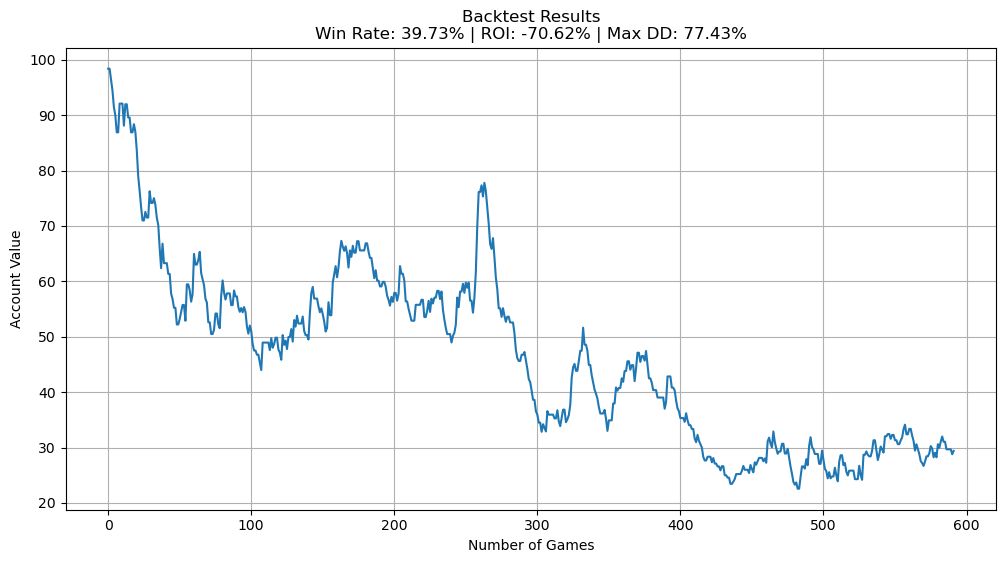

{'final_value': tensor(29.3827),
 'roi': tensor(-0.7062),
 'win_rate': 0.3972602739726027,
 'max_drawdown': tensor(0.7743),
 'total_bets': 592}

In [37]:
# print(second_grid_search.best_params_)
# {'colsample_bytree': 1.0, 'learning_rate': 0.01, 'max_depth': 3, 'min_child_weight': 3, 'n_estimators': 100, 'subsample': 1.0}


home_teams = [mlb_utils.get_team_name(home_cat_mapping[int(idx.item())]) for idx in perf_y_col[:,3]]
visitor_teams = [mlb_utils.get_team_name(visitor_cat_mapping[int(idx.item())]) for idx in perf_y_col[:,4]]


bestParams = {'learning_rate': 0.0035186306575527666, 'max_depth': 3, 'n_estimators': 65, 'subsample': 0.8338284295175771, 'colsample_bytree': 0.9728595668863698, 'min_child_weight': 7, 'reg_lambda': 6.374132610675493e-05}
# 0.6755009295760646
bestParams = {'learning_rate': 0.0029080562742903647, 'max_depth': 3, 'n_estimators': 78, 'subsample': 0.9551738720891991, 'colsample_bytree': 0.8551040642066862, 'min_child_weight': 1, 'reg_lambda': 3.822643297623009e-05}
# 0.6757348610121128
bestParams = {'learning_rate': 0.0037295086541699403, 'max_depth': 3, 'n_estimators': 492, 'subsample': 0.6072556953240497, 'colsample_bytree': 0.9763844478197186, 'min_child_weight': 6, 'reg_lambda': 0.0017829408224452566}

# slidingWindow50? (not 20?) 0.6736662270176593
bestParams = {'learning_rate': 0.004150917832035648, 'max_depth': 3, 'n_estimators': 465, 'subsample': 0.6150870478442888, 'colsample_bytree': 0.9449141809375732, 'min_child_weight': 1, 'reg_lambda': 0.001537197859591791}
classifier, calibrator = objective(None, bestParams)

perf_conts_res = classifier.predict_proba(perf_conts)
perf_conts_calibrated = calibrator.predict_proba(perf_conts_res)


pcc_tensor = torch.FloatTensor(perf_conts_calibrated[:,0])


# Convert from 2d ([home, visitor] b/t 0 and 1) to -1 (home) to 1 (visitor) range used by custom_criterion
# print(pcc_tensor)
pcc_tensor_formatted = (pcc_tensor - 0.5) * 2
# print(pcc_tensor_formatted)


perf_y_col_tensor = torch.FloatTensor(perf_y_col)
# print(perf_y_col_tensor[:,1])
# print(perf_y_col_tensor[:,2])
performance_tensor = custom_criterion(pcc_tensor_formatted, perf_y_col_tensor, 0.5, 0.1, True, 0.05)


mlb_utils.backtest_model_custom_loss(performance_tensor, perf_date_col, initial_capital=100, show_plot=True,
                                     home_teams=home_teams, visitor_teams=visitor_teams, probas=pcc_tensor_formatted)




In [35]:
def custom_criterion(x, y, pearson_multiplier=0.5, max_bet_pct=0.1, return_res_array=False, over_market_odds=0.0):
    # ------------------------------------------------
    # Preliminary calculations
    # ------------------------------------------------
    # acct_value = 100 # Preset account value
    batch_size = len(x)
    h_start_odds = y[:,1]
    v_start_odds = y[:,2]
    h_won = y[:,0]
    y_decimal_odds = torch.where(x > 0, h_start_odds, v_start_odds) # Decimal odds for model's predicted outcome
    y_prob = 1 / y_decimal_odds                  # Implied Probability (regardless of correct prediction)
    x_H_Won = torch.round(torch.sigmoid(20 * x)) # H_won for predicted bets (Converts model's -1 to 1 range to 0 to 1)
                                                 # Sigmoid so that it's differentiable. The 20 is arbitrarily large number

    # print(x_H_Won)
    # print(h_won)
    y_incorrect_prediction = torch.abs((x_H_Won - h_won))        # 1 if wrong bet, otherwise 0. Used to reset kelly when wrong
    # print(y_incorrect_prediction)
    y_incorrect_prediction_mult_two = 2 * y_incorrect_prediction   # 2 if wrong bet, 0 if correct
    # print(y_incorrect_prediction_mult_two)

    #x = torch.abs(x)         # OLD VERSION
    x_prob = torch.where(x > 0, (x + 1) / 2, (1 - x) / 2)
    x = x_prob                # x is now the implied probability(?) of your prediction.
                              # It's a number between 0 and 1 (formerly -1 and 1) representing the model's predicted probability of a win.
                              # This now only shows the probability. Not whether it was correct & not for which side (home vs visitor)

    # ------------------------------------------------
    # 1. Calculate the Pearson Correlation Coefficient
    #    Currently includes cases where predicted wrong
    #    ^ This is filtered out after step 2
    # ------------------------------------------------
    n = x.size(0)
    sum_x = torch.sum(x)
    sum_x_squared = sum_x**2 # 6/22/25 sum_x_squared should just be x**2 (same w/ sum_y_squared)
    sum_y = torch.sum(y_prob)
    sum_y_squared = sum_y**2
    sum_pow_x = torch.sum(x**2)
    sum_pow_y = torch.sum(y_prob**2)
    x_mul_y = torch.mul(x, y_prob)
    sum_x_mul_y = torch.sum(x_mul_y)

    
    # PCC Formula (eps to avoid NaN)
    eps = 1e-8
    pcc_numerator = n * sum_x_mul_y - sum_x * sum_y
    pcc_denominator_one = torch.sqrt(n * sum_pow_x - sum_x_squared + eps)
    pcc_denominator_two = torch.sqrt(n * sum_pow_y - sum_y_squared + eps)
    pcc = pcc_numerator / (pcc_denominator_one * pcc_denominator_two + eps)
    pcc = pearson_multiplier * torch.abs(pcc)



    # ------------------------------------------------
    # 1.5 Only bet on cases where your predicted odds
    #    are <over_market_odds> greater than the
    #    market odds
    # Note: x_prob is implied probability of your prediction
    # y_prob is market odds implied probability of predicted win
    # ------------------------------------------------
    if over_market_odds != 0.0:
        x = torch.where(x_prob > y_prob + over_market_odds, x, 0)
        print("axprod")
        print(x)
    
    
    
    # ------------------------------------------------
    # 2. Calculate the kelly criterion
    #    Entirely wrong predictions are negated and kept in "incorrect_bets" (pcc not applied to wrong predictions)
    #    Correct predictions are kept in "correct_bets". Pcc is applied to this & stored in pcc_adjusted_correct_bets
    #    Possible issue: This always bets max_bet_pct
    #    The result is cumulatively calculated. i.e. The sum of the previous values are used to calculate the next one
    # ------------------------------------------------
    # kelly_criterion = x - ((1 - x) / y_decimal_odds)  # OLD VERSION
    kelly_criterion = x - ((1 - x) / (y_decimal_odds - 1))

    print(kelly_criterion)
    bet_multiplier = torch.clamp(kelly_criterion, min=0)   # Kelly results that are negative are ignored
    bet_multiplier = bet_multiplier*max_bet_pct            # Scale down the bets to the maximum allowed percentage per bet

    # 4/5/25 adjustment of kelly
    #    Want to use cumprod. Cumsum does nothing and is the same as torch.sum in this scenario?
    #    Basically start with max_bet_pct and return as if you made the bets sequentially
    correct_bet_multiplier = bet_multiplier - (bet_multiplier * y_incorrect_prediction)          # Correct bets after kelly. Bet multiplier or 0
    if not return_res_array:
        correct_bet_multiplier = correct_bet_multiplier * (1 - pcc)                              # "correct_bet_multiplier" penalized by pcc
    assert torch.all(correct_bet_multiplier <= max_bet_pct), "Correct bet mult. can't exceed max bet pct"


    correct_bet_multiplier = correct_bet_multiplier * (y_decimal_odds - 1)                       # Bet multiplier taking market odds into account
    incorrect_bet_multiplier = bet_multiplier - (bet_multiplier * y_incorrect_prediction_mult_two) # Negative numbers are incorrect bets
    incorrect_bet_multiplier = torch.clamp(incorrect_bet_multiplier, max=0)                      # Restrict to 0 or negative
    combined_bet_multiplier = correct_bet_multiplier + incorrect_bet_multiplier                  # Combine correct & incorrect bet multipliers
    combined_bet_multiplier = combined_bet_multiplier + 1                                        # Converts to format friendly to cumprod
                                                                                                 # Ex: loss=-0.3, profit=0.3 --> loss=0.7, profit=1.3

    print("bet_multiplier")
    print(bet_multiplier)
    print(y_incorrect_prediction_mult_two)
    # print(max_bet_pct)
    # print(incorrect_bet_multiplier)
    
    assert torch.all((x >= 0) & (x <= 1)), "Probabilities must be between 0 and 1"
    assert torch.all(y_decimal_odds > 1), "Decimal odds must be greater than 1"
    assert torch.all(kelly_criterion <= 1), "Kelly Criterion cannot be greater than 1"
    assert torch.all(incorrect_bet_multiplier >= -max_bet_pct), "Incorrect bet mult. can't exceed max bet pct"
    
    # ------------------------------------------------
    # Combine & Return
    #     Negate everything for Adam & optuna
    # ------------------------------------------------
    if return_res_array:
        return combined_bet_multiplier

In [ ]:

print(perf_conts_calibrated)

print(perf_conts_calibrated[:,0])



In [ ]:
# Get home/visitor team mapping
home_teams = [mlb_utils.get_team_name(home_cat_mapping[int(idx.item())]) for idx in perf_y_col[:,3]]
visitor_teams = [mlb_utils.get_team_name(visitor_cat_mapping[int(idx.item())]) for idx in perf_y_col[:,4]]


# probas_tensor = 1/ probas_tensor
# print(probas_tensor)
# print(perf_y_col_tensor)
# Convert to torch tensor
# probas_tensor = torch.from_numpy(probas)
perf_y_col_copy = np.copy(perf_y_col)
perf_y_col_copy[:,0] = np.clip(perf_y_col_copy[:,0], 0, 1)
perf_y_col_tensor = torch.from_numpy(perf_y_col_copy)


performance_tensor = mlb_utils.custom_criterion(probas_tensor,
                                      perf_y_col_tensor,
                                      pearson_multiplier=0.0,
                                      max_bet_pct=0.1,
                                      return_res_array=True)

# print(probas.type)
# probas_tensor = torch.from_numpy(probas)
mlb_utils.backtest_model_custom_loss(performance_tensor,          # pre-calculated profit/loss
                                     perf_date_col,               # Reporting
                                     initial_capital=100,
                                     show_plot=True,
                                     home_teams=home_teams,       # Reporting
                                     visitor_teams=visitor_teams, # Reporting
                                     probas=probas_tensor.numpy())               # To tell which team won (reporting)



In [ ]:
# Manual Accuracy Calculation
# print(probas_tensor)
probas_convert = torch.round(torch.sigmoid(20*probas_tensor))
y_probas = perf_y_col_tensor[:,0]
# print(y_probas)
# print(probas_convert)
y_probas = y_probas == probas_convert
# print(y_probas)
print(torch.sum(y_probas) / len(y_probas))
